<h1 style="color:Blue; text-align:center;">PatchTST for NDVI</h1>


In [1]:
import numpy as np
import xarray as xr
import torch
import subprocess
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
sys.path.append("./PatchTST_supervised/")


import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from PatchTST_supervised.models.PatchTST import Model as PatchTSTModel


import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

 Forecasting NDVI values is essentially a time series forecasting problem, which is the application domain for which the PatchTST model has been designed.
 
The PatchTST model would be suitable for this task due to several reasons:

* **Long-Term Forecasting**: The model is tailored for long-term forecasting, which is relevant for NDVI where changes in vegetation might be slow and patterns may only emerge over extended periods.

*  **Handling Multivariate Time Series**: Although NDVI values from a single pixel are univariate, the PatchTST model is capable of handling multivariate time series. This means that if we have additional variables that may affect NDVI, such as temperature, precipitation, or other environmental factors, the model can potentially incorporate them into its forecasting.

* **Efficiency with Long Sequences**: The segmentation into patches allows the model to efficiently process long time series data, which would be the case with a dataset spanning from 1983 to 2023.

* **Self-Supervised Learning Capability**: If labeled data for NDVI forecasting is limited, the model's self-supervised pre-training could be particularly useful. It can leverage large amounts of unlabeled time series data to learn useful representations before being fine-tuned for forecasting.

# On Authors dataset

Each row corresponds to an entry or record from your CSV file. In the context of a time series dataset like the weather data, each row could represent a time step.

Each column corresponds to a feature or variable in your dataset. If this is multivariate time series data (which is typical for weather datasets), each of these columns could represent a different variable being tracked over time, such as temperature, humidity, wind speed, etc.

## Weather Dataset

* **seq_len**: This is the length of the input sequence, meaning how many time steps from the past data the model will look at to make a prediction. For instance, if seq_len is 24 and you have hourly data, the model will use the past 24 hours of data to make a forecast.

* **label_len**: This refers to the length of the output sequence that the model should predict, and it's used to train the model. If label_len is also 24, the model is being trained to predict the next 24 hours of data at each step.

* **prediction_len**: This is the length of the sequence that the model will be predicting when it's deployed. For training, this would typically be the same as the label_len, but it could be different if, for example, the model is being trained to predict a range of future values but only needs to output a single value or a shorter sequence in deployment.

 * **scale**: This boolean parameter determines whether the data should be scaled. Scaling is a preprocessing step to normalize or standardize data, typically so that all features contribute equally to the model's training. If scale is set to True, then the StandardScaler is applied to the data.

In [8]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len, label_len, prediction_len, scale=True):
        self.seq_len = seq_len
        self.pred_len = prediction_len
        self.data = data
        self.features = data.columns.tolist()
        self.target = 'T (degC)'  # You will need to set your target variable here

        # Scale the data if scale is True
        if scale:
            self.scaler = StandardScaler()
            self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[self.features].iloc[index:index+self.seq_len].values
        y = self.data[self.target].iloc[index+self.seq_len:index+self.seq_len+self.pred_len].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

The output of this class would be 
* x a tensor of shape [batch_size, seq_length, num_features]
* y a tensor of shape [batch_size, seq_length]


In [13]:
# Load your data
df = pd.read_csv('weather.csv')[:1000]
# Convert date column to datetime and sort by date if not already
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# Create the WeatherDataset instance
seq_len = 24  # Input sequence length
label_len = 24  # Target sequence length
prediction_len = 24  # Length of the sequence to be predicted
dataset = WeatherDataset(df, seq_len, label_len, prediction_len)



In [14]:
dataset[0][1].shape

torch.Size([24])

In [15]:
# Create DataLoader for training
batch_size = 64

# Define the size of the splits
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Calculate the number of samples in each set
n = len(df)
train_end = int(train_size * n)
val_end = train_end + int(val_size * n)

# Split the data
train_data = df[:train_end]
val_data = df[train_end:val_end]
test_data = df[val_end:]

# Create WeatherDataset instances for each set
train_dataset = WeatherDataset(train_data, seq_len, label_len, prediction_len)
val_dataset = WeatherDataset(val_data, seq_len, label_len, prediction_len)
test_dataset = WeatherDataset(test_data, seq_len, label_len, prediction_len)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_472/1194406224.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.features] = self.scaler.fit_transform(self.data[self.features])
/tmp/ipykernel_472/1194406224.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.features] = self.scaler.fit_transform(self.data[self.features])
/tmp/ipykernel_472/1194406224.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

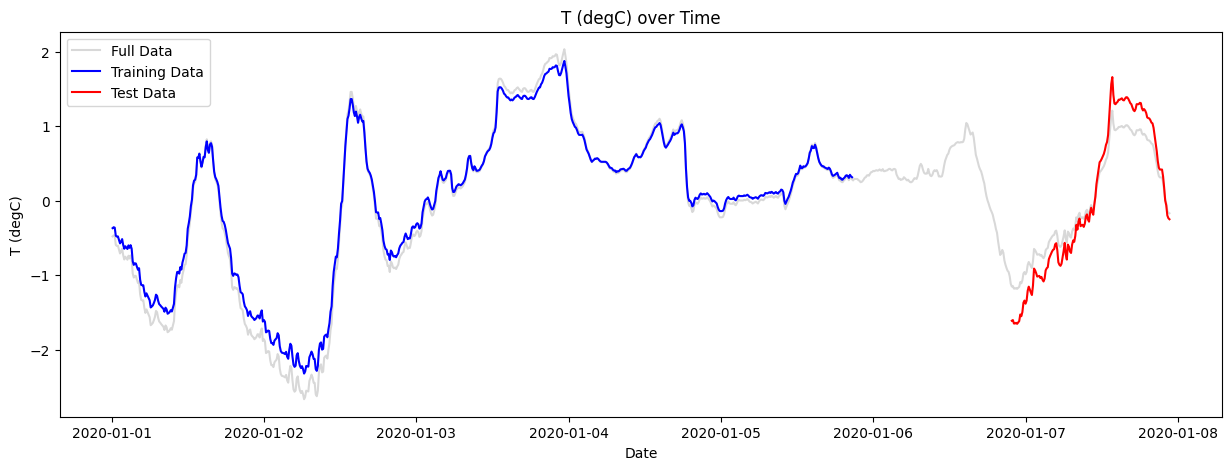

In [18]:
import matplotlib.pyplot as plt

# Assume 'variable' is the column name of the variable of interest
variable = 'T (degC)'  # Replace with your actual variable name

# Plot the entire series
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[variable], label='Full Data', color='grey', alpha=0.3)

# Overlay the training data
plt.plot(train_data.index, train_data[variable], label='Training Data', color='blue')

# Overlay the test data
plt.plot(test_data.index, test_data[variable], label='Test Data', color='red')

# Add title and labels
plt.title(f'{variable} over Time')
plt.xlabel('Date')
plt.ylabel(variable)

# Add legend
plt.legend()

# Show the plot
plt.show()


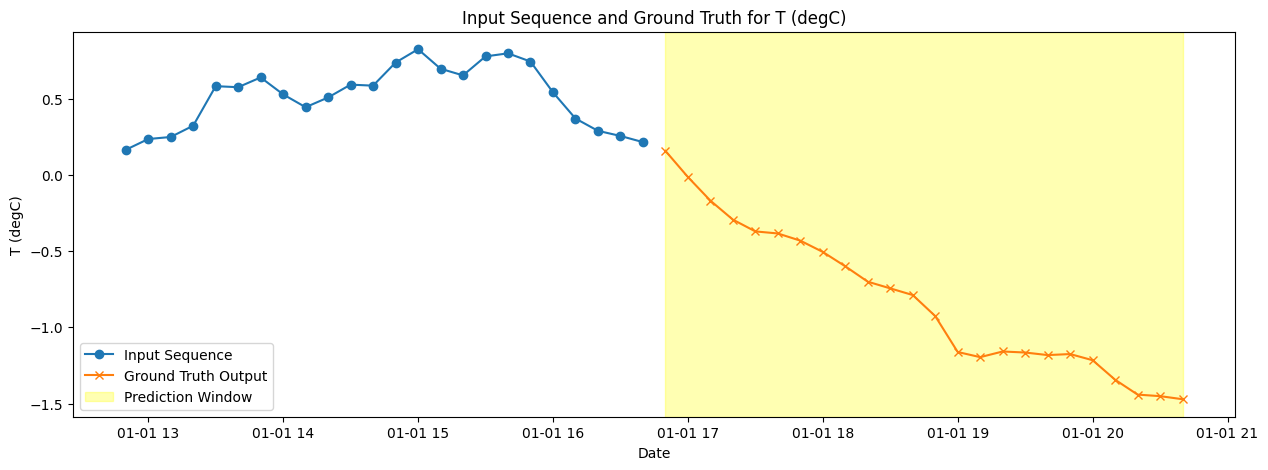

In [19]:
import matplotlib.pyplot as plt

# Parameters
seq_len = 24  # Example: 24 hours of data
label_len = 24  # Example: Predict the next 24 hours

# Select an index where you want to start the prediction
index = 100  # This is an arbitrary index for illustration

# Define the variable you're interested in
variable = 'T (degC)'  # Replace with your actual variable name

# Extract the input sequence and the ground truth output sequence
input_sequence = df[variable].iloc[index-seq_len:index].values
ground_truth_output = df[variable].iloc[index:index+label_len].values

# Time indexes for plotting
input_time_index = df.index[index-seq_len:index]
output_time_index = df.index[index:index+label_len]

# Plotting
plt.figure(figsize=(15, 5))

# Plot the input sequence
plt.plot(input_time_index, input_sequence, label='Input Sequence', marker='o')

# Plot the ground truth for the output sequence
plt.plot(output_time_index, ground_truth_output, label='Ground Truth Output', marker='x')

# Highlight the prediction region
plt.axvspan(output_time_index[0], output_time_index[-1], color='yellow', alpha=0.3, label='Prediction Window')

# Add title and labels
plt.title(f'Input Sequence and Ground Truth for {variable}')
plt.xlabel('Date')
plt.ylabel(variable)

# Add legend
plt.legend()

# Show the plot
plt.show()


### Define the model

In [33]:
from types import SimpleNamespace

# Configuration example for PatchTSTModel
config = {
    'enc_in': 1 ,  # Replace with the actual number of features in your dataset
    'seq_len': 24,          # Use the past 24 hours of data to make a prediction
    'pred_len': 24,         # Predict the next 24 hours of data
    'e_layers': 3,          # Number of encoder layers
    'n_heads': 8,           # Number of attention heads
    'd_model': 512,         # Model dimensionality
    'd_ff': 2048,           # Dimension of feed-forward network
    'dropout': 0.1,         # Dropout rate
    'fc_dropout': 0.1,      # Fully connected layer dropout
    'head_dropout': 0.1,    # Head dropout
    'individual': True,     # Individual layer normalization
    'patch_len': 16,        # Patch length
    'stride': 1,            # Stride for patches
    'padding_patch': 0,     # Padding for patches
    'revin': True,          # Reversible instance normalization
    'affine': True,         # Affine parameter for instance normalization
    'subtract_last': False, # Subtract last parameter for reversible instance normalization
    'decomposition': False, # Whether to use decomposition
    'kernel_size': 3,       # Kernel size for decomposition
    # Additional parameters with their default values from the model
    'max_seq_len': 1024,
    'd_k': 64,
    'd_v': 64,
    'norm': 'BatchNorm',
    'attn_dropout': 0.0,
    'act': 'gelu',
    'key_padding_mask': 'auto',
    'padding_var': None,
    'attn_mask': None,
    'res_attention': True,
    'pre_norm': False,
    'store_attn': False,
    'pe': 'zeros',
    'learn_pe': True,
    'pretrain_head': False,
    'head_type': 'flatten',
    'verbose': False,
}

# Convert the configuration dictionary to a SimpleNamespace object
config_obj = SimpleNamespace(**config)

# Now you can instantiate your model using this configuration object
# model = PatchTSTModel(config_obj).float()

# Convert the configuration dictionary to a SimpleNamespace object
config_obj = SimpleNamespace(**config)

# Now you can instantiate your model using this configuration object
# model = PatchTSTModel(config_obj).float()


In [34]:
 # Make sure to import the PatchTST model correctly
from types import SimpleNamespace

# Convert the configuration dictionary to an object
config_obj = SimpleNamespace(**config)

# Instantiate the model with the configuration object
model = PatchTSTModel(config_obj).float()




# Step 3: Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Now the model is ready to be trained with your dataset
# Check if GPU is available and move the model to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
            (norm_attn): Sequential(
            

### Training

In [35]:
import warnings

# Filter out the specific warning about input and target size mismatch
warnings.filterwarnings("ignore", category=UserWarning, module='torch.nn.modules.loss')


In [36]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = model.to(device)

# Number of epochs
num_epochs = 20  # Replace with the number of epochs you want to train for

def visualize(inputs, targets, outputs, epoch, idx, phase='Training'):
    plt.figure(figsize=(15, 5))

    # Assuming inputs and targets are [batch, sequence, features]
    # and the first feature is the one we want to plot
    input_sequence = inputs[0, :, 0].detach().cpu().numpy()
    target_sequence = targets[0, :, 0].detach().cpu().numpy()
    output_sequence = outputs[0, :, 0].detach().cpu().numpy()

    # Calculate the x-axis values for plotting
    input_steps = list(range(len(input_sequence)))
    target_steps = list(range(len(input_sequence), len(input_sequence) + len(target_sequence)))

    plt.plot(input_steps, input_sequence, label='Input data')
    plt.plot(target_steps, target_sequence, label='Ground truth')
    plt.plot(target_steps, output_sequence, label='Prediction')

    plt.title(f'{phase} Visualization at Epoch {epoch+1}, Batch {idx+1}')
    plt.legend()
    plt.show()
    
    
    
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_losses = []
    
    for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()  # Clear gradients from the previous step
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model

            print("Inputs shape", inputs.shape)
            print("targets shape", targets.shape)

            # Expand the target tensor to match the output shape
            targets = targets.unsqueeze(-1).expand(-1, -1, 1)
            


            outputs = model(inputs.float())  # Forward pass: compute the model output
            print("Outputs shape", outputs.shape)
            
            loss = criterion(outputs, targets.float())

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            if (idx + 1) % 100 == 0 or (idx + 1) == len(train_loader):
                visualize(inputs,targets, outputs,epoch,idx)

    
    # Compute average training loss
    average_train_loss = sum(train_losses) / len(train_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}")
    
    # Validation loop (if you have a validation set)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        val_losses = []
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
            outputs = model(inputs.float())
            # Expand the target tensor to match the output shape
            targets = targets.unsqueeze(-1).expand(-1, -1, 1)
            loss = criterion(outputs, targets.float())
            val_losses.append(loss.item())
        
        # Compute average validation loss
        average_val_loss = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}")


Inputs shape torch.Size([64, 24, 21])
targets shape torch.Size([64, 24])


KeyboardInterrupt: 

In [99]:
! cd PatchTST_supervised &

sh: ./scripts/PatchTST/weather.sh: No such file or directory


# Multivariate 

This is a dataset with a time step = 10 minutes

he target tensor y now includes all features for the specified label_len. This should resolve the shape mismatch issue you encountered.

The PatchTST model, like other Transformer-based models, is designed to capture interactions between different features (or variables) in your dataset. In your case, when you provide the variables 'T (degC)' and 'rain (mm)' to the model, it doesn't treat them as separate, isolated entities. Instead, the model has the capacity to learn and understand the relationships and interactions between these two variables. Here's how it works:

1. **Attention Mechanism**: The core of the Transformer architecture is the attention mechanism. This allows the model to focus on different parts of the input sequence when making predictions. In the case of multiple variables, the attention mechanism can capture dependencies not just across time steps but also across different features. This means the model can learn, for instance, how changes in temperature ('T (degC)') might relate to changes in rainfall ('rain (mm)').

2. **Input Representation**: When you input a sequence to the model, each time step includes features from both 'T (degC)' and 'rain (mm)'. The model processes this combined feature set, enabling it to understand and utilize the relationships between these features.

3. **Model Layers**: Transformer models typically consist of multiple layers, each of which can capture different aspects of the data. Through these layers, the model can learn complex interactions at various levels of abstraction.

4. **Training Process**: During training, the model adjusts its parameters to minimize the prediction error. This process naturally leads the model to discover and leverage any meaningful interactions between the features that help reduce this error.

In summary, the PatchTST model treats 'T (degC)' and 'rain (mm)' not as isolated variables but as part of a joint feature space. The interactions between these variables are an essential part of what the model learns, allowing it to make more accurate and nuanced predictions.

In [156]:
import torch

def save_checkpoint(model, optimizer, epoch, filename="model_checkpoint.pth"):
    """Save a model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)


def load_checkpoint(model, optimizer, filename="model_checkpoint.pth"):
    """Load a model checkpoint."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return epoch



In [157]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len, label_len, prediction_len, scale=True):
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = prediction_len
        self.data = data
        self.features = data.columns.tolist()

        if scale:
            self.scaler = StandardScaler()
            self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[self.features].iloc[index:index+self.seq_len].values
        # Now y will include all features for the label length
        y = self.data[self.features].iloc[index+self.seq_len:index+self.seq_len+self.label_len].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [158]:
# Load your data
df = pd.read_csv('weather.csv')[:1000]
df= df[['date', 'T (degC)', 'rain (mm)']]
# Convert date column to datetime and sort by date if not already
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# Create the WeatherDataset instance
seq_len = 48  # Input sequence length
label_len = 24  # Target sequence length
prediction_len = 24  # Length of the sequence to be predicted
dataset = WeatherDataset(df, seq_len, label_len, prediction_len)

In [159]:
df

T (degC)  rain (mm)
date                                    
2020-01-01 00:10:00 -0.478245  -0.096508
2020-01-01 00:20:00 -0.464773  -0.096508
2020-01-01 00:30:00 -0.471509  -0.096508
2020-01-01 00:40:00 -0.592756  -0.096508
2020-01-01 00:50:00 -0.606228  -0.096508
...                       ...        ...
2020-01-07 22:00:00  0.013479  -0.096508
2020-01-07 22:10:00 -0.033673  -0.096508
2020-01-07 22:20:00 -0.131344  -0.096508
2020-01-07 22:30:00 -0.158288  -0.096508
2020-01-07 22:40:00 -0.168392  -0.096508

[1000 rows x 2 columns]

In [6]:
# Create DataLoader for training
batch_size = 64

# Define the size of the splits
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Calculate the number of samples in each set
n = len(df)
train_end = int(train_size * n)
val_end = train_end + int(val_size * n)

# Split the data
train_data = df[:train_end]
val_data = df[train_end:val_end]
test_data = df[val_end:]

# Create WeatherDataset instances for each set
train_dataset = WeatherDataset(train_data, seq_len, label_len, prediction_len)
val_dataset = WeatherDataset(val_data, seq_len, label_len, prediction_len)
test_dataset = WeatherDataset(test_data, seq_len, label_len, prediction_len)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_470/2093069567.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.features] = self.scaler.fit_transform(self.data[self.features])
/tmp/ipykernel_470/2093069567.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.features] = self.scaler.fit_transform(self.data[self.features])
/tmp/ipykernel_470/2093069567.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [11]:
from types import SimpleNamespace

# Configuration example for PatchTSTModel
config = {
    'enc_in': df.shape[1] ,  # Replace with the actual number of features in your dataset
    'seq_len': seq_len ,          # Use the past 24 hours of data to make a prediction
    'pred_len': prediction_len,         # Predict the next 24 hours of data
    'e_layers': 3,          # Number of encoder layers
    'n_heads': 8,           # Number of attention heads
    'd_model': 512,         # Model dimensionality
    'd_ff': 2048,           # Dimension of feed-forward network
    'dropout': 0.1,         # Dropout rate
    'fc_dropout': 0.1,      # Fully connected layer dropout
    'head_dropout': 0.1,    # Head dropout
    'individual': True,     # Individual layer normalization
    'patch_len': 16,        # Patch length
    'stride': 1,            # Stride for patches
    'padding_patch': 0,     # Padding for patches
    'revin': True,          # Reversible instance normalization
    'affine': True,         # Affine parameter for instance normalization
    'subtract_last': False, # Subtract last parameter for reversible instance normalization
    'decomposition': False, # Whether to use decomposition
    'kernel_size': 3,       # Kernel size for decomposition
    # Additional parameters with their default values from the model
    'max_seq_len': 1024,
    'd_k': 64,
    'd_v': 64,
    'norm': 'BatchNorm',
    'attn_dropout': 0.0,
    'act': 'gelu',
    'key_padding_mask': 'auto',
    'padding_var': None,
    'attn_mask': None,
    'res_attention': True,
    'pre_norm': False,
    'store_attn': False,
    'pe': 'zeros',
    'learn_pe': True,
    'pretrain_head': False,
    'head_type': 'flatten',
    'verbose': False,
}



# Convert the configuration dictionary to an object
config_obj = SimpleNamespace(**config)

# Instantiate the model with the configuration object
model = PatchTSTModel(config_obj).float()




# Step 3: Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Now the model is ready to be trained with your dataset
# Check if GPU is available and move the model to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
            (norm_attn): Sequential(
            

In [13]:
# Load the model and optimizer from the last checkpoint
start_epoch = load_checkpoint(model, optimizer, filename="checkpoints/model_checkpoint_epoch_50.pth")

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(inputs, targets, outputs, epoch, idx, feature_names, seq_len):
    # Select a sample from the batch to visualize
    sample_index = 0  # You can choose any index from 0 to batch_size-1

    # Detach and move to CPU for visualization
    inputs_sample = inputs[sample_index].cpu().detach().numpy()
    targets_sample = targets[sample_index].cpu().detach().numpy()
    outputs_sample = outputs[sample_index].cpu().detach().numpy()

    # Plotting
    plt.figure(figsize=(12, 6))

    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)

        # Time axis
        time_input = np.arange(seq_len)
        time_future = np.arange(seq_len, seq_len + len(targets_sample))

        # Plot input, target, and output
        plt.plot(time_input, inputs_sample[:, i], label='Input')
        plt.plot(time_future, targets_sample[:, i], label='Target')
        plt.plot(time_future, outputs_sample[:, i], label='Prediction')

        plt.title(f'Epoch {epoch+1}, Batch {idx+1}, {feature_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()


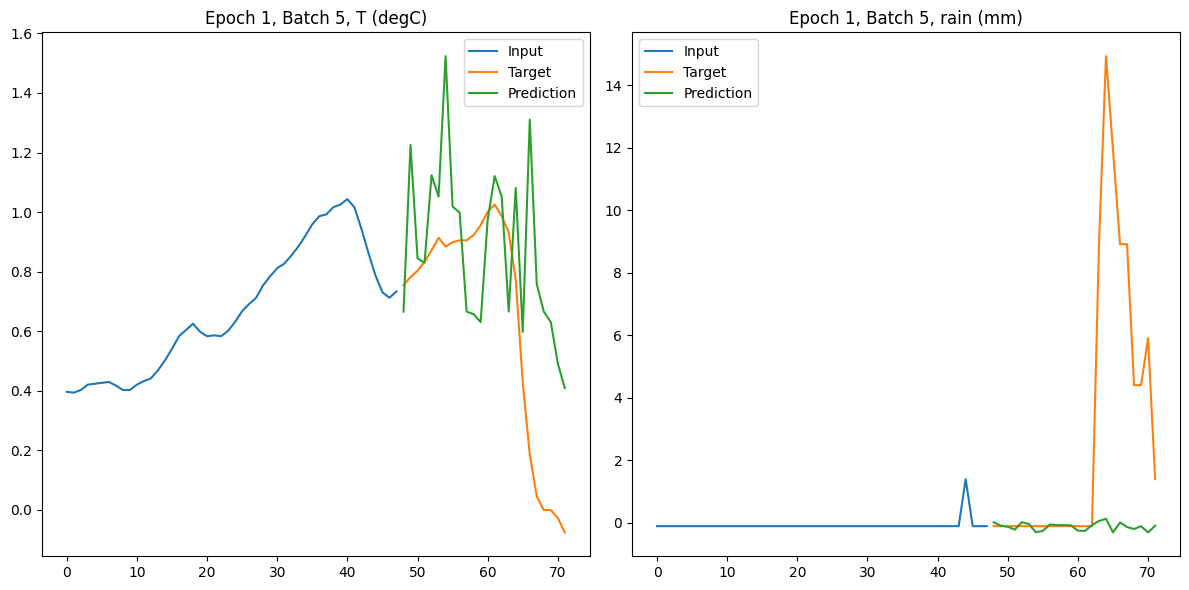

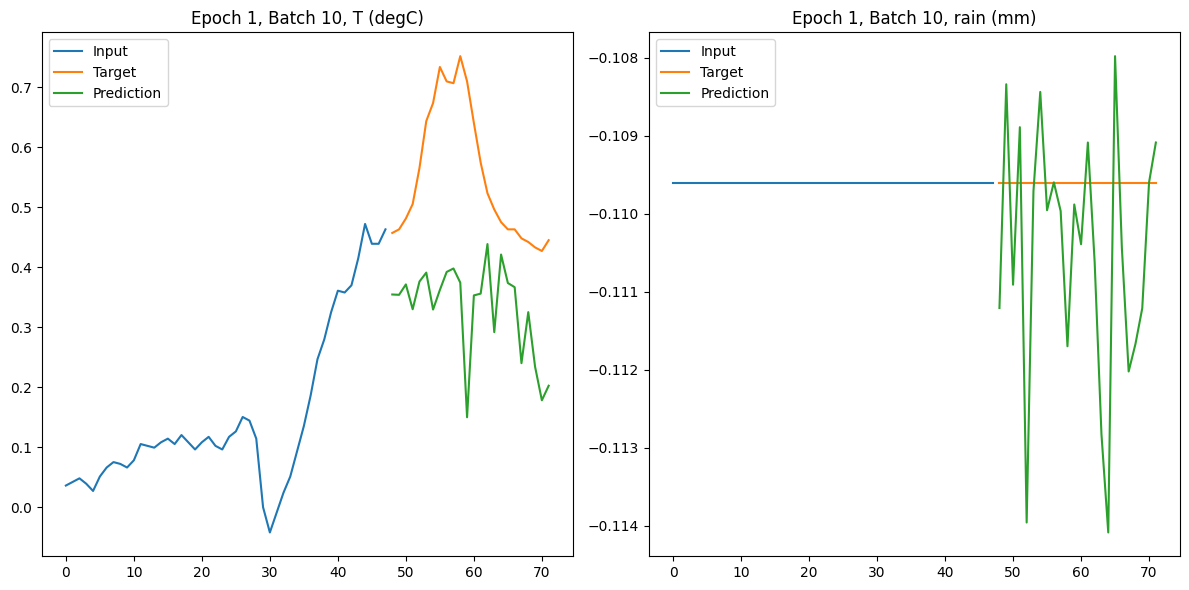

Epoch 1/50, Train Loss: 1.0701
Epoch 1/50, Validation Loss: 1.9536


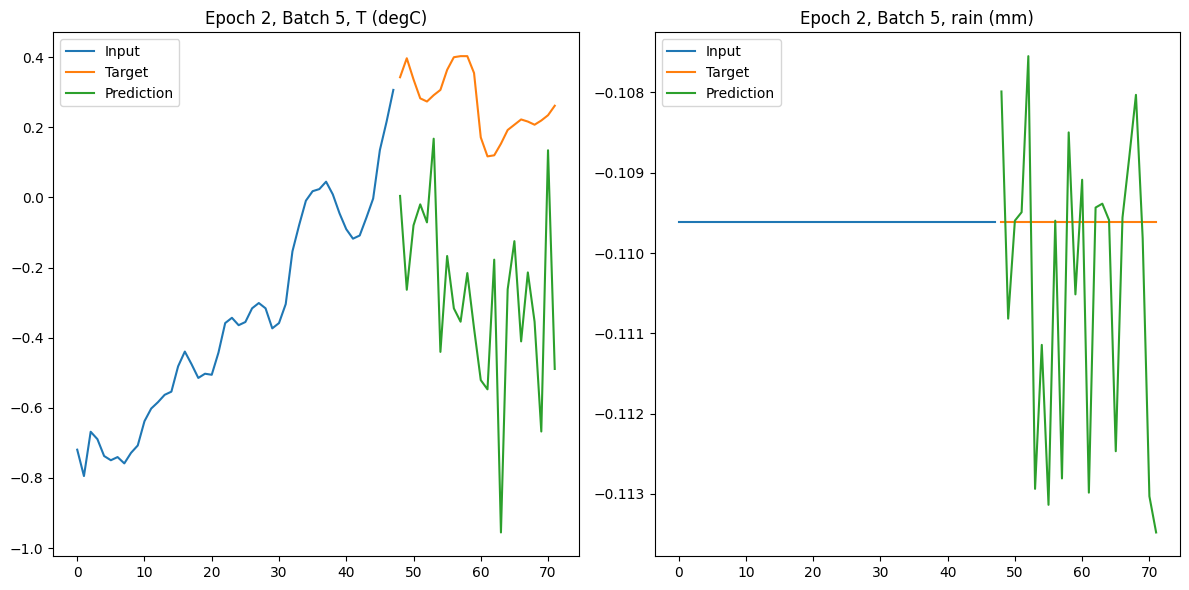

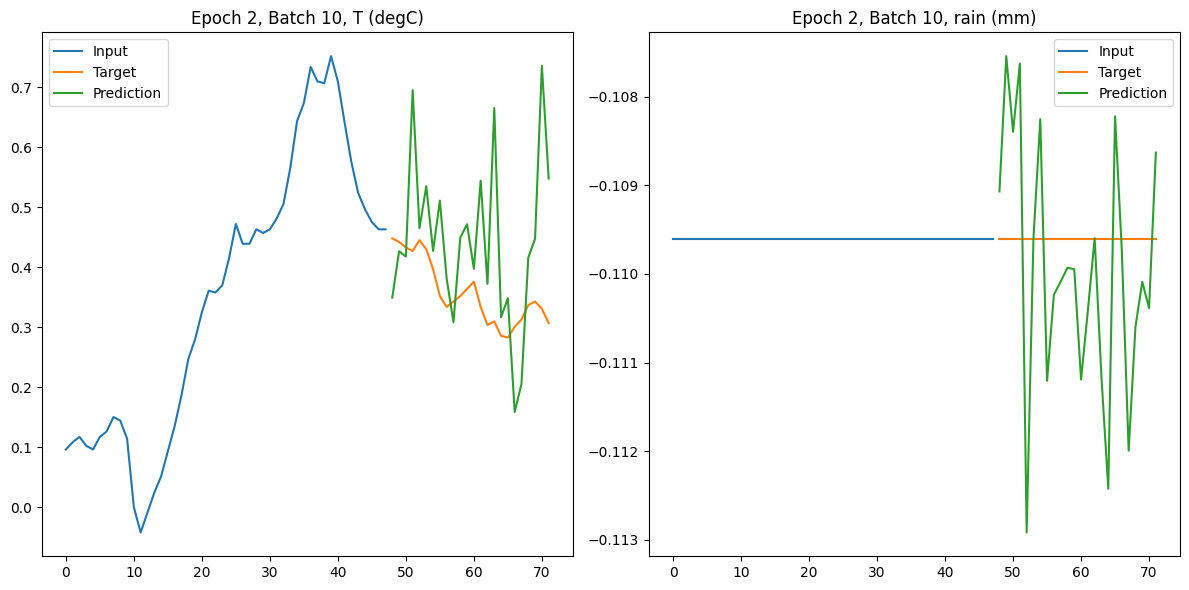

Epoch 2/50, Train Loss: 0.9916
Epoch 2/50, Validation Loss: 1.5717


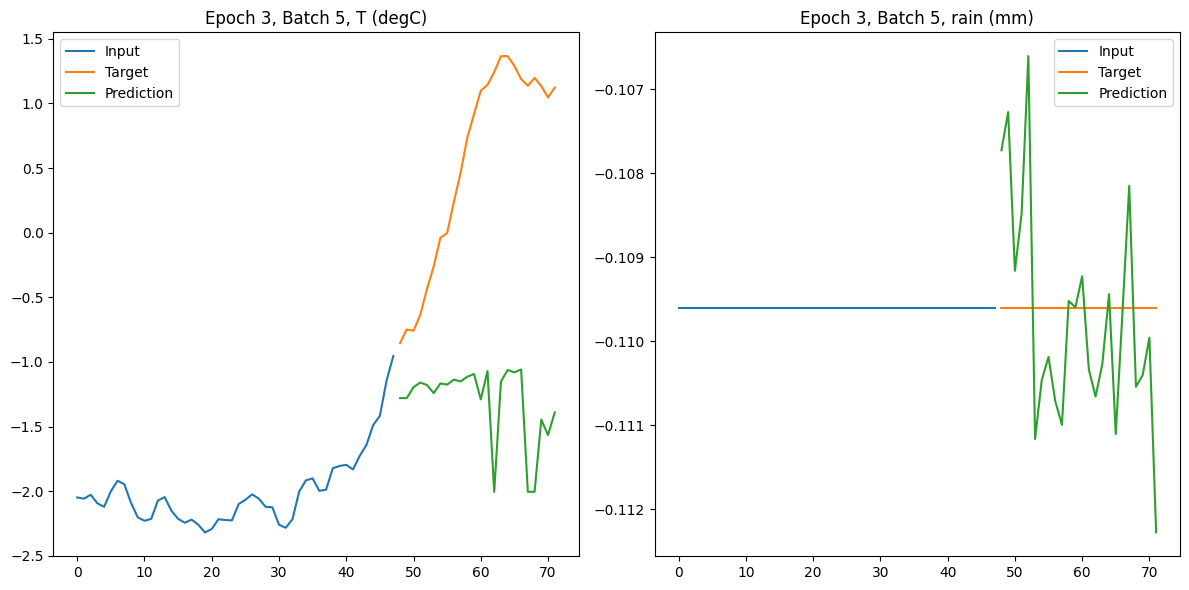

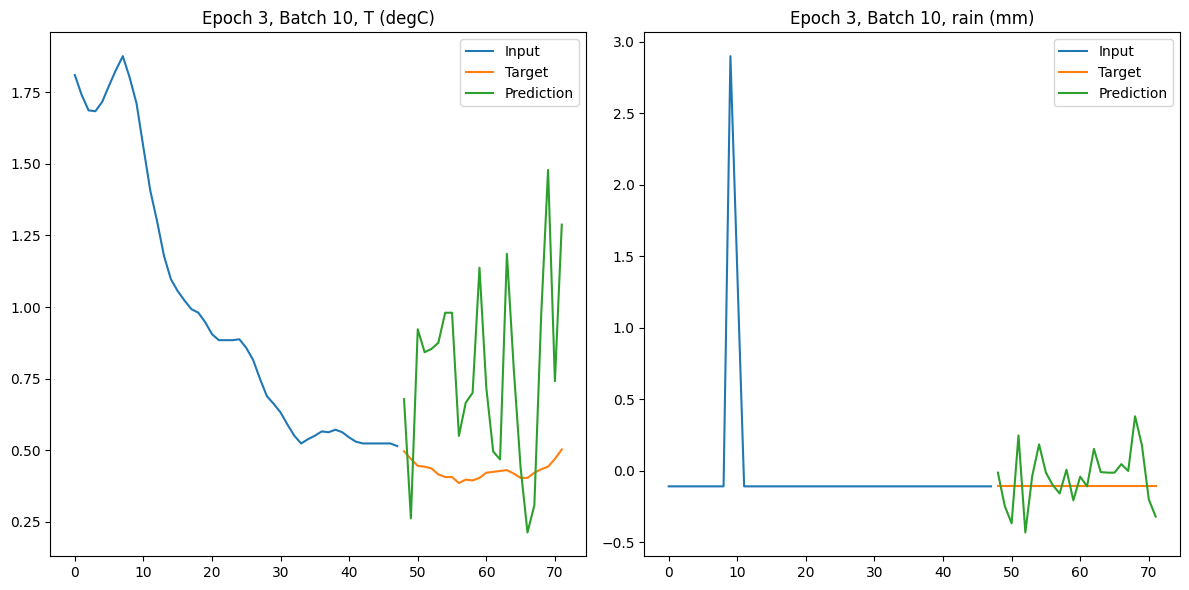

Epoch 3/50, Train Loss: 0.9499
Epoch 3/50, Validation Loss: 1.3267


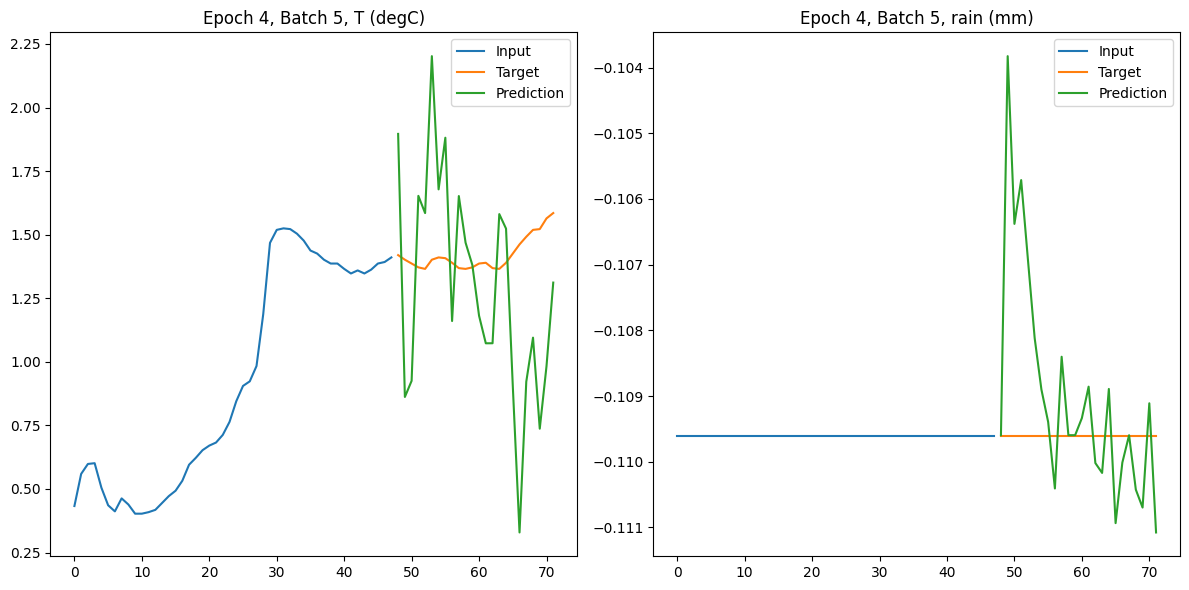

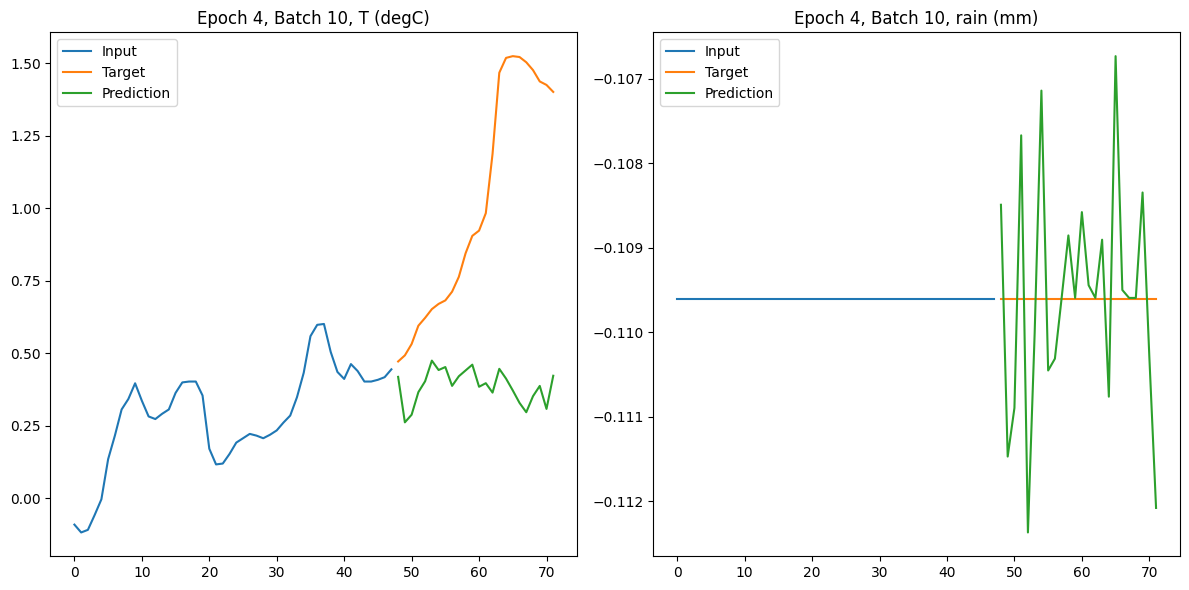

Epoch 4/50, Train Loss: 0.9195
Epoch 4/50, Validation Loss: 1.2055


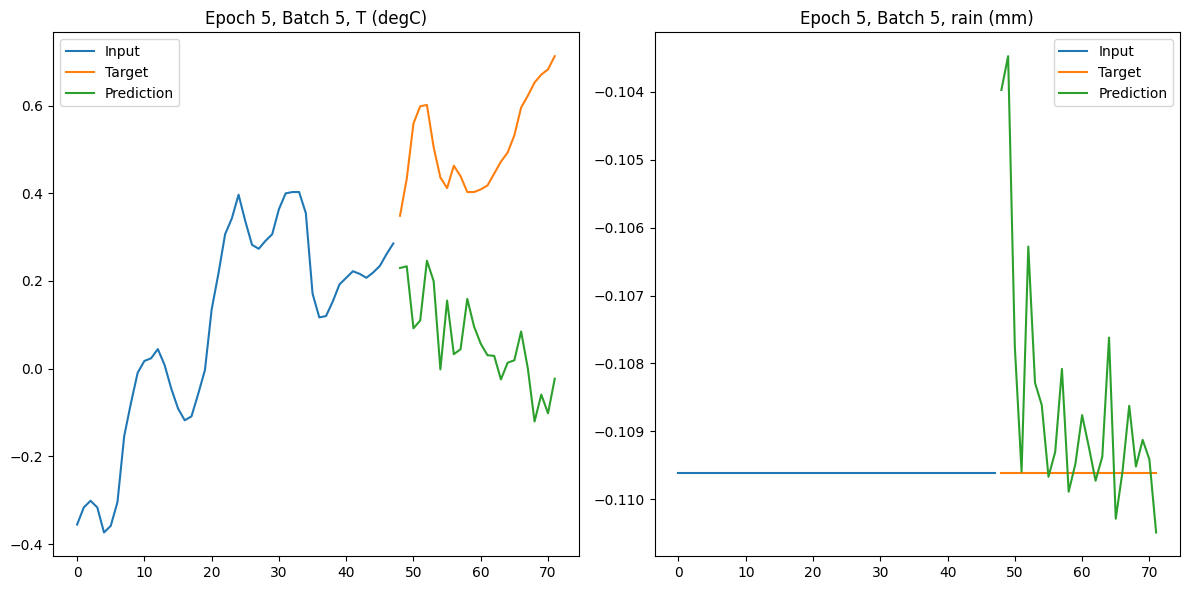

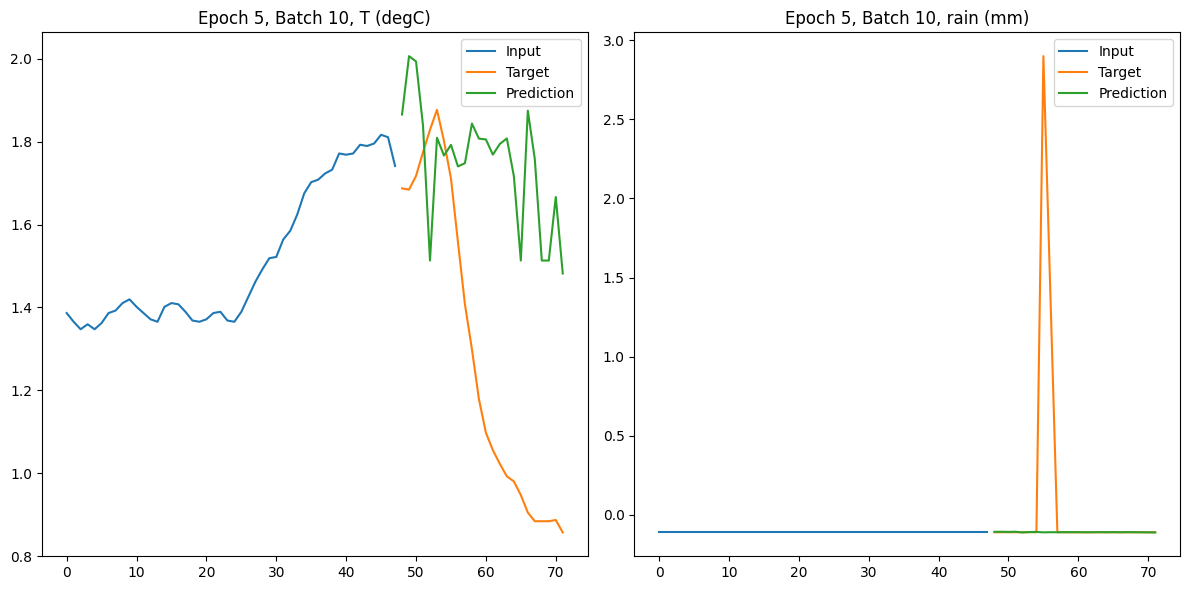

Epoch 5/50, Train Loss: 0.9001
Epoch 5/50, Validation Loss: 1.1591


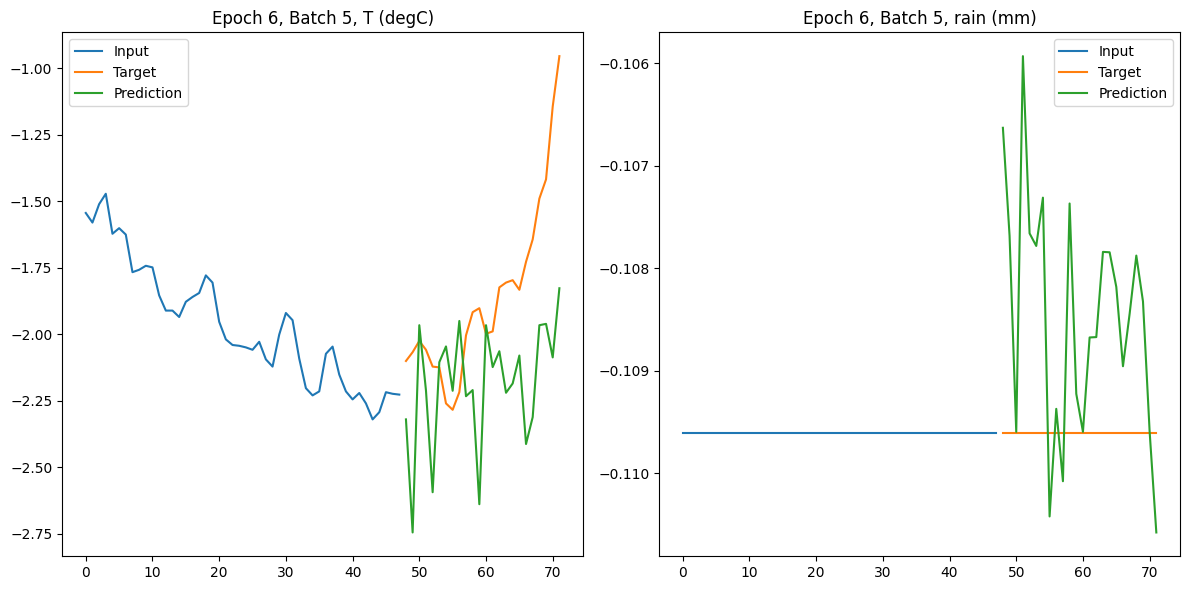

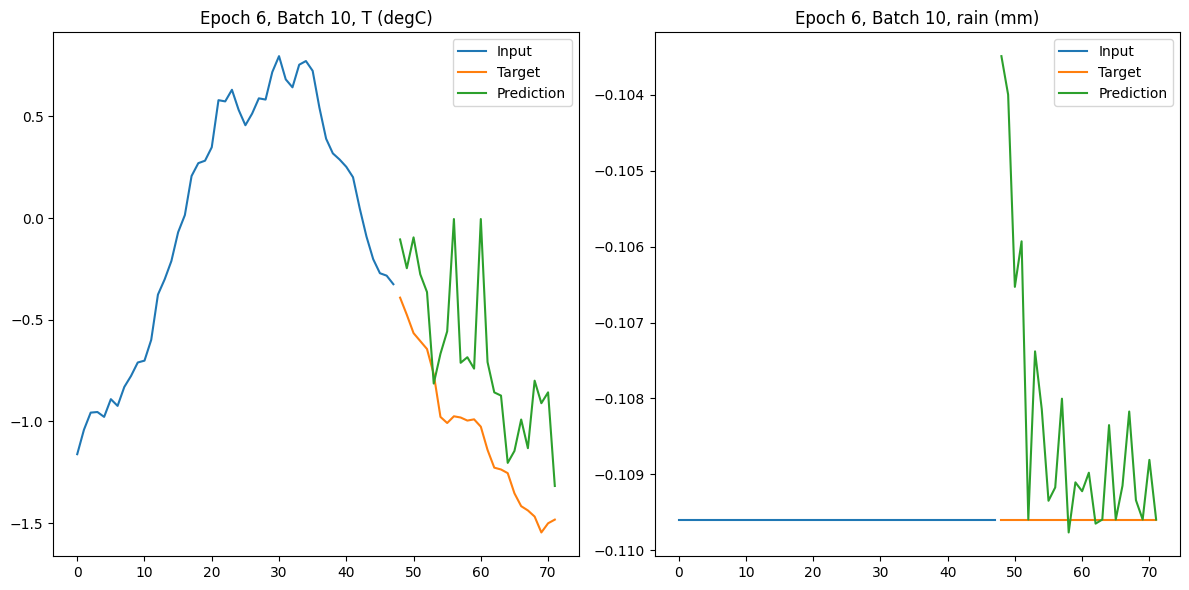

Epoch 6/50, Train Loss: 0.8802
Epoch 6/50, Validation Loss: 1.1081


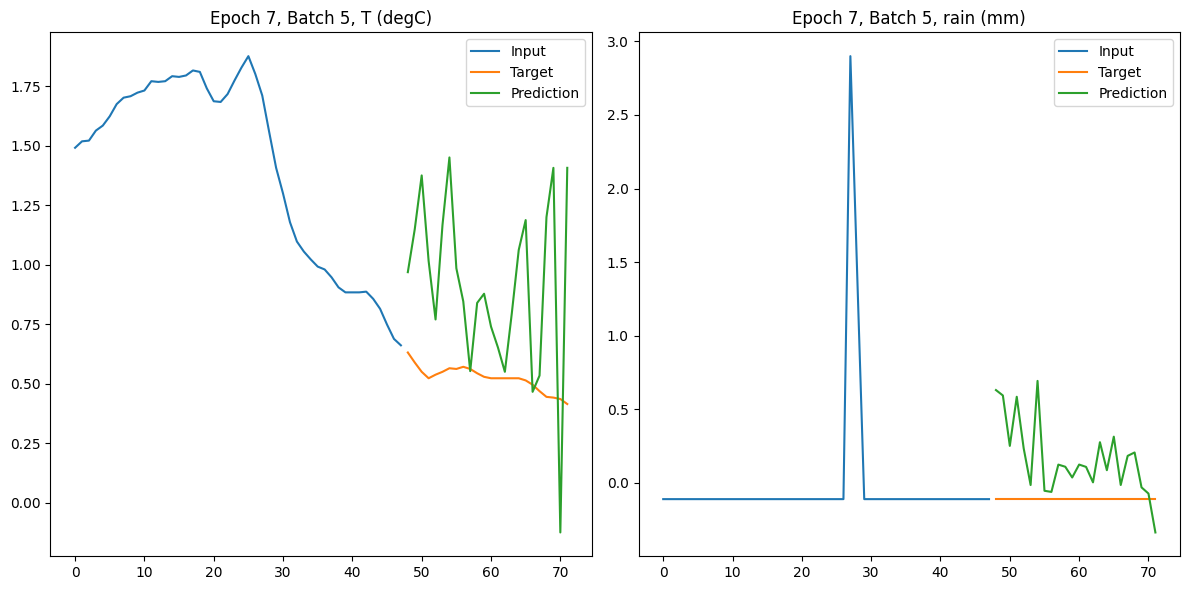

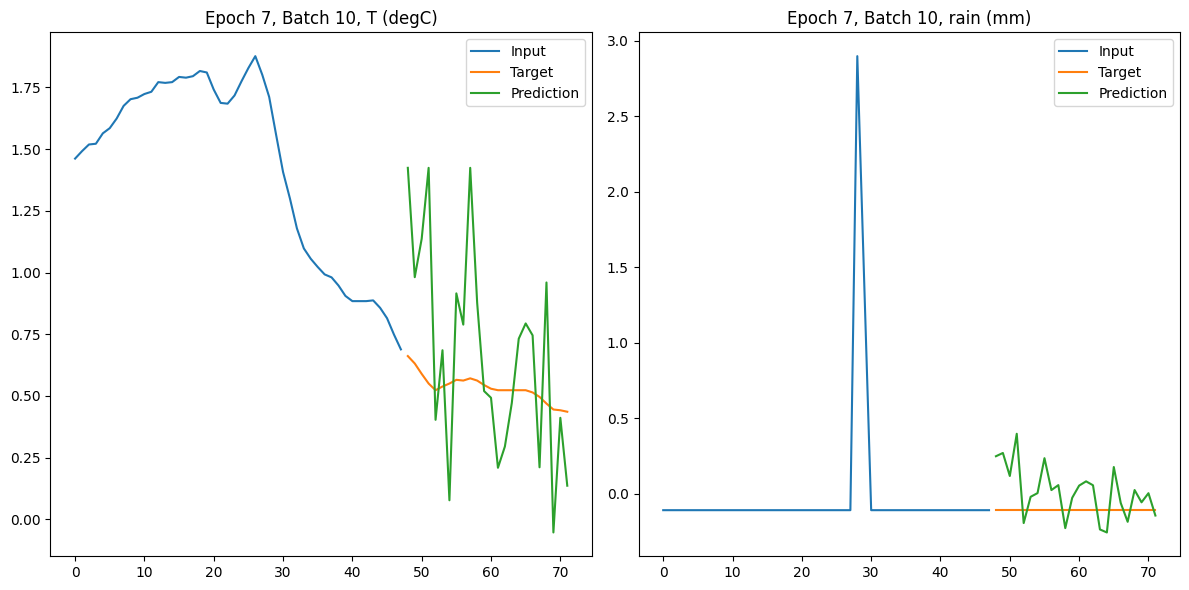

Epoch 7/50, Train Loss: 0.8681
Epoch 7/50, Validation Loss: 1.0828


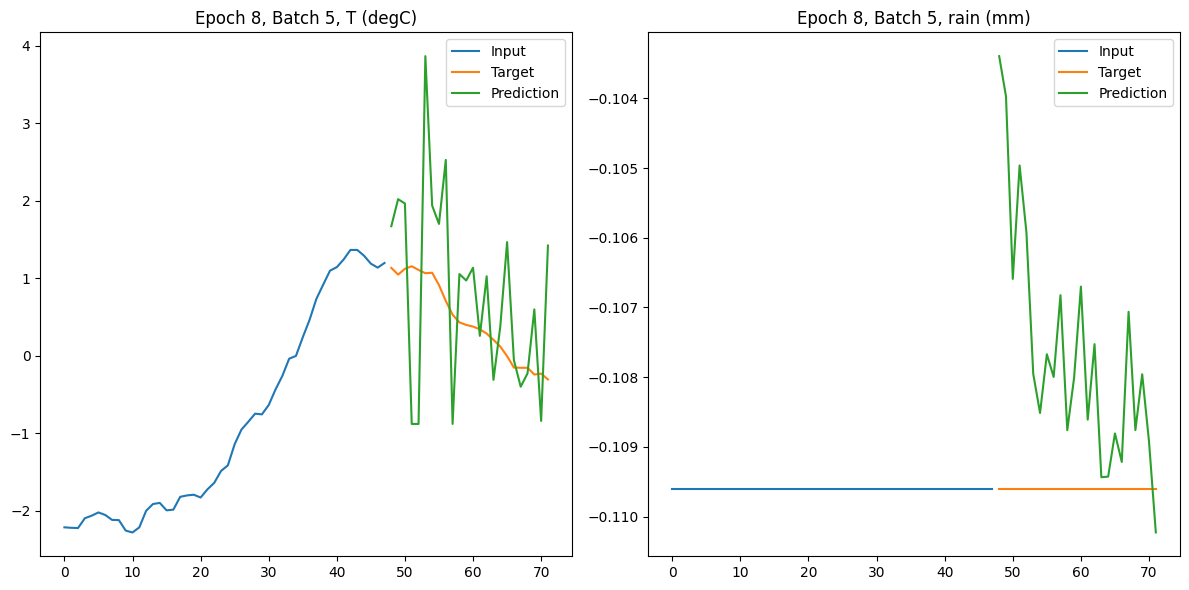

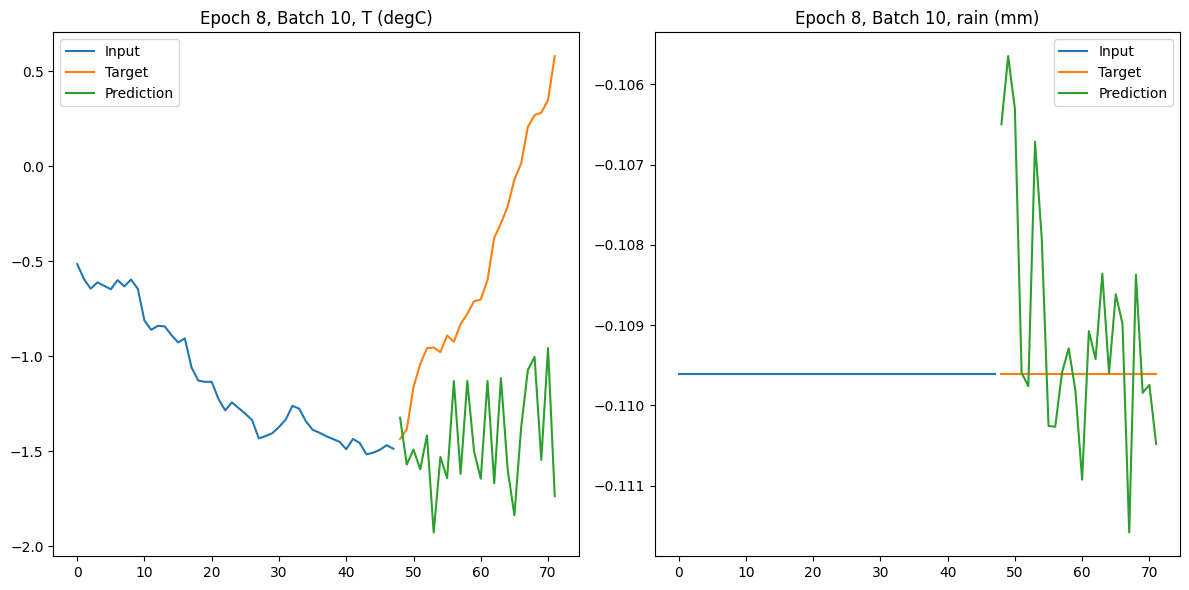

Epoch 8/50, Train Loss: 0.8575
Epoch 8/50, Validation Loss: 1.0641


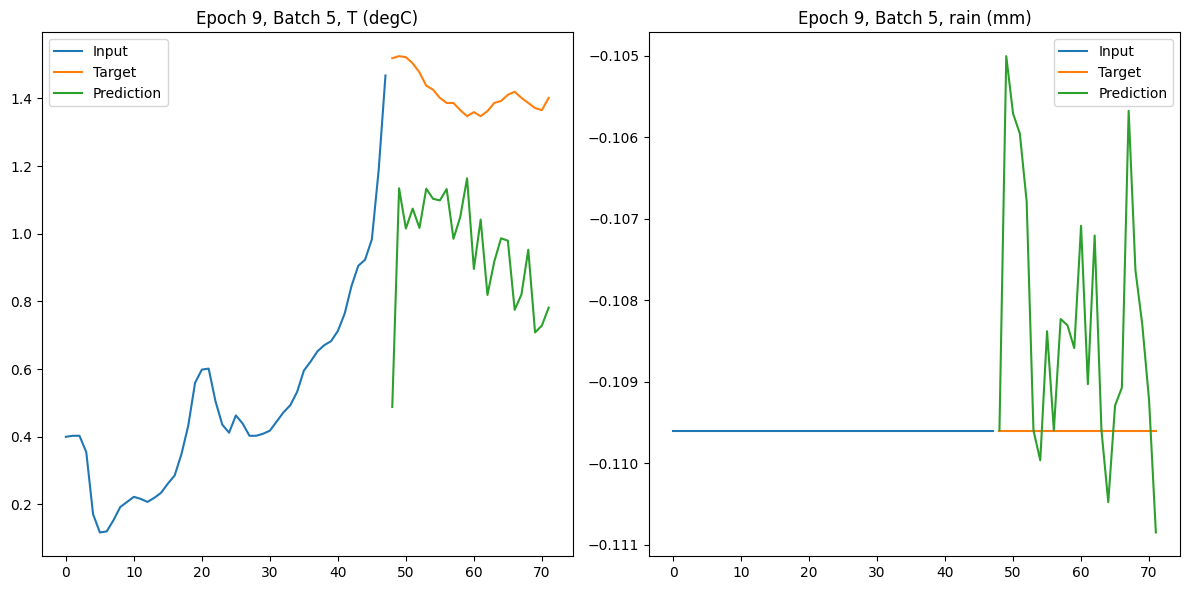

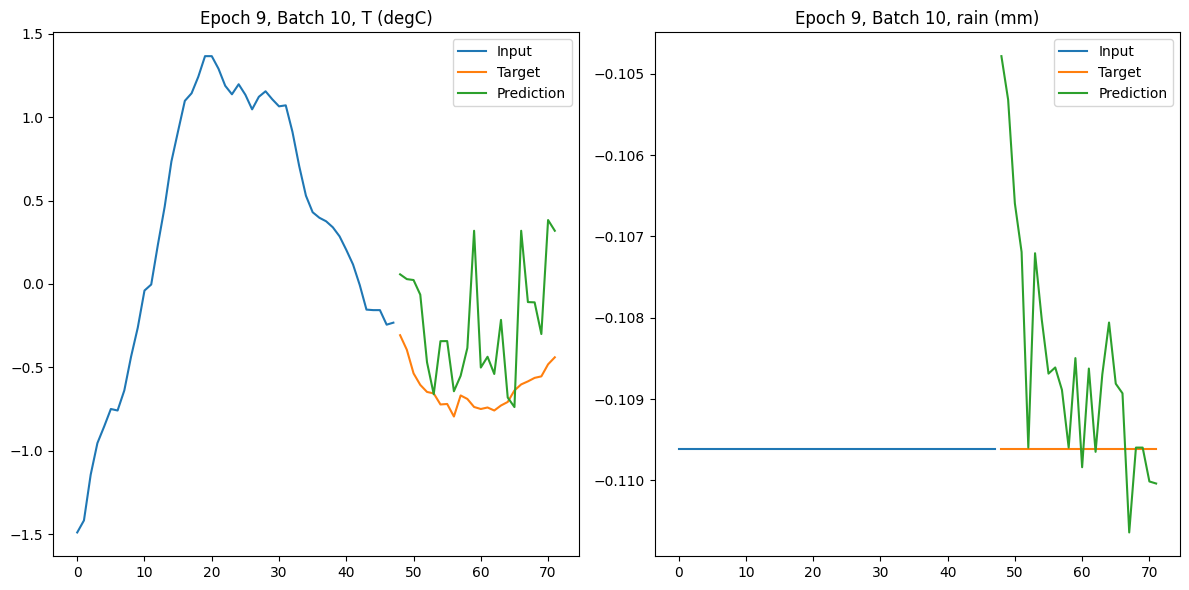

Epoch 9/50, Train Loss: 0.8475
Epoch 9/50, Validation Loss: 1.0444


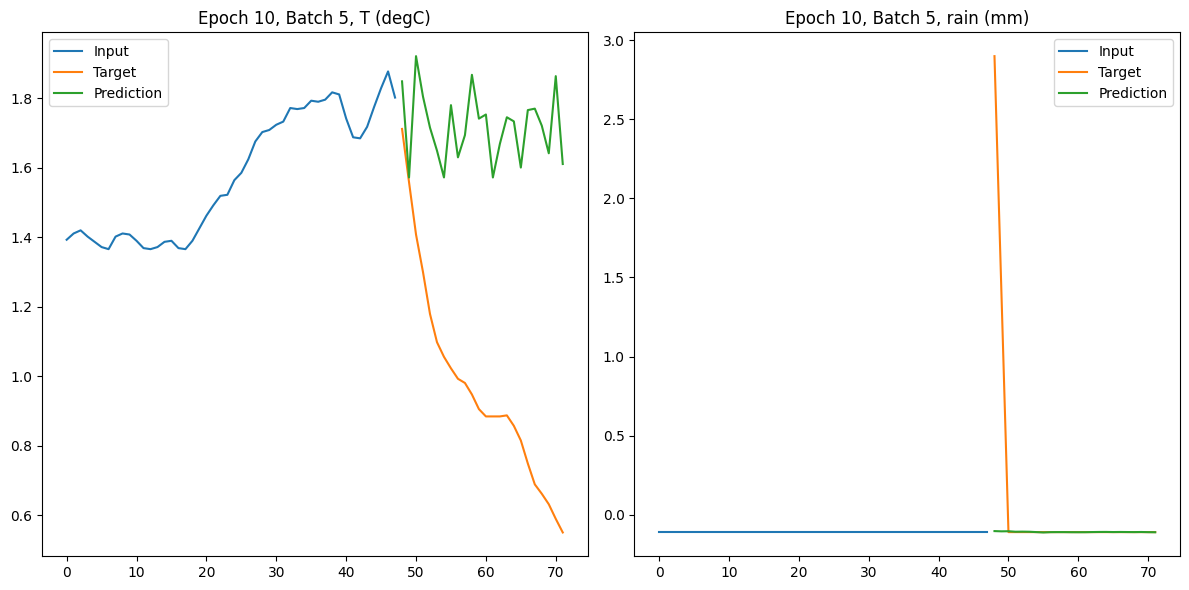

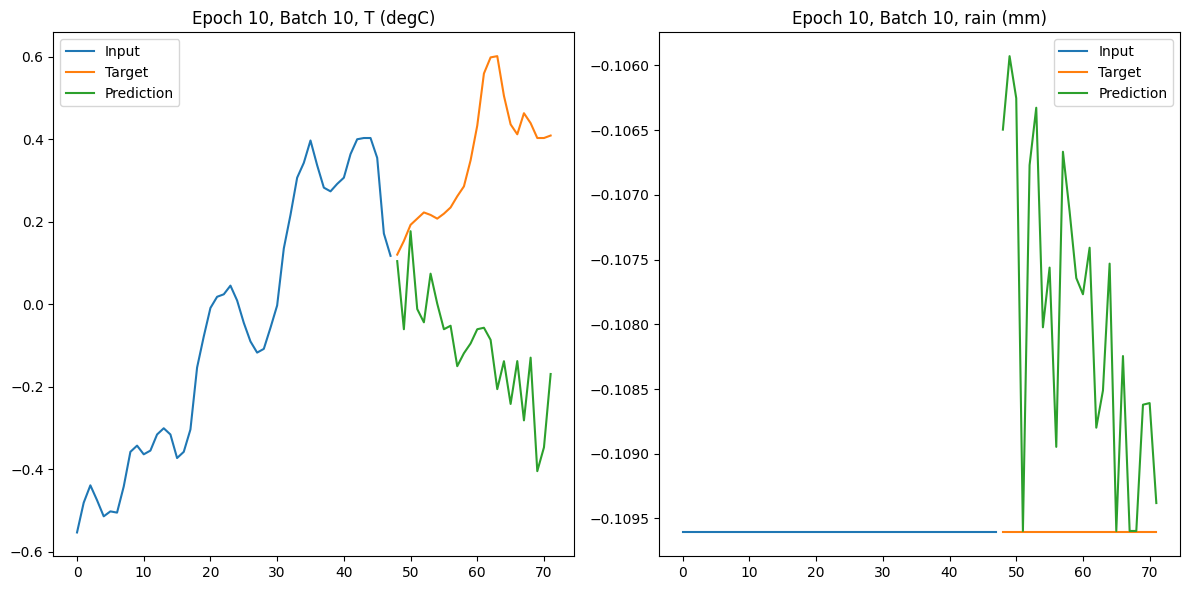

Epoch 10/50, Train Loss: 0.8385
Epoch 10/50, Validation Loss: 1.0159


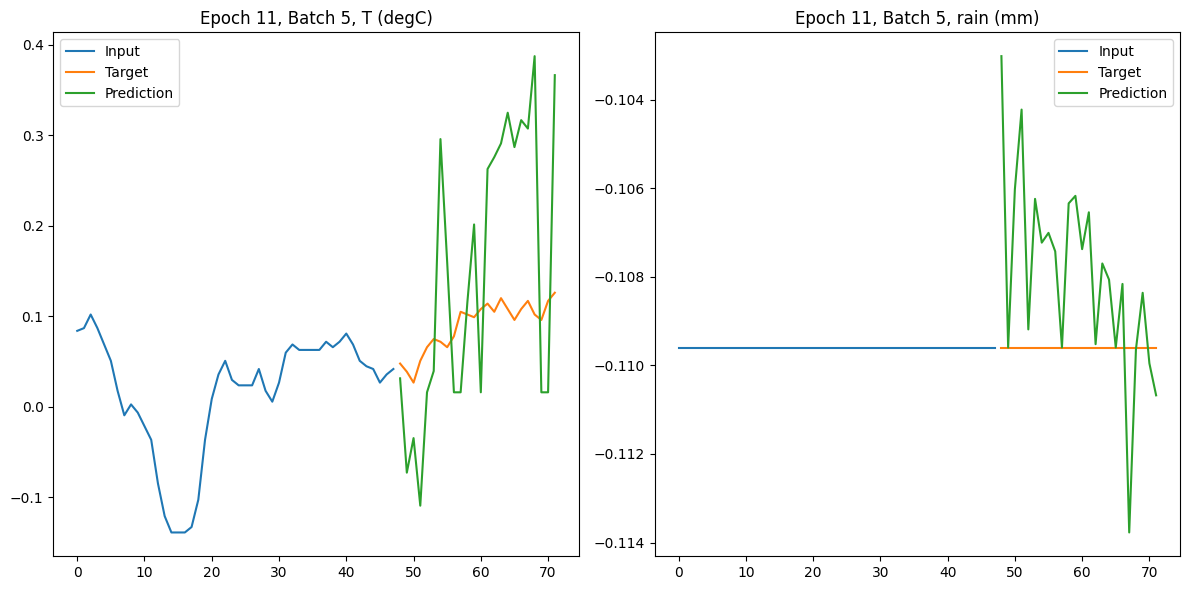

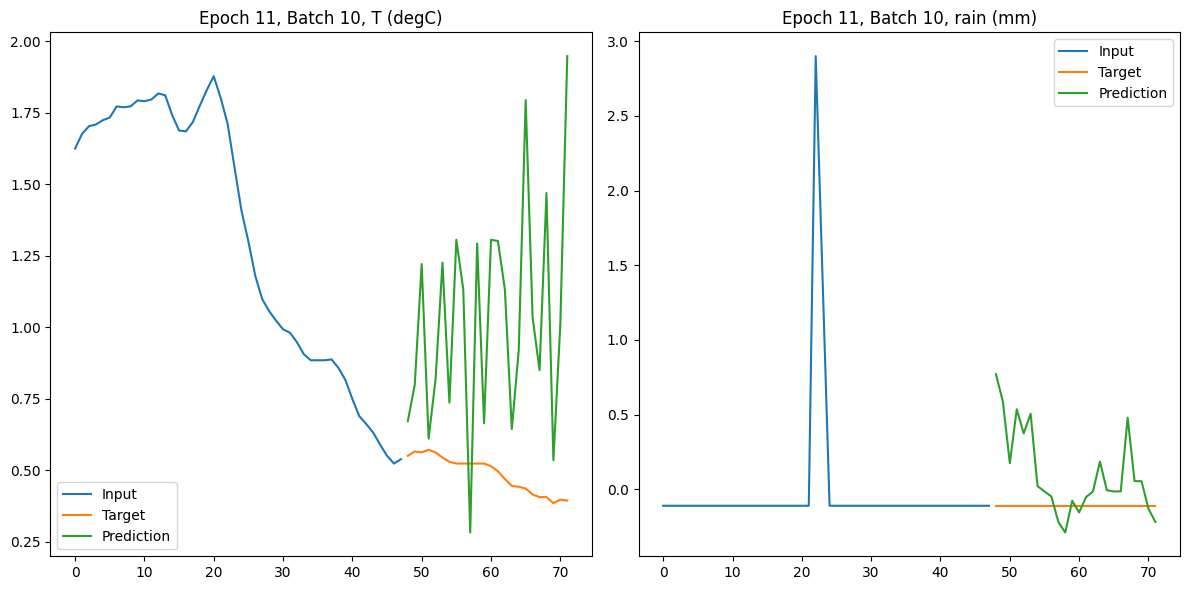

Epoch 11/50, Train Loss: 0.8282
Epoch 11/50, Validation Loss: 1.0036


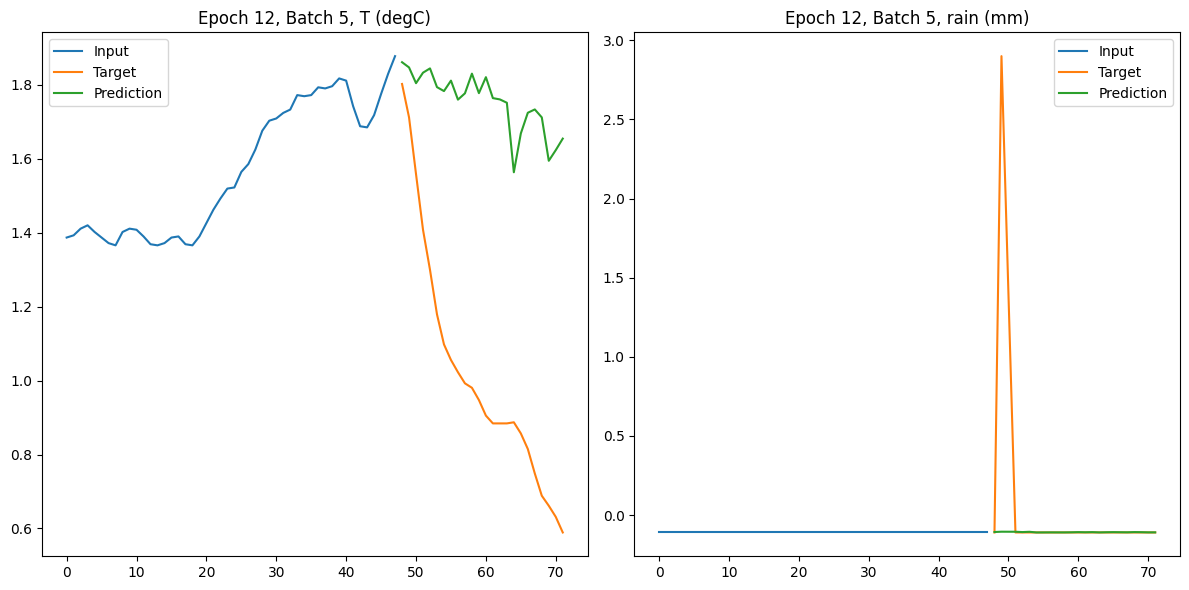

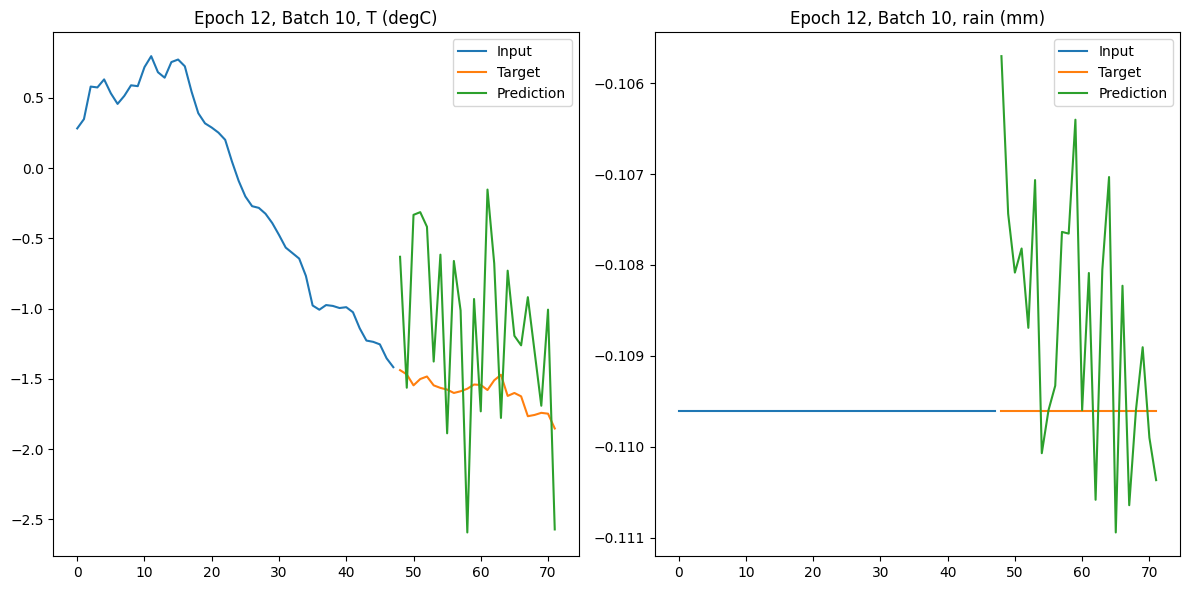

Epoch 12/50, Train Loss: 0.8182
Epoch 12/50, Validation Loss: 0.9897


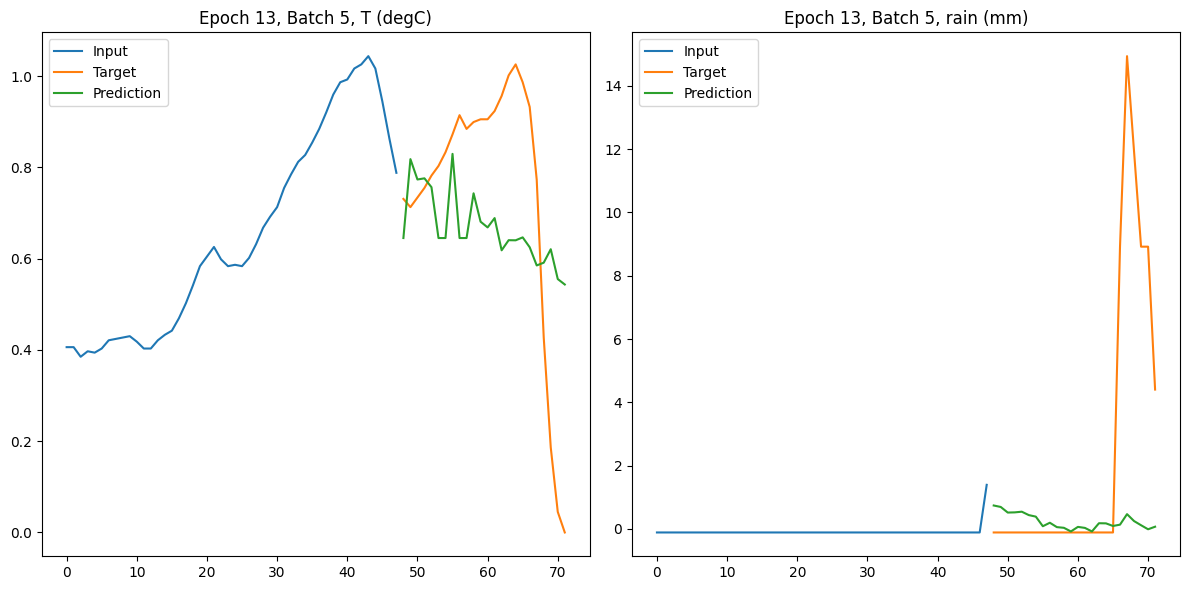

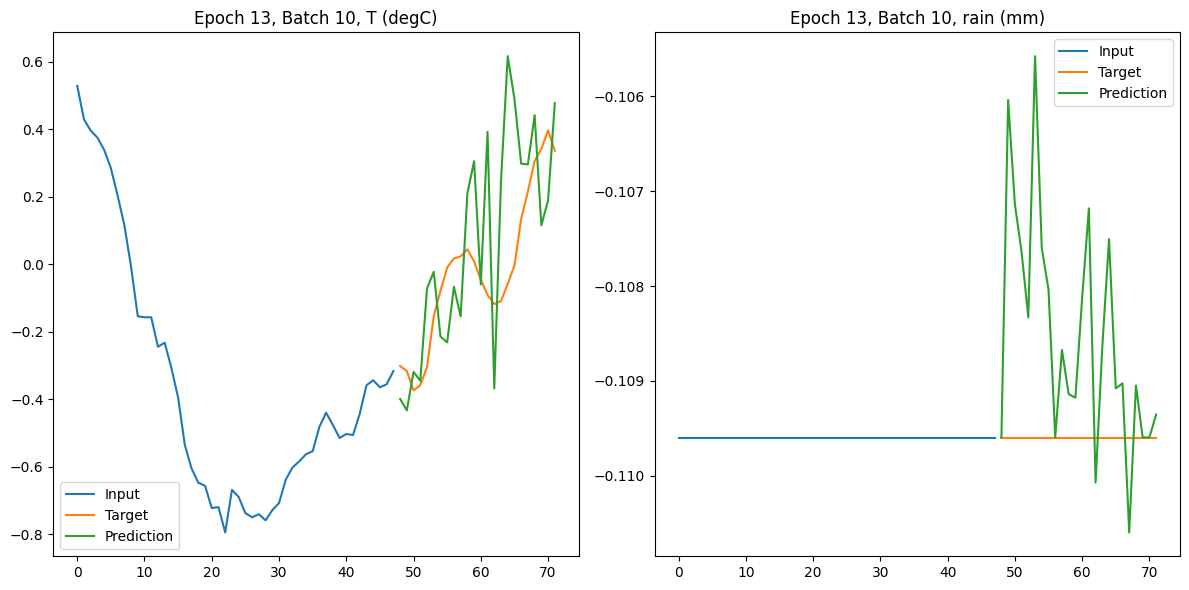

Epoch 13/50, Train Loss: 0.8066
Epoch 13/50, Validation Loss: 0.9704


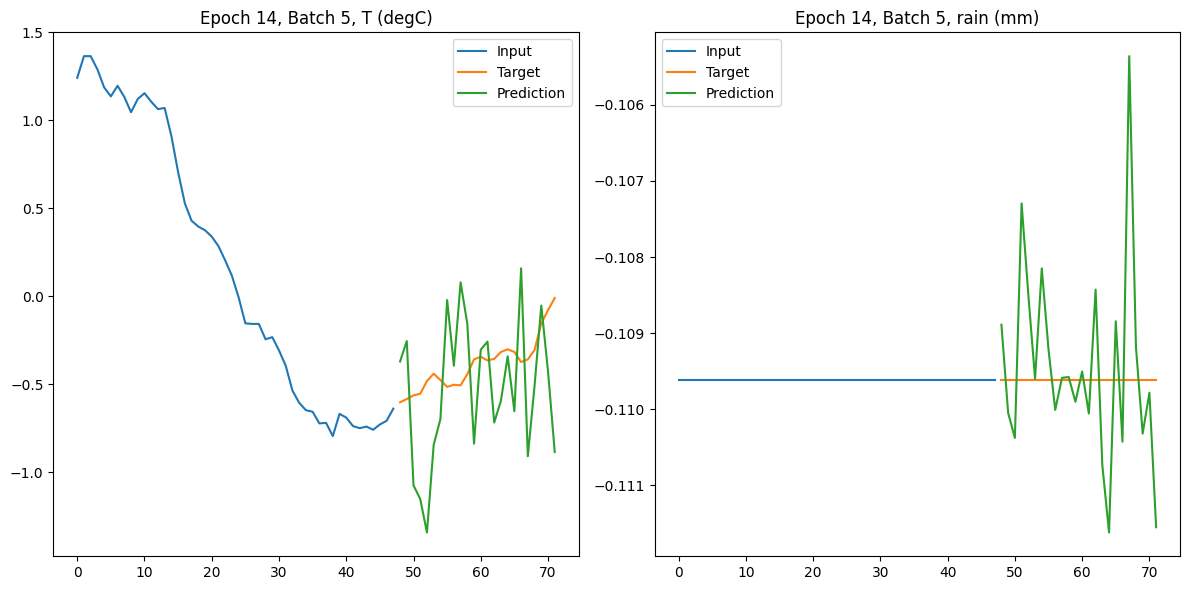

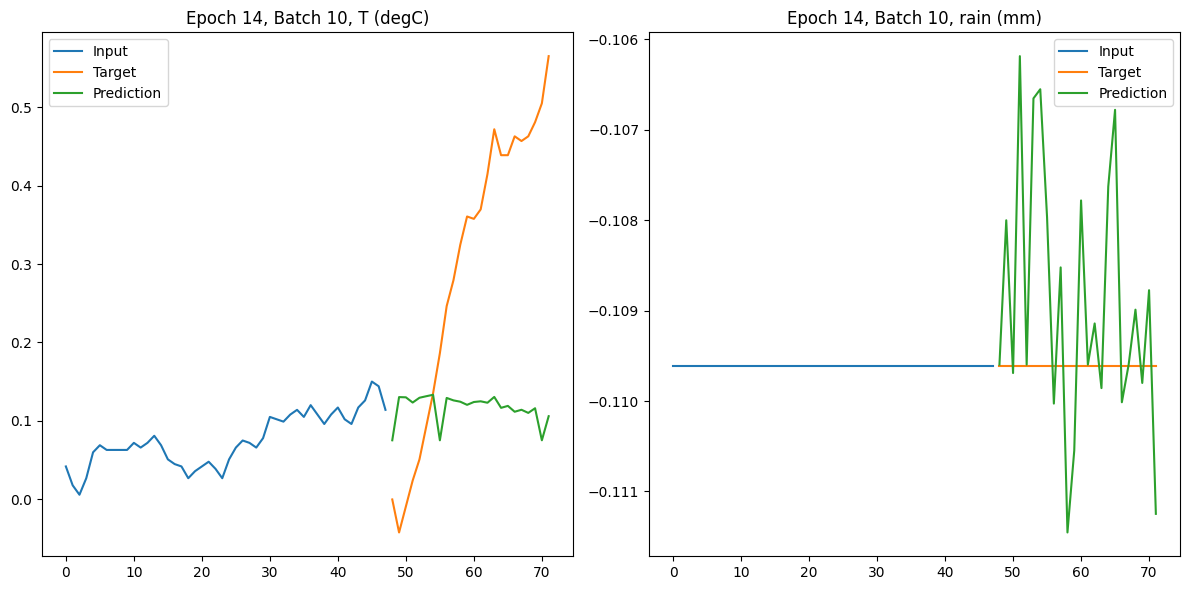

Epoch 14/50, Train Loss: 0.7975
Epoch 14/50, Validation Loss: 0.9531


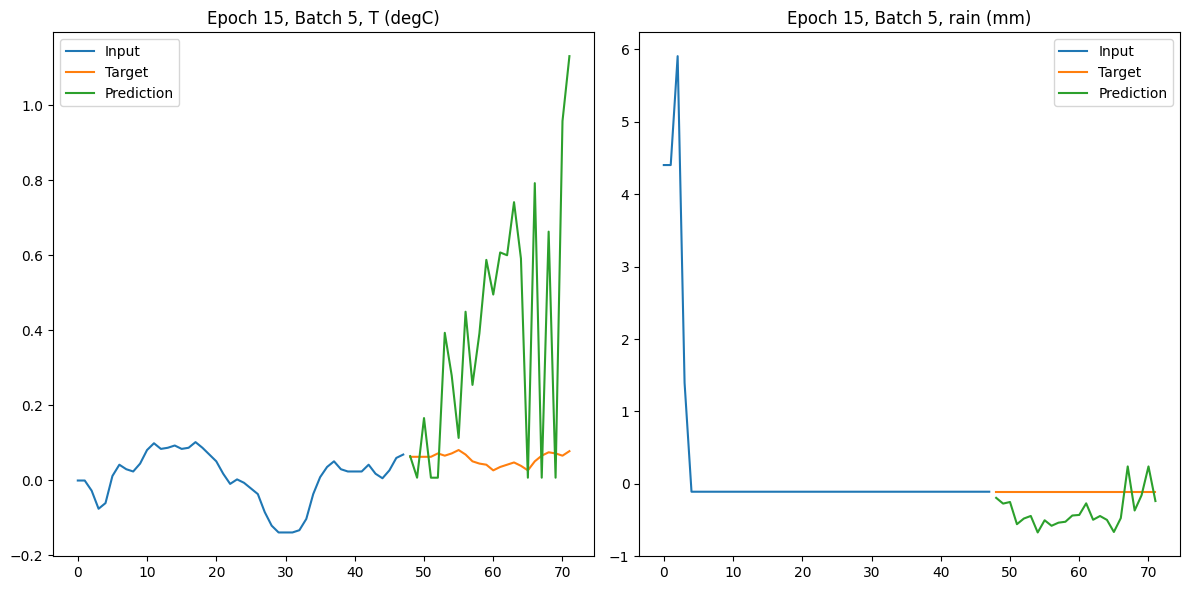

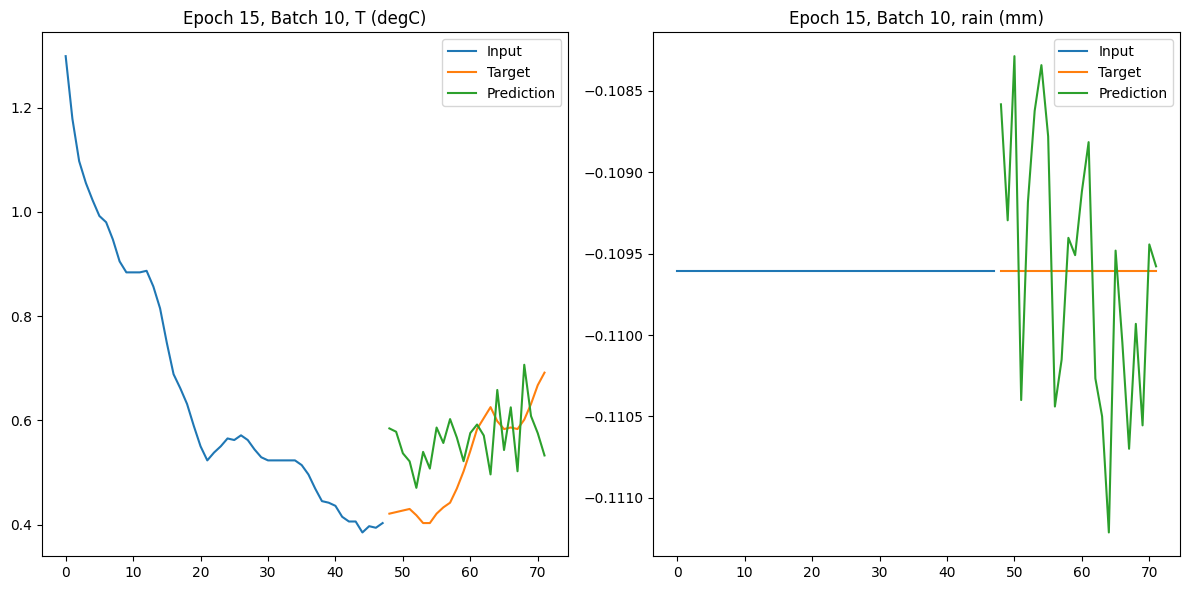

Epoch 15/50, Train Loss: 0.7928
Epoch 15/50, Validation Loss: 0.9404


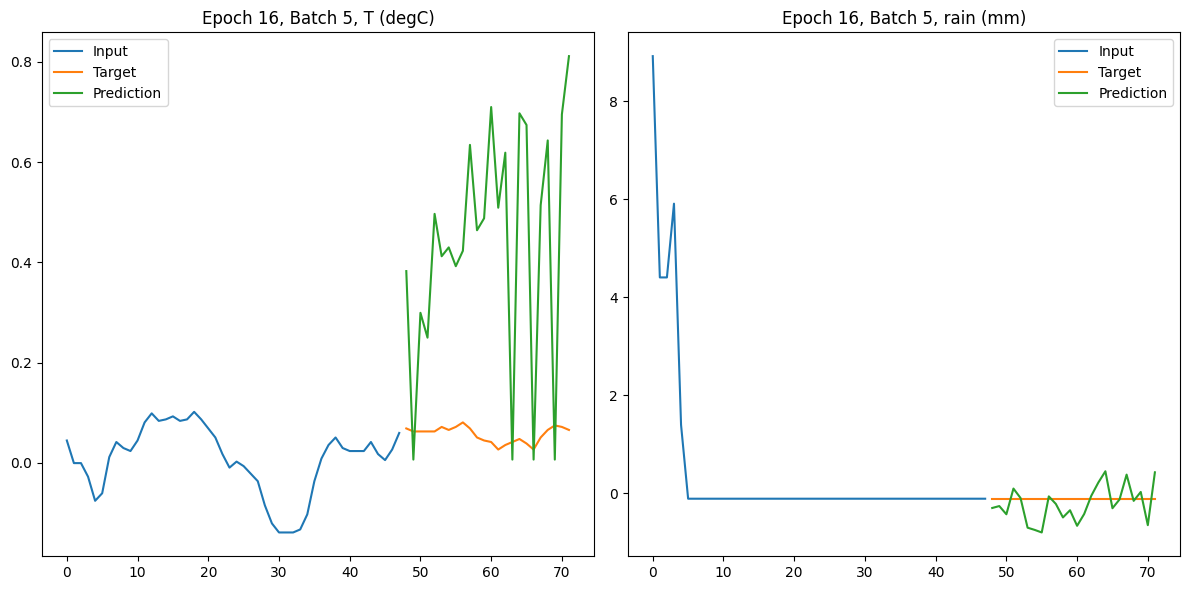

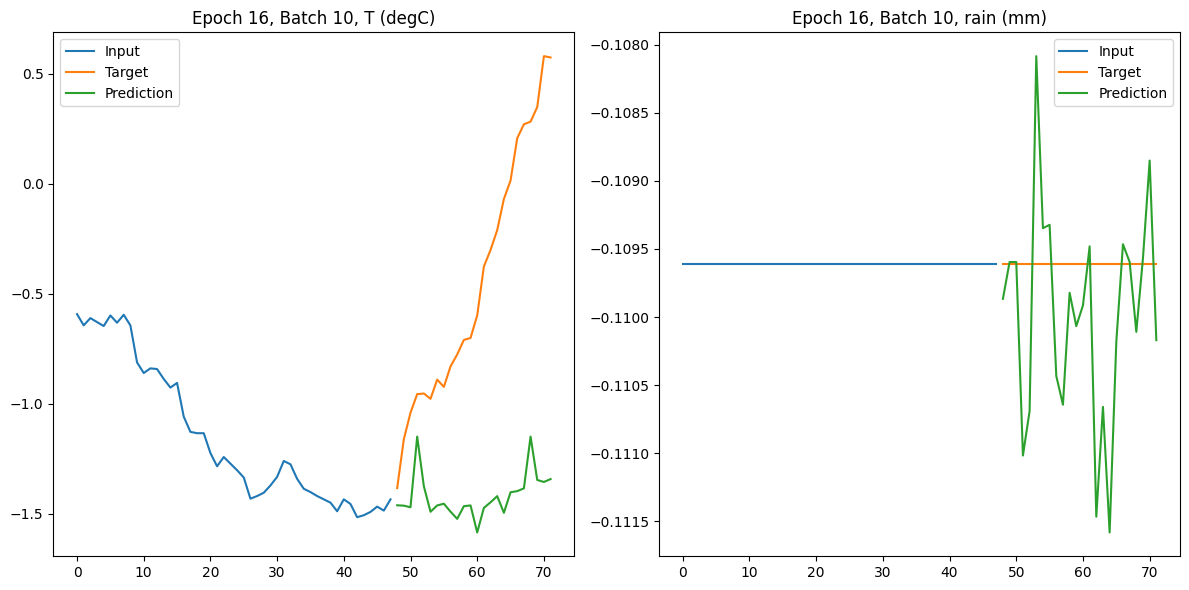

Epoch 16/50, Train Loss: 0.7870
Epoch 16/50, Validation Loss: 0.9242


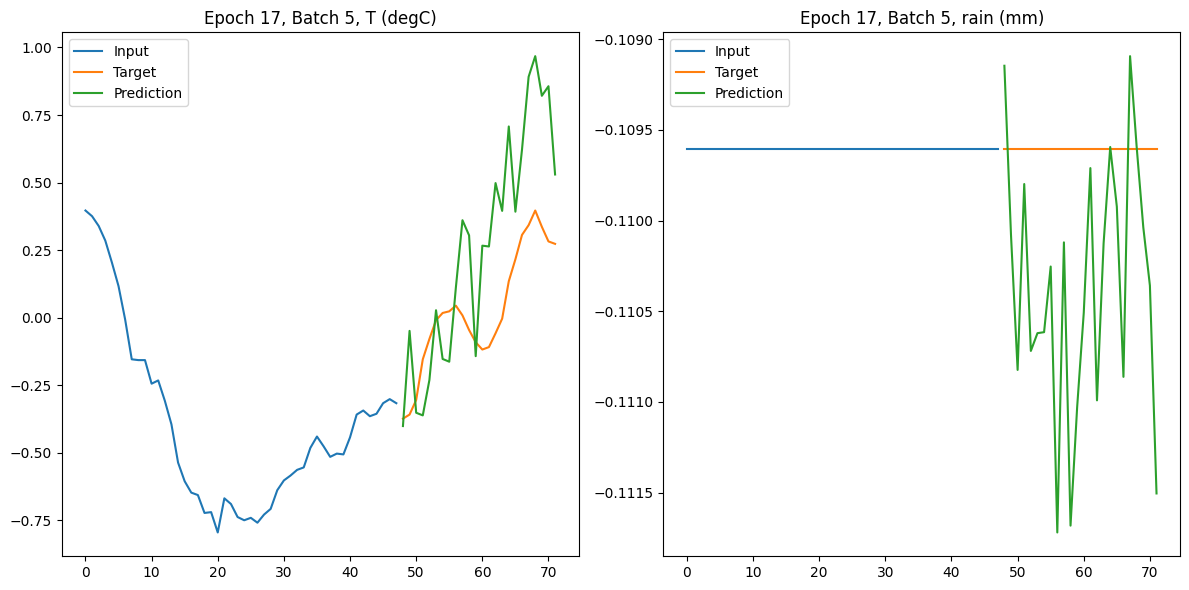

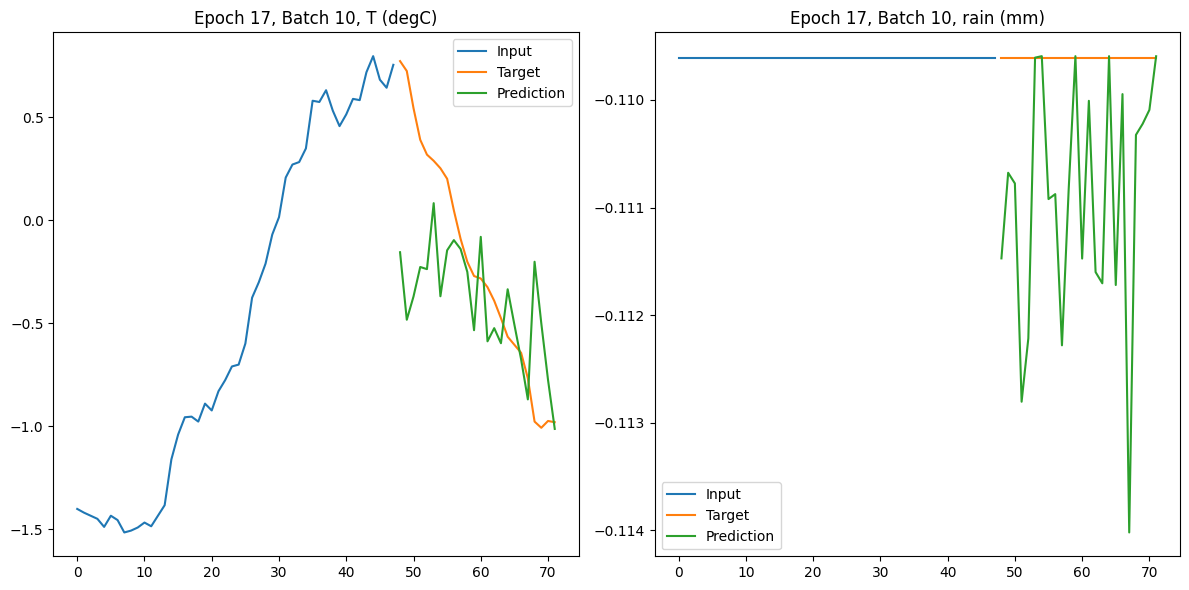

Epoch 17/50, Train Loss: 0.7812
Epoch 17/50, Validation Loss: 0.9119


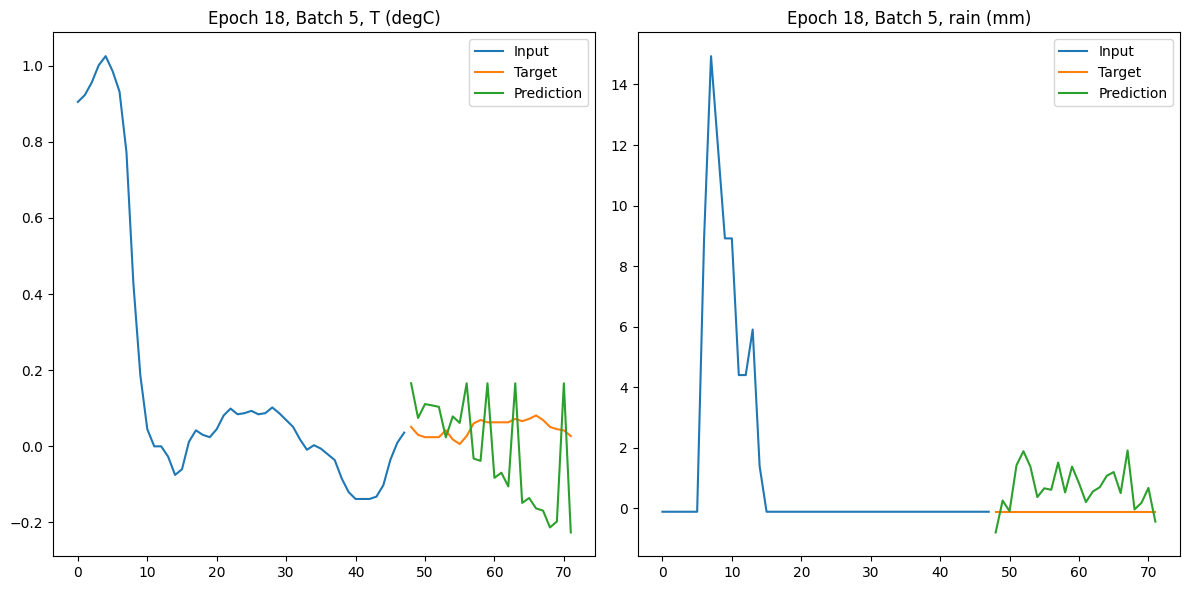

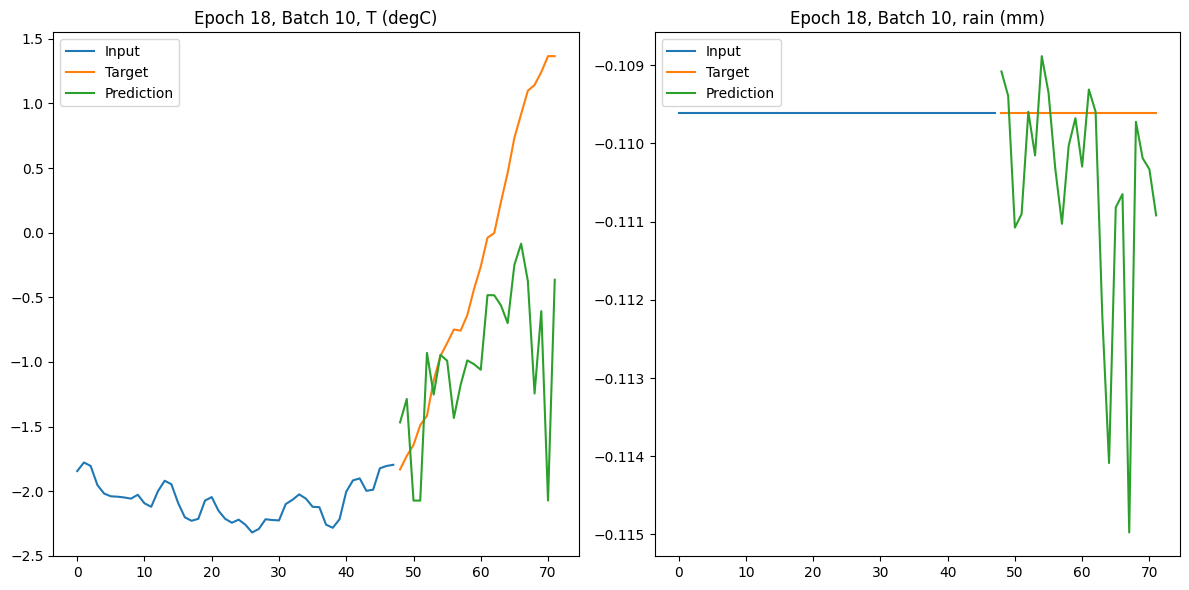

Epoch 18/50, Train Loss: 0.7743
Epoch 18/50, Validation Loss: 0.8958


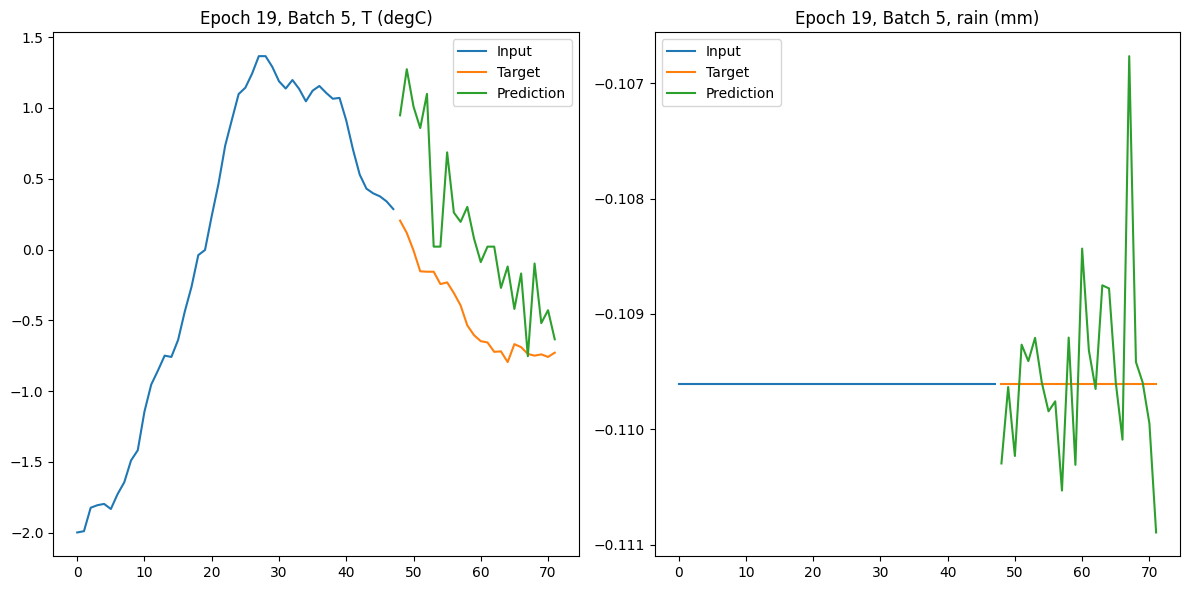

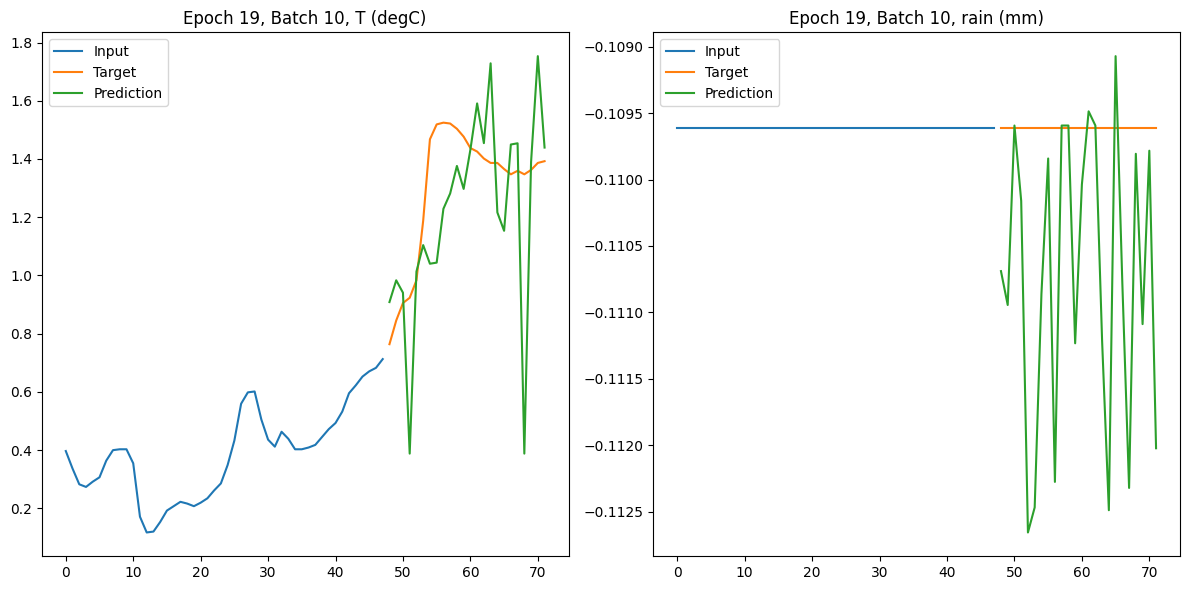

Epoch 19/50, Train Loss: 0.7681
Epoch 19/50, Validation Loss: 0.8942


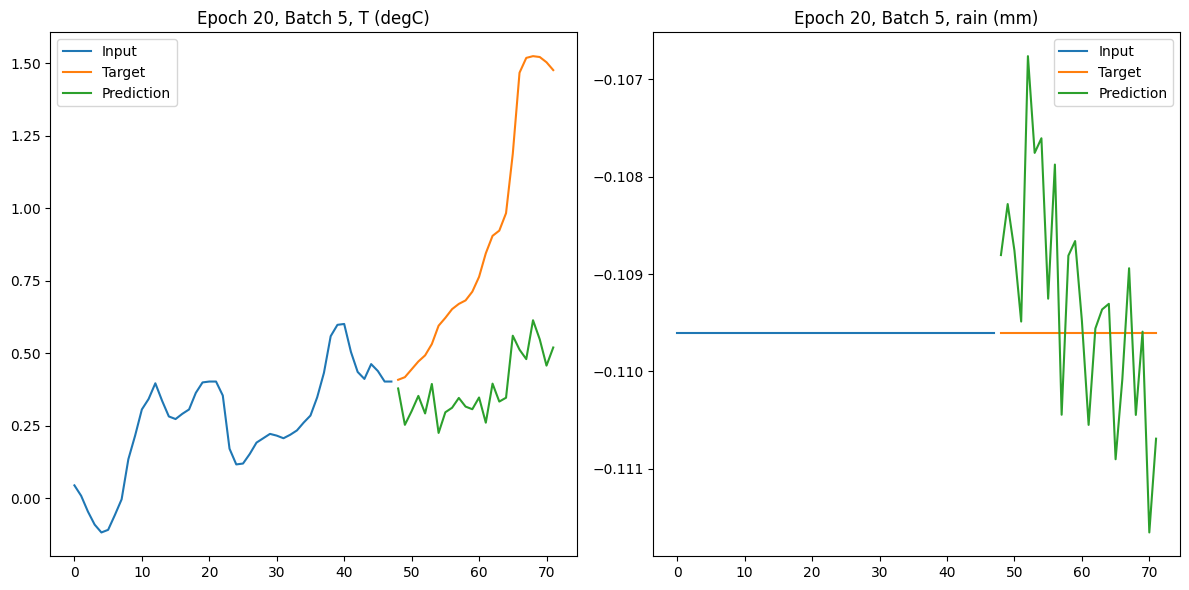

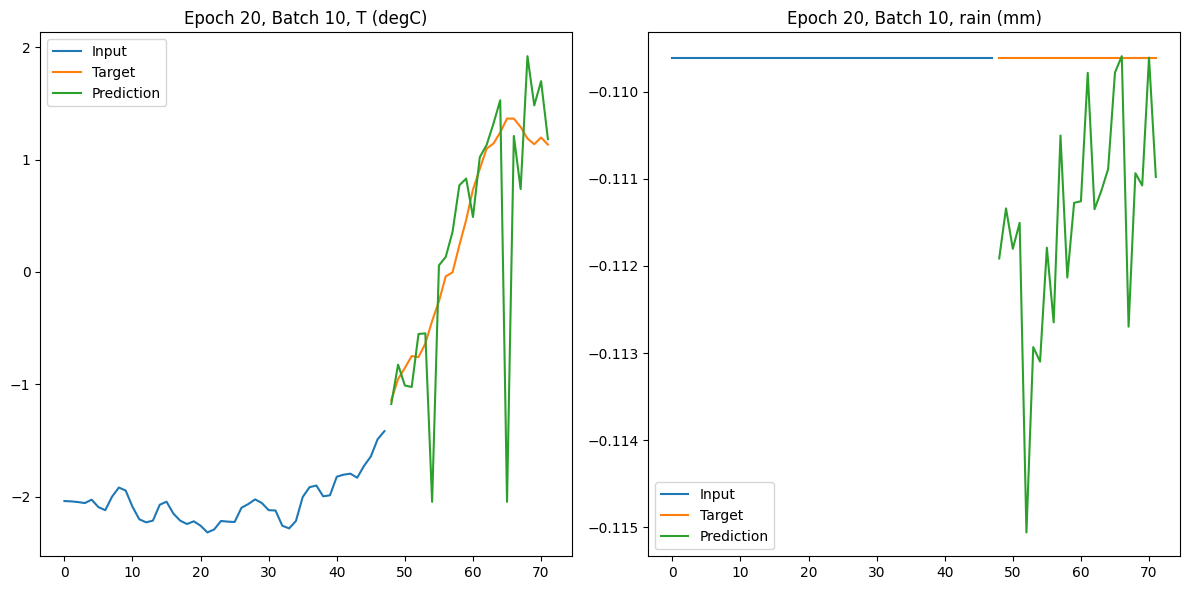

Epoch 20/50, Train Loss: 0.7640
Epoch 20/50, Validation Loss: 0.8915


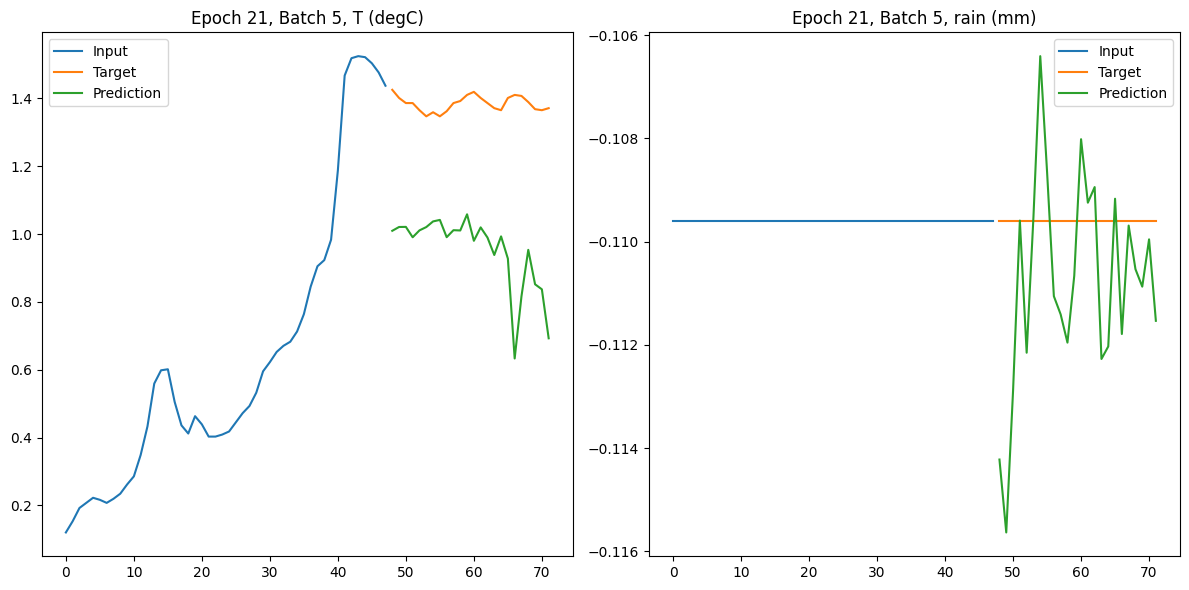

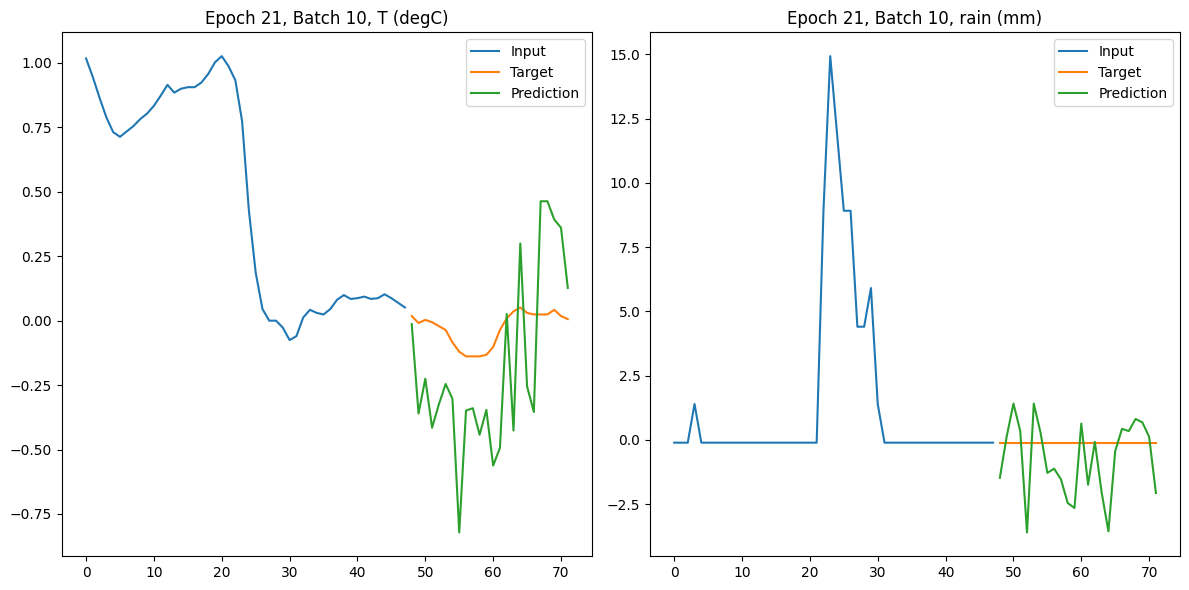

Epoch 21/50, Train Loss: 0.7578
Epoch 21/50, Validation Loss: 0.8895


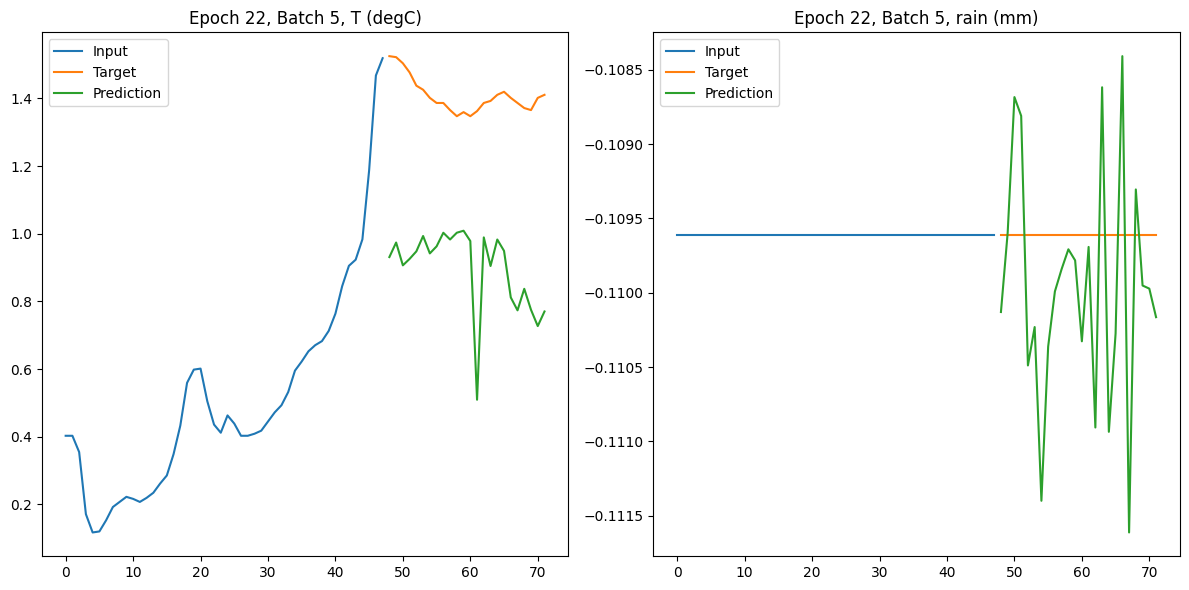

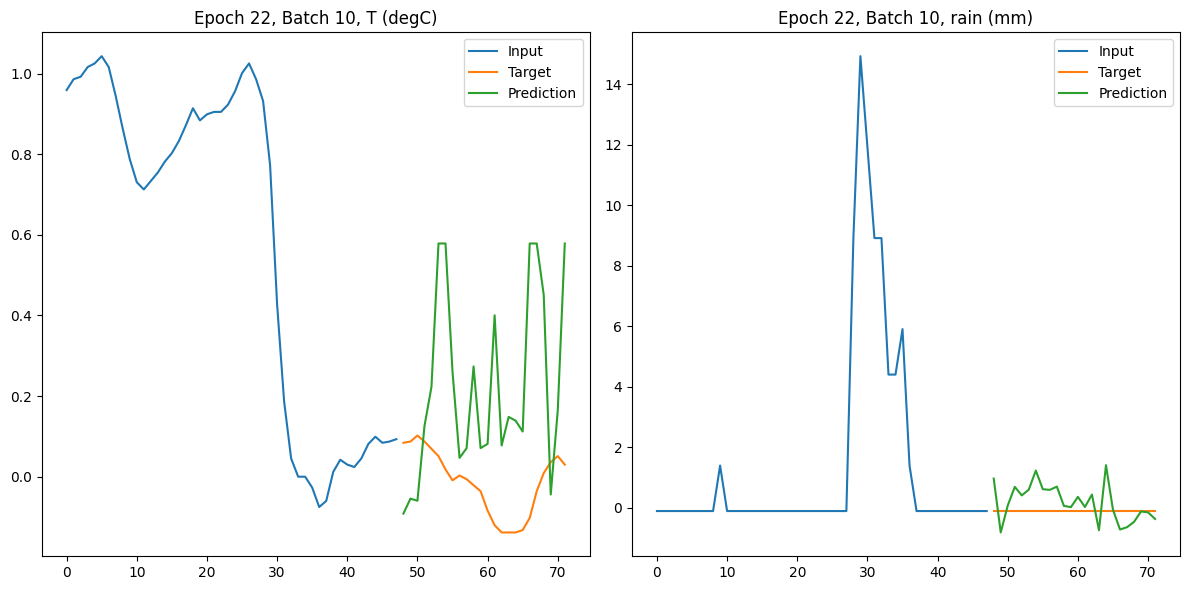

Epoch 22/50, Train Loss: 0.7519
Epoch 22/50, Validation Loss: 0.8841


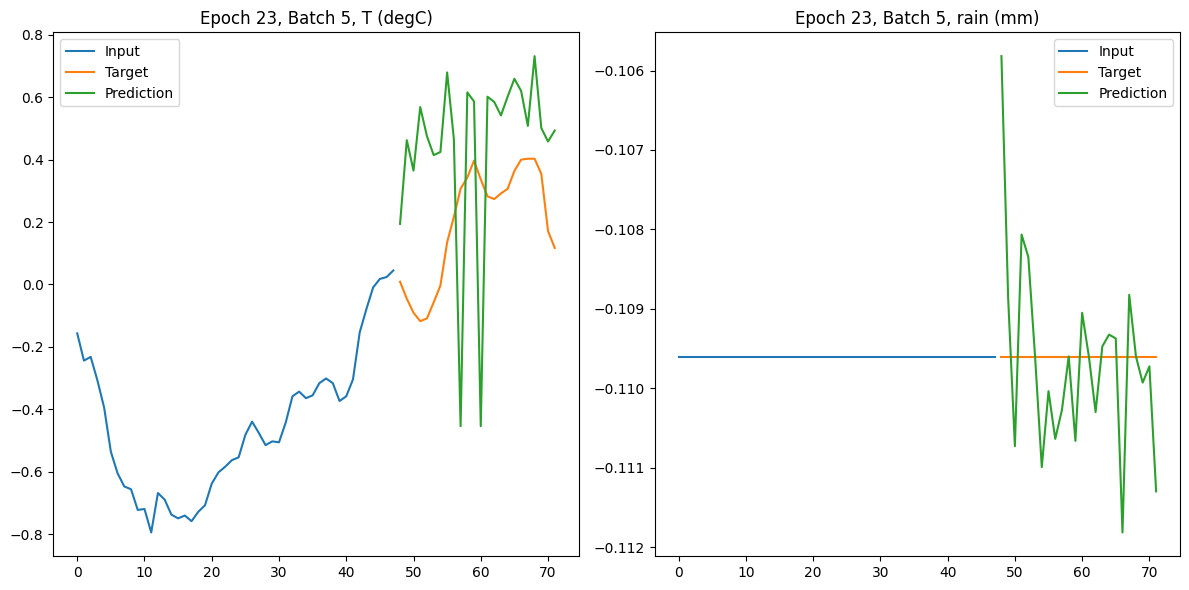

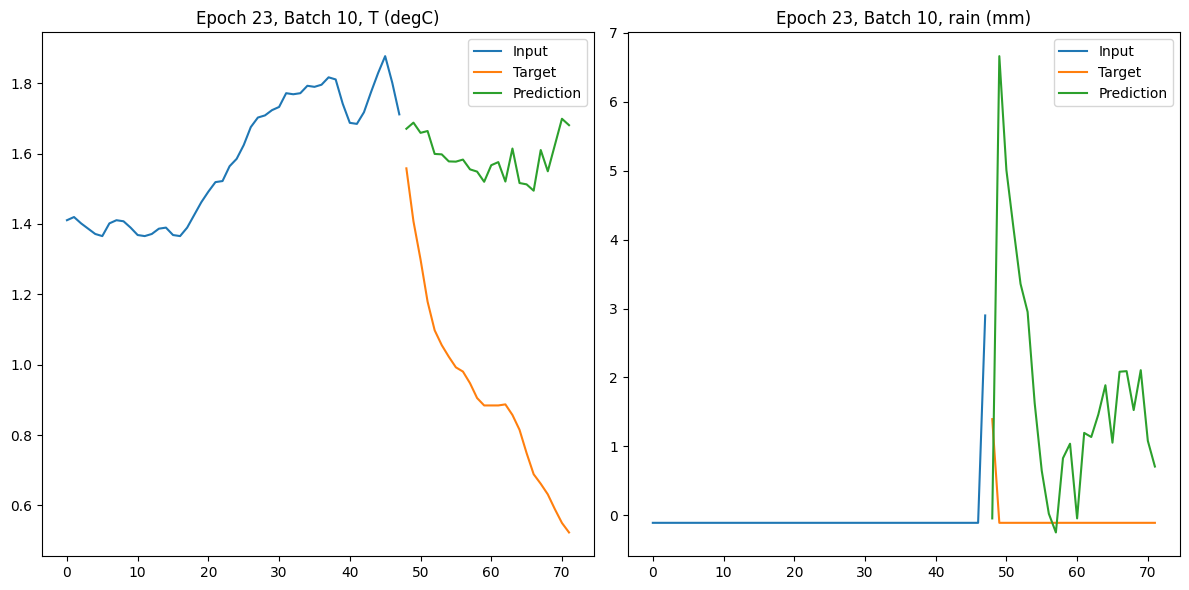

Epoch 23/50, Train Loss: 0.7431
Epoch 23/50, Validation Loss: 0.8809


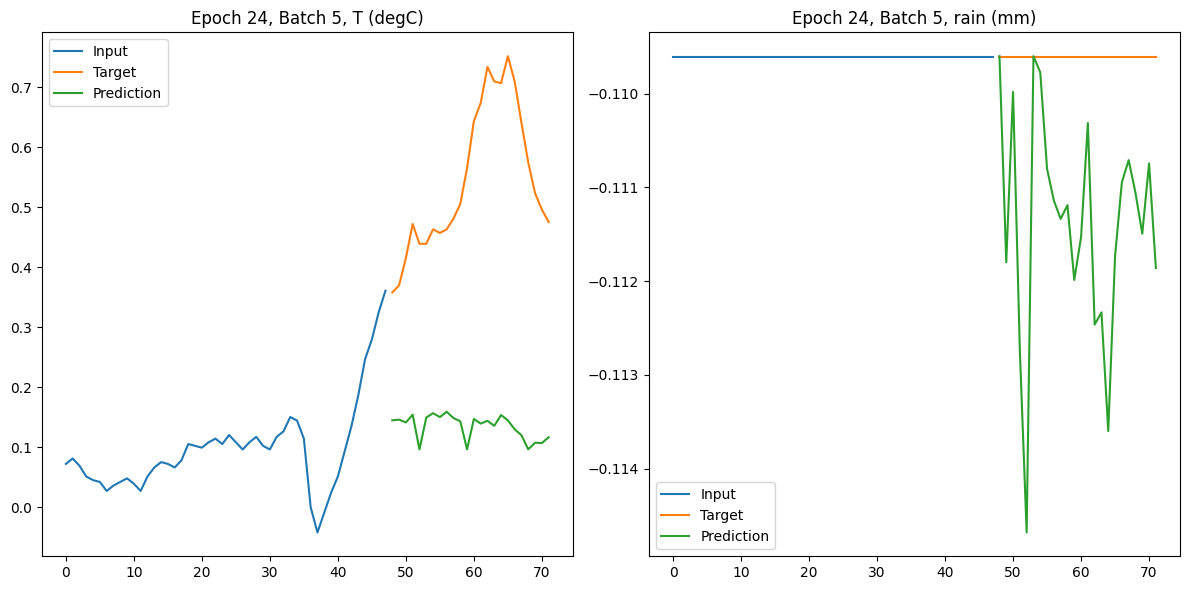

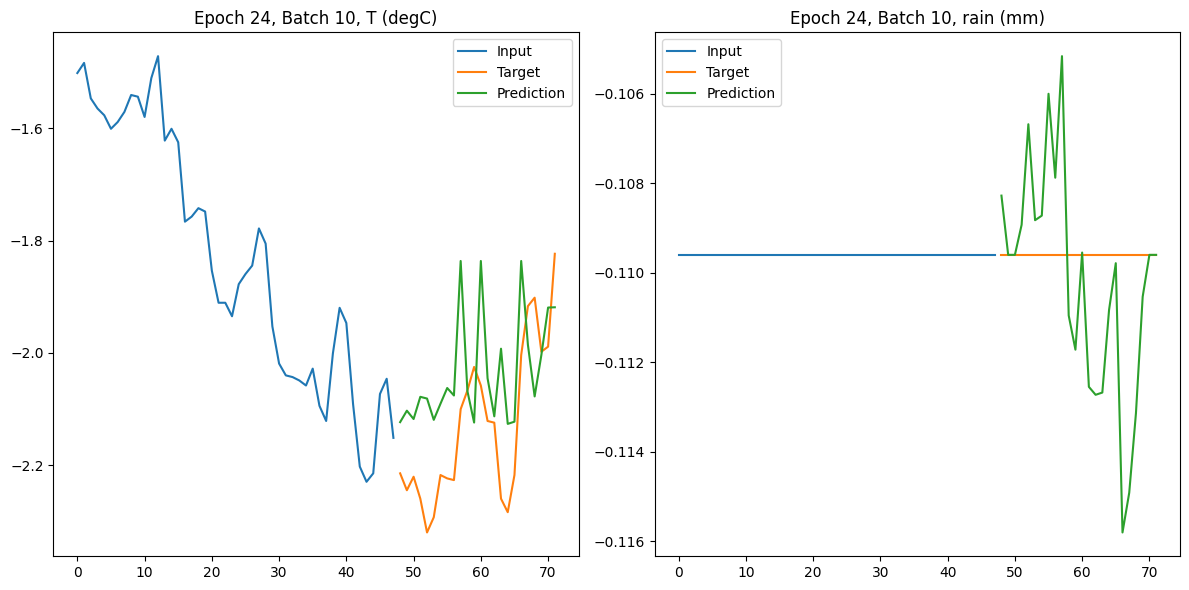

Epoch 24/50, Train Loss: 0.7360
Epoch 24/50, Validation Loss: 0.9013


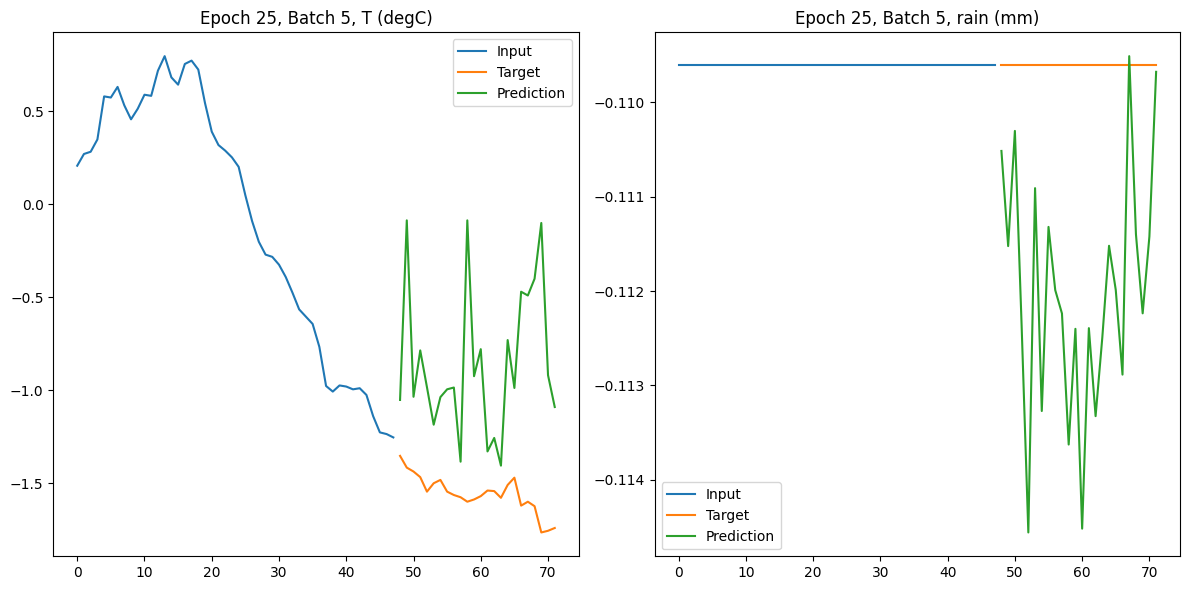

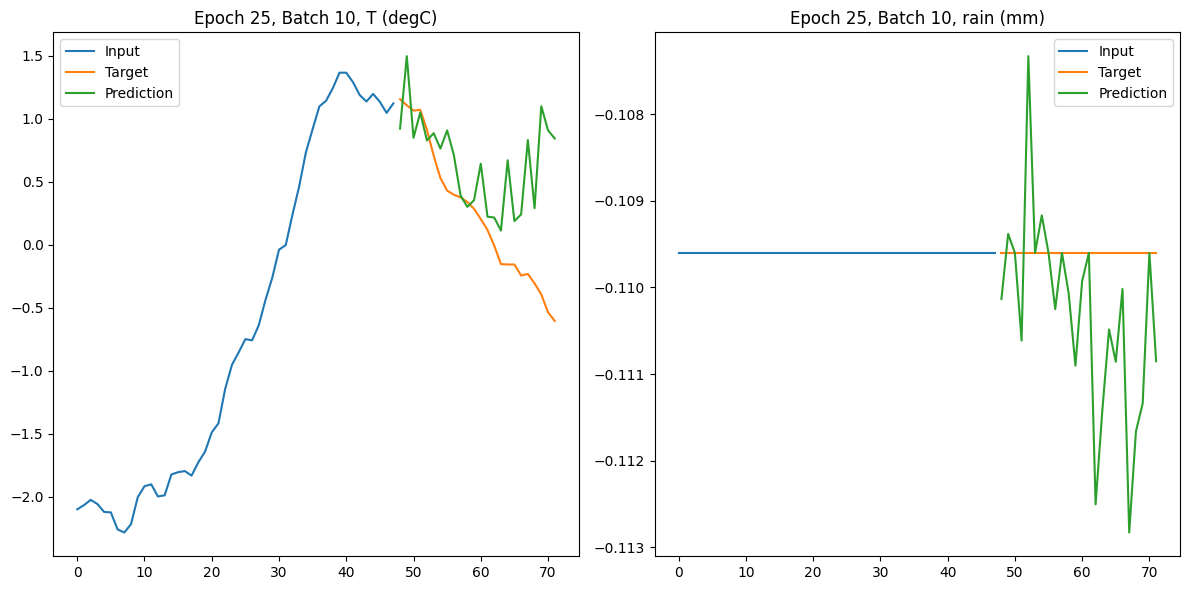

Epoch 25/50, Train Loss: 0.7342
Epoch 25/50, Validation Loss: 0.9036


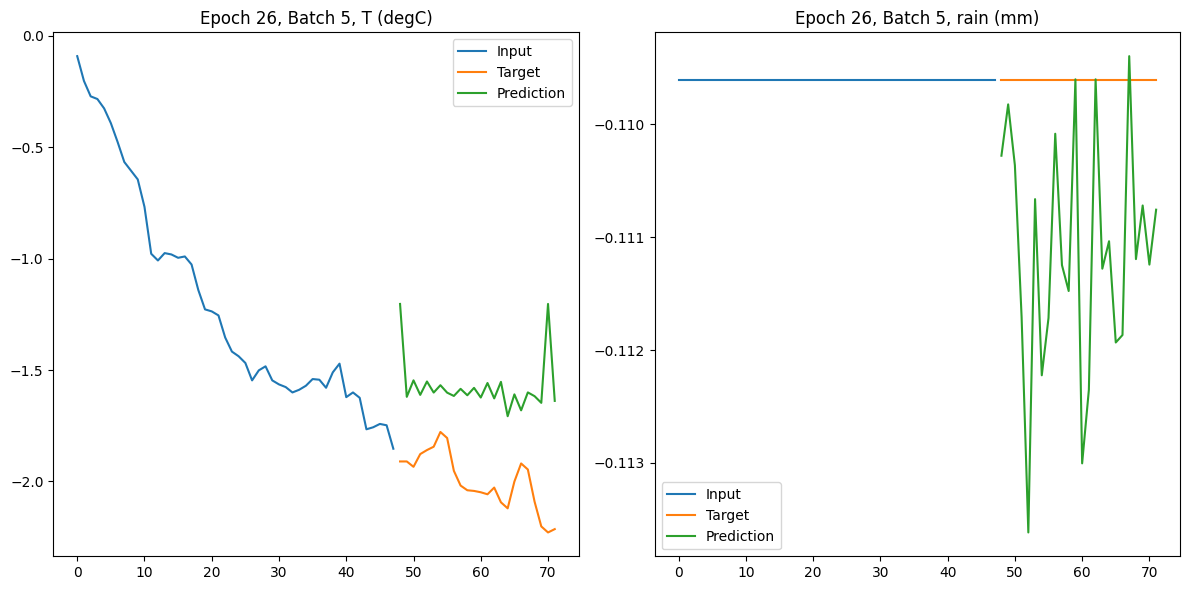

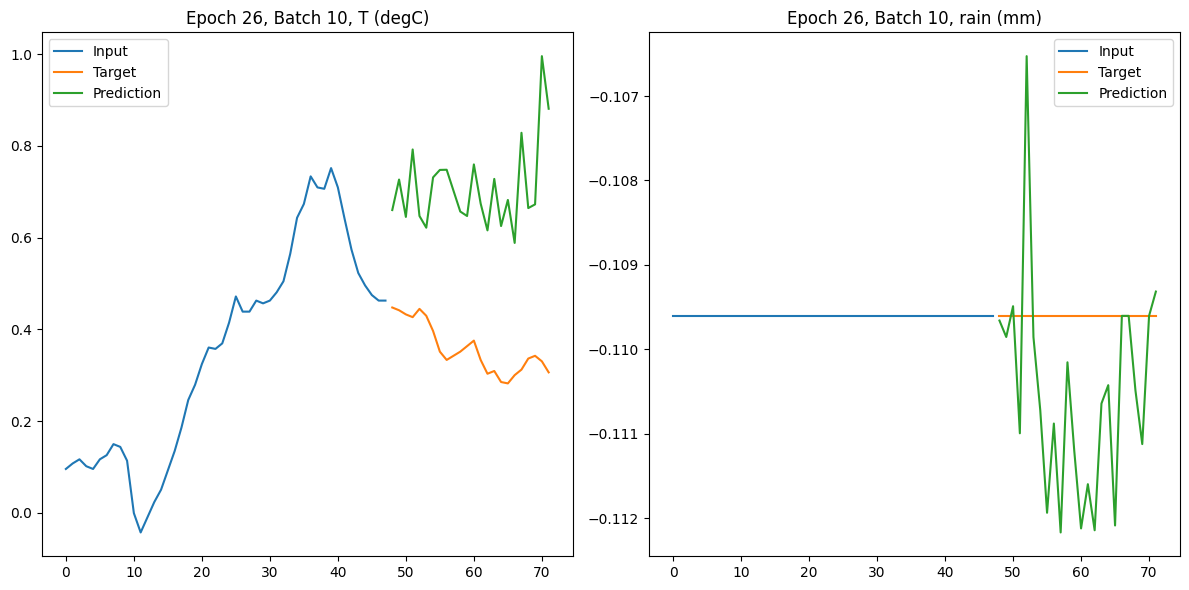

Epoch 26/50, Train Loss: 0.7280
Epoch 26/50, Validation Loss: 0.8959


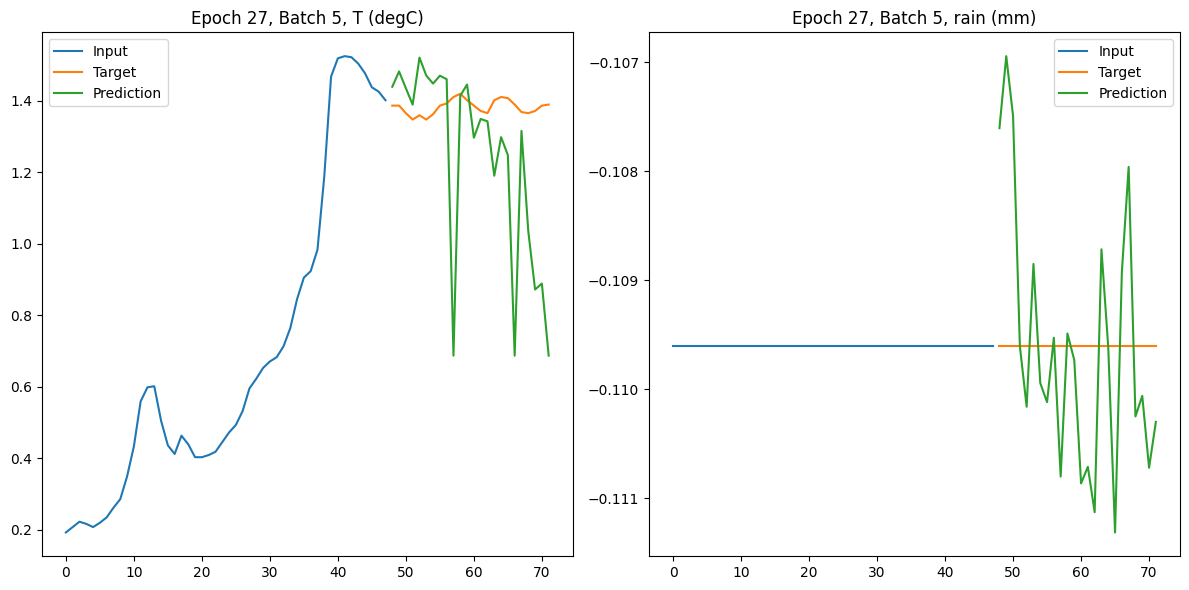

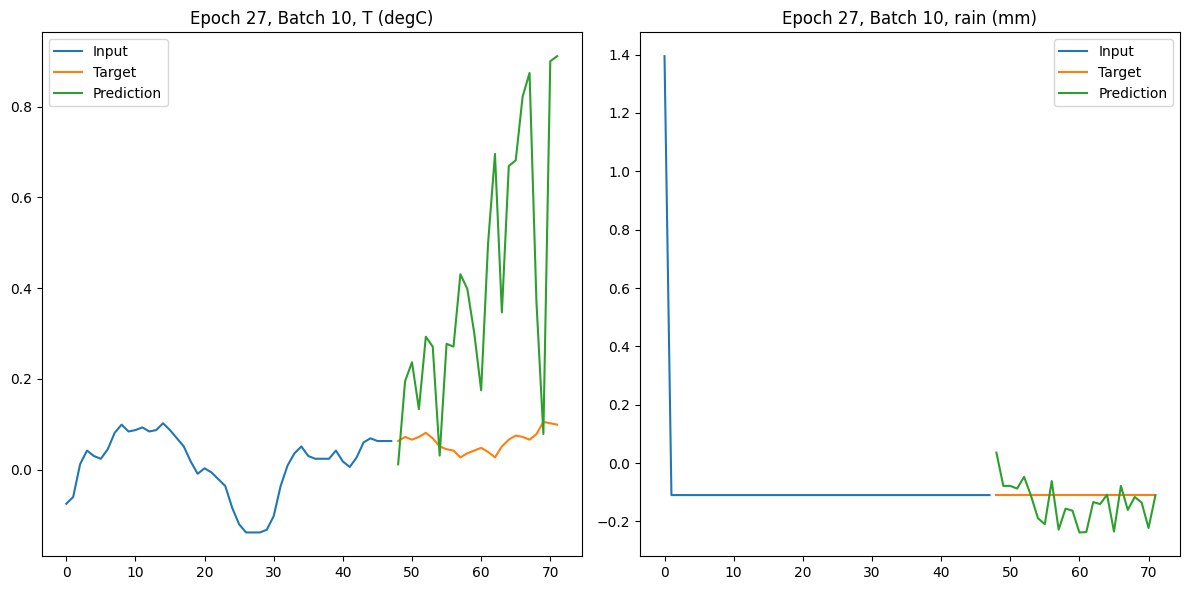

Epoch 27/50, Train Loss: 0.7200
Epoch 27/50, Validation Loss: 0.8937


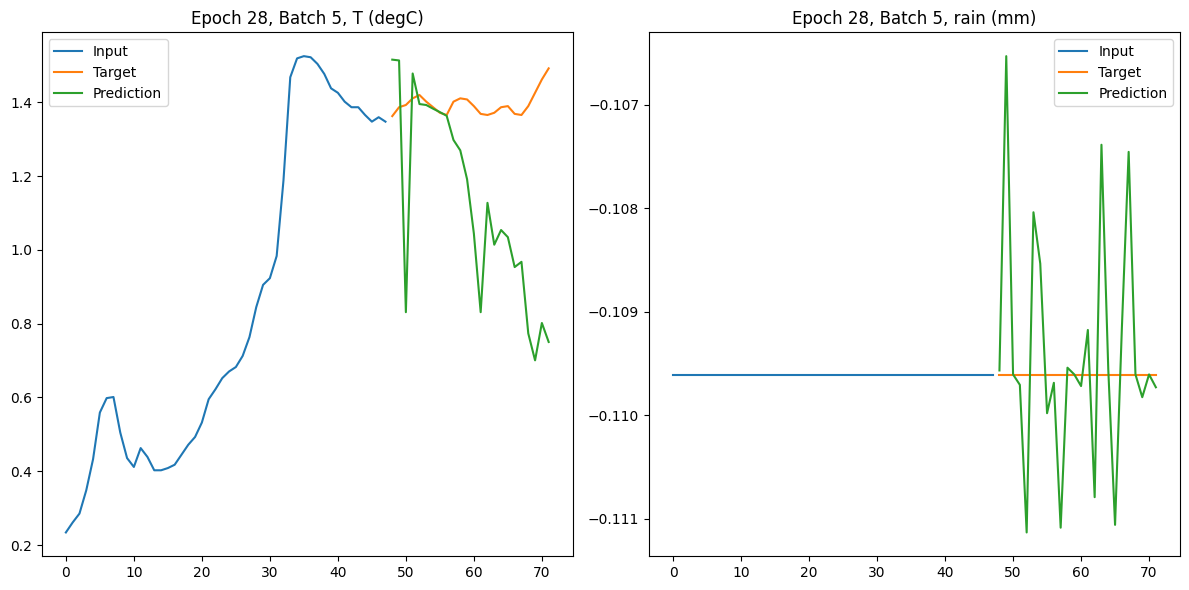

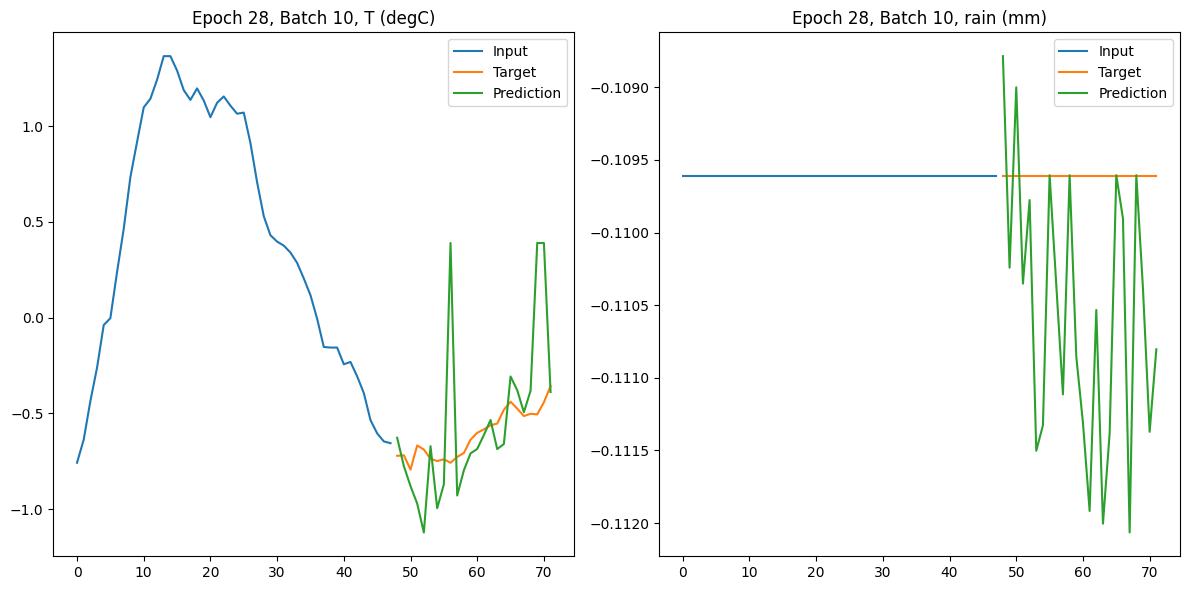

Epoch 28/50, Train Loss: 0.7126
Epoch 28/50, Validation Loss: 0.8926


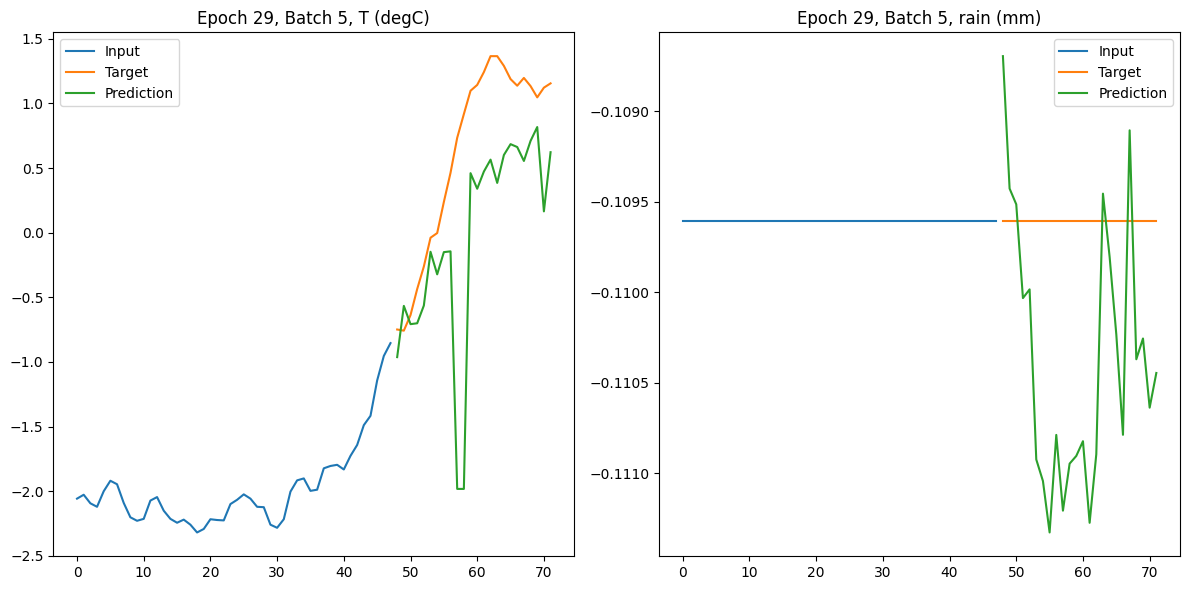

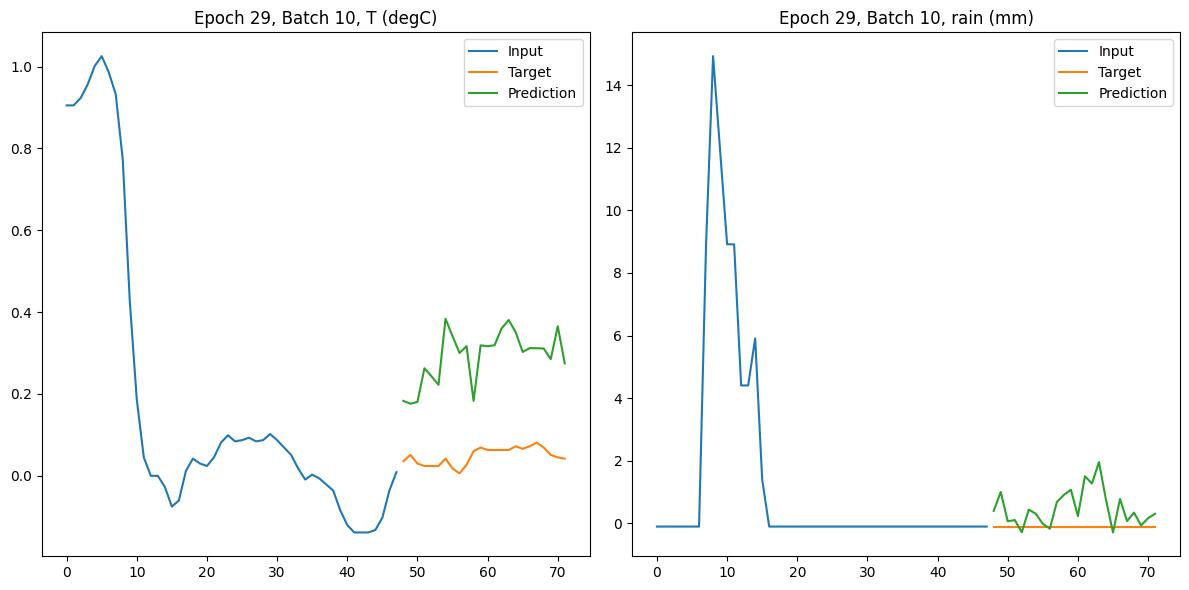

Epoch 29/50, Train Loss: 0.7035
Epoch 29/50, Validation Loss: 0.8919


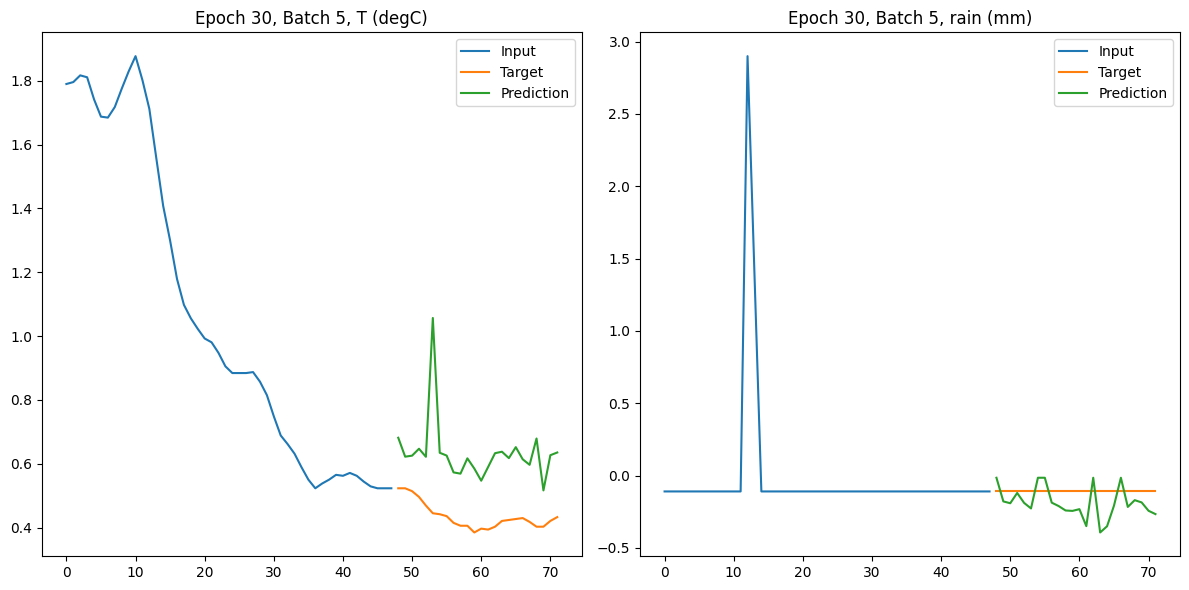

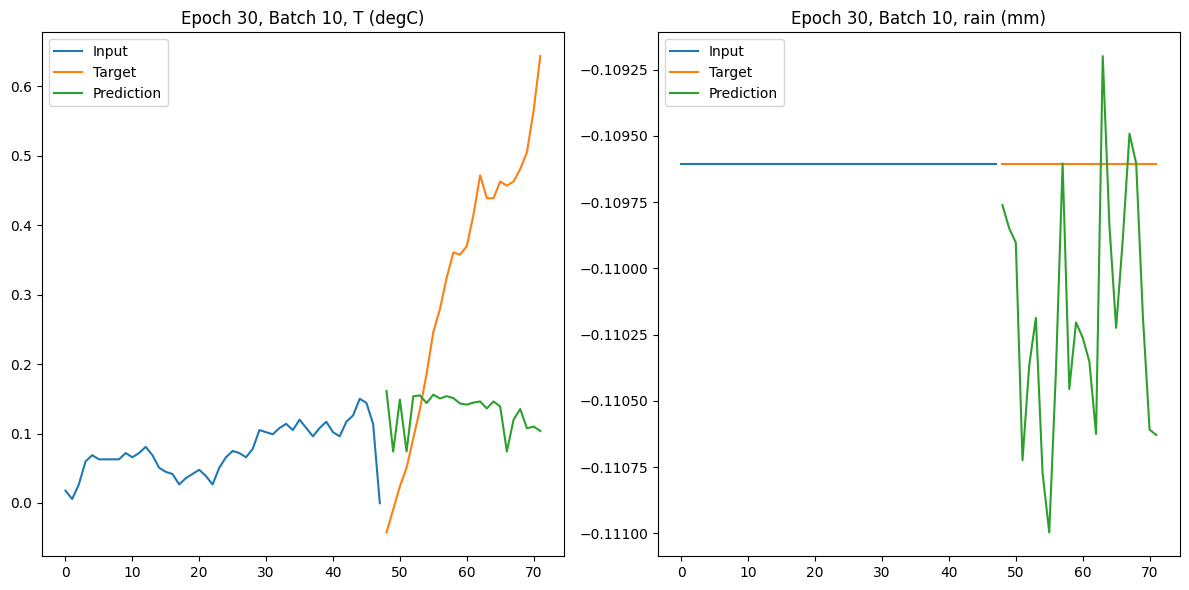

Epoch 30/50, Train Loss: 0.6939
Epoch 30/50, Validation Loss: 0.8906


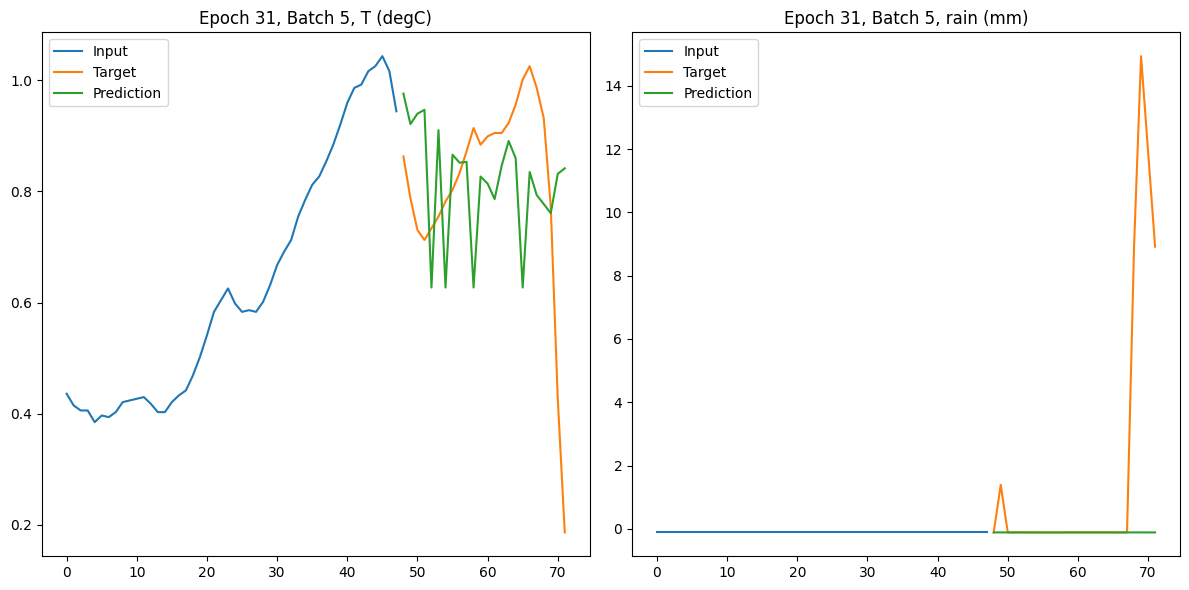

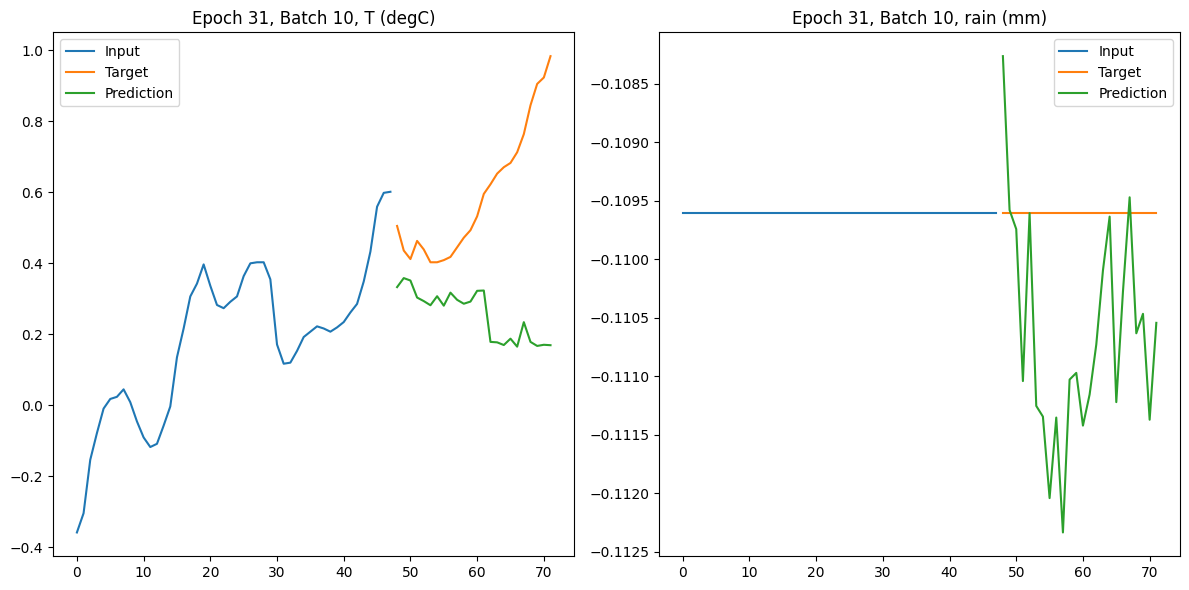

Epoch 31/50, Train Loss: 0.6843
Epoch 31/50, Validation Loss: 0.8895


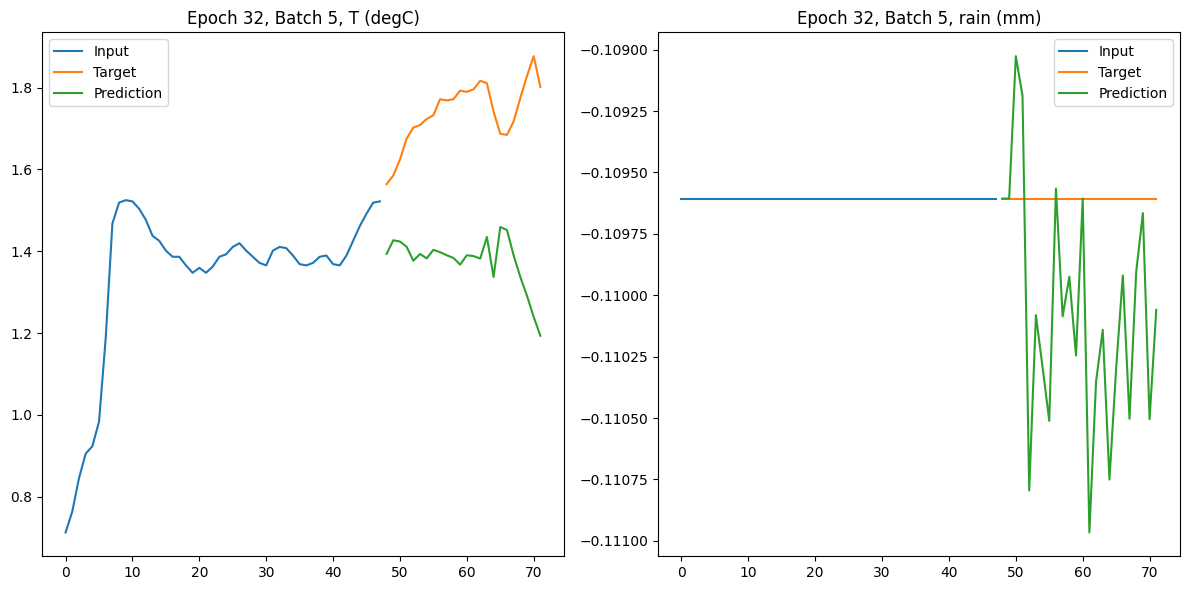

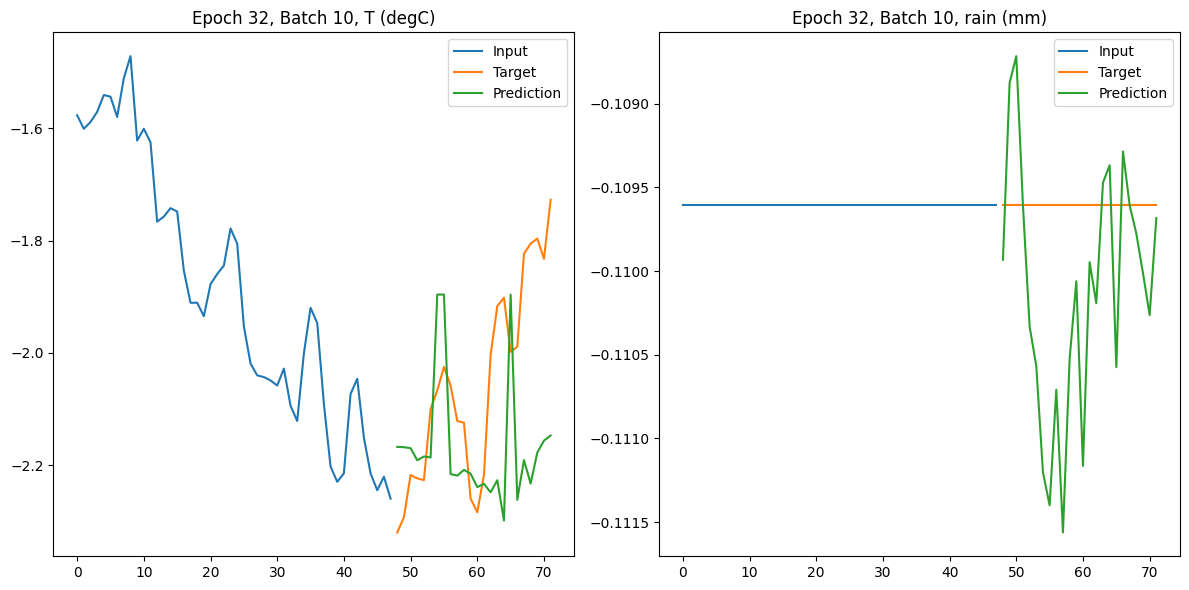

Epoch 32/50, Train Loss: 0.6762
Epoch 32/50, Validation Loss: 0.8849


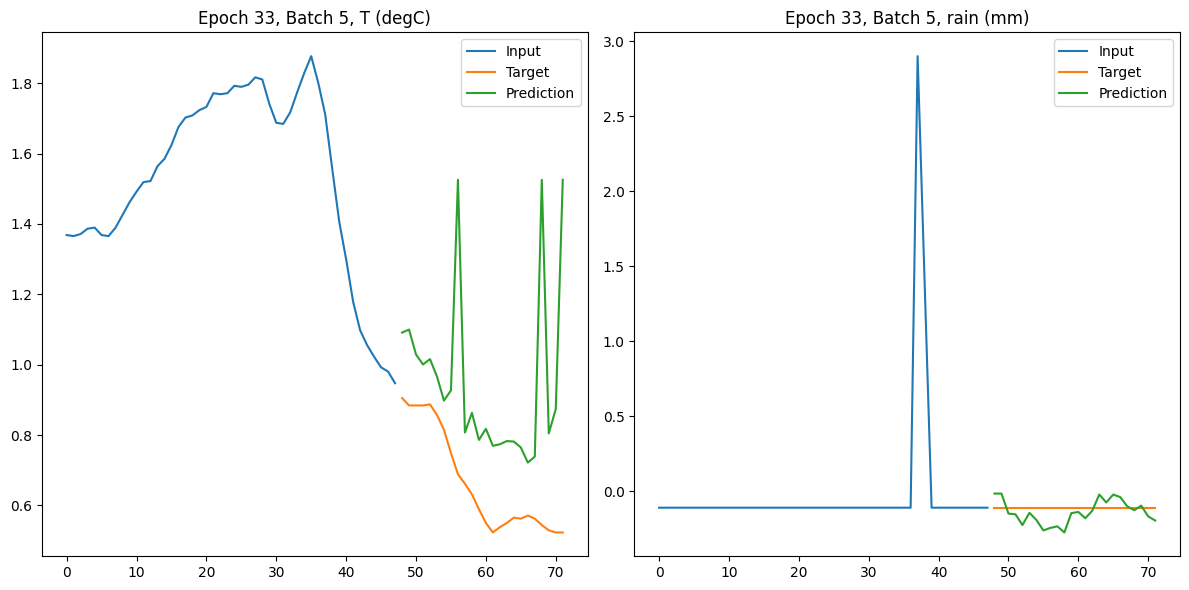

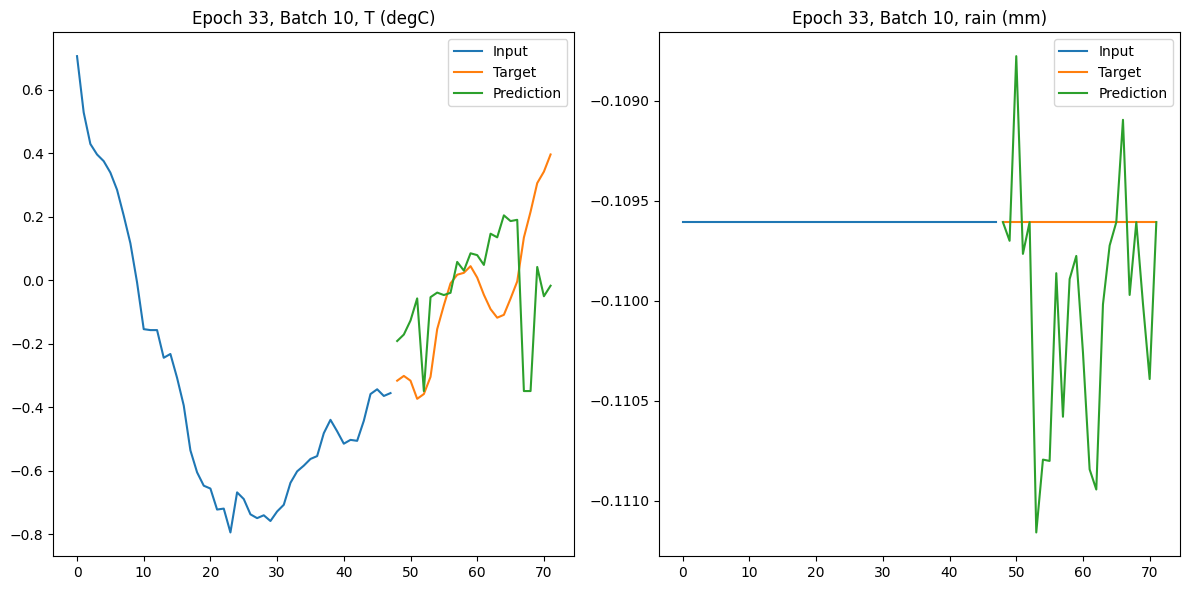

Epoch 33/50, Train Loss: 0.6670
Epoch 33/50, Validation Loss: 0.8819


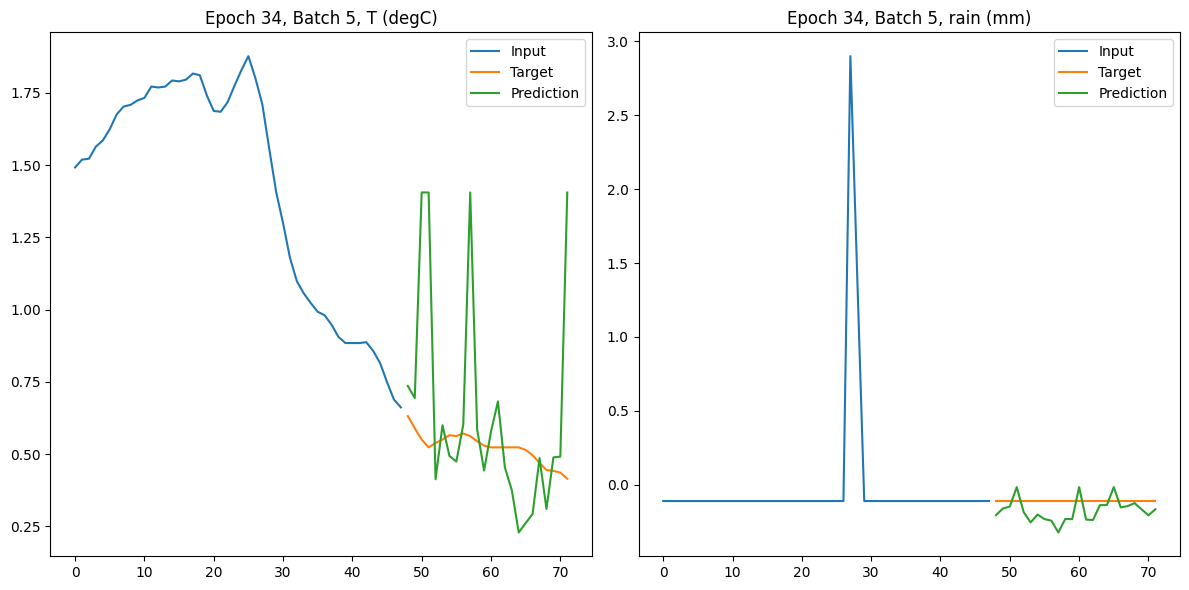

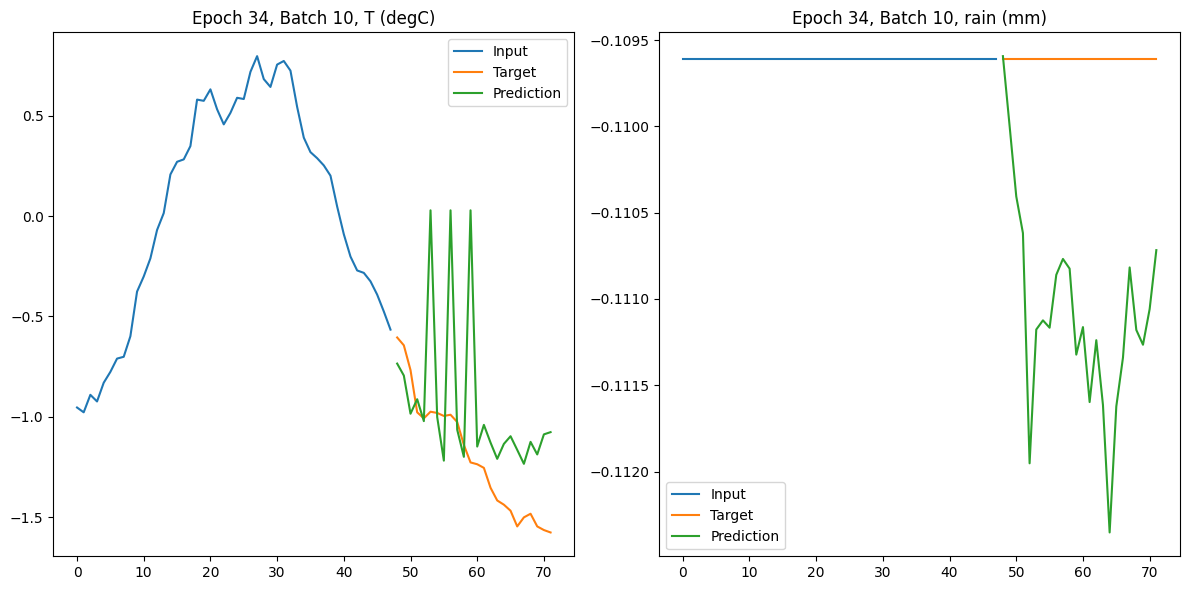

Epoch 34/50, Train Loss: 0.6592
Epoch 34/50, Validation Loss: 0.8787


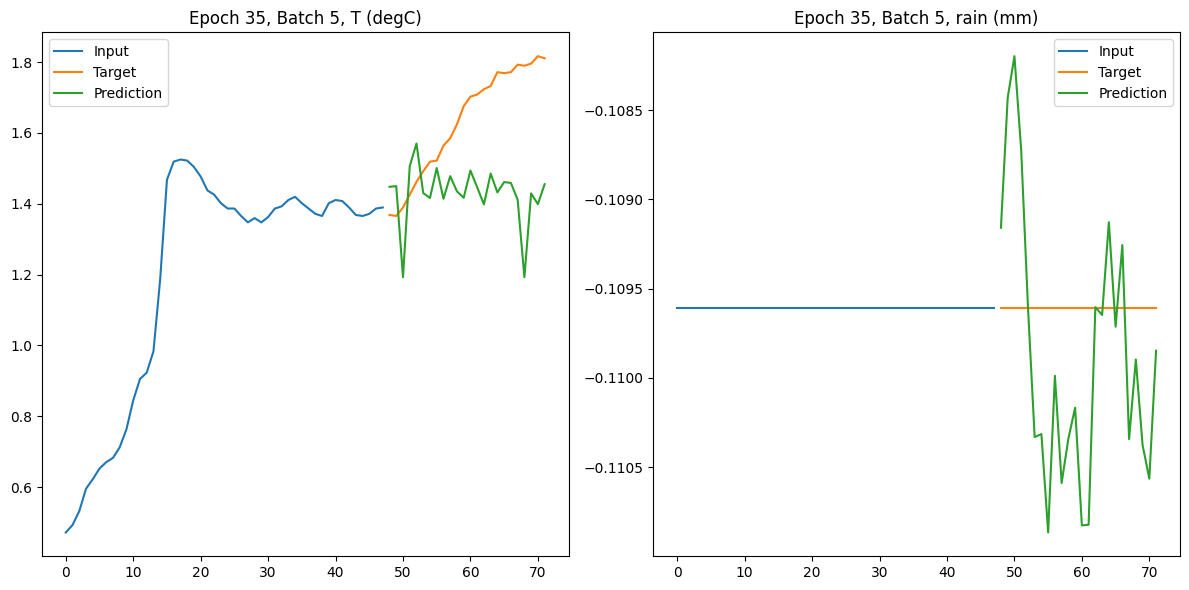

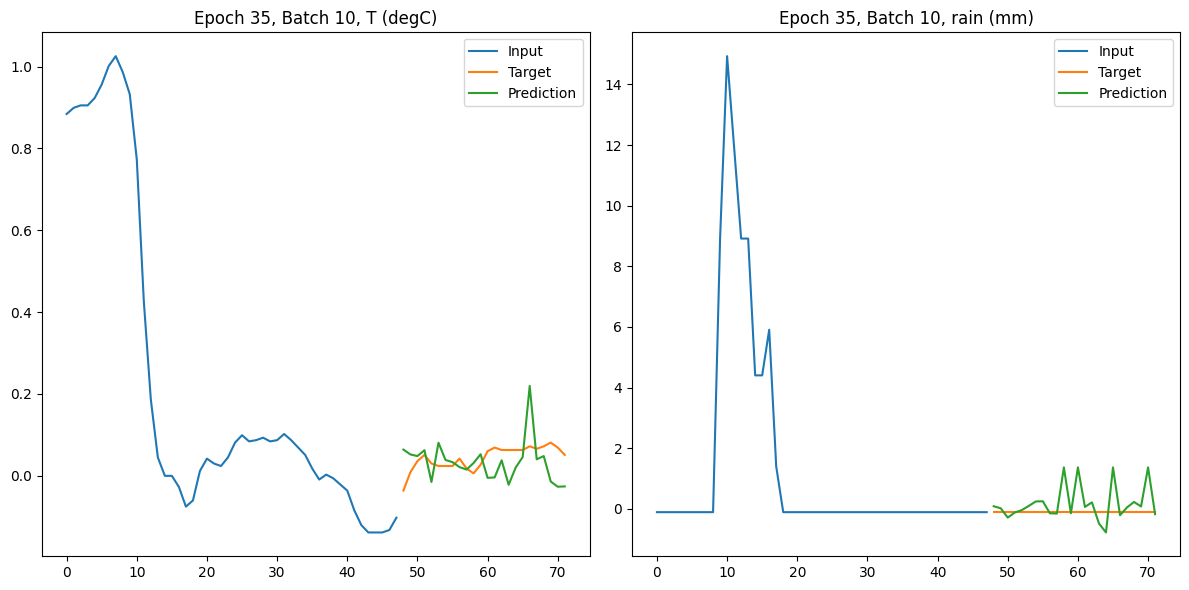

Epoch 35/50, Train Loss: 0.6521
Epoch 35/50, Validation Loss: 0.8706


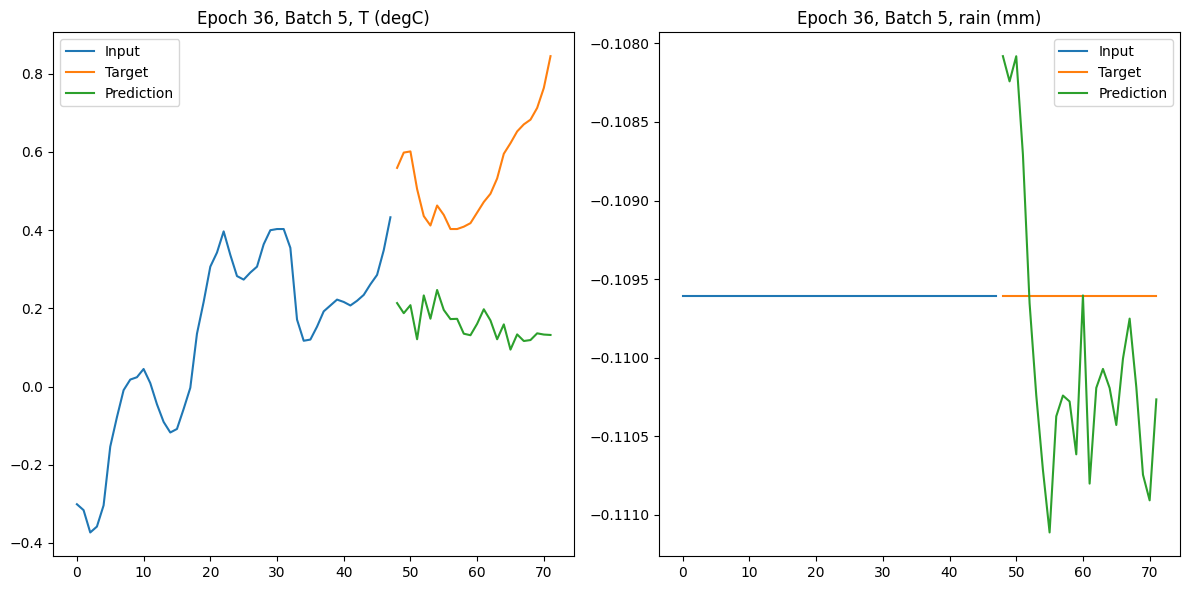

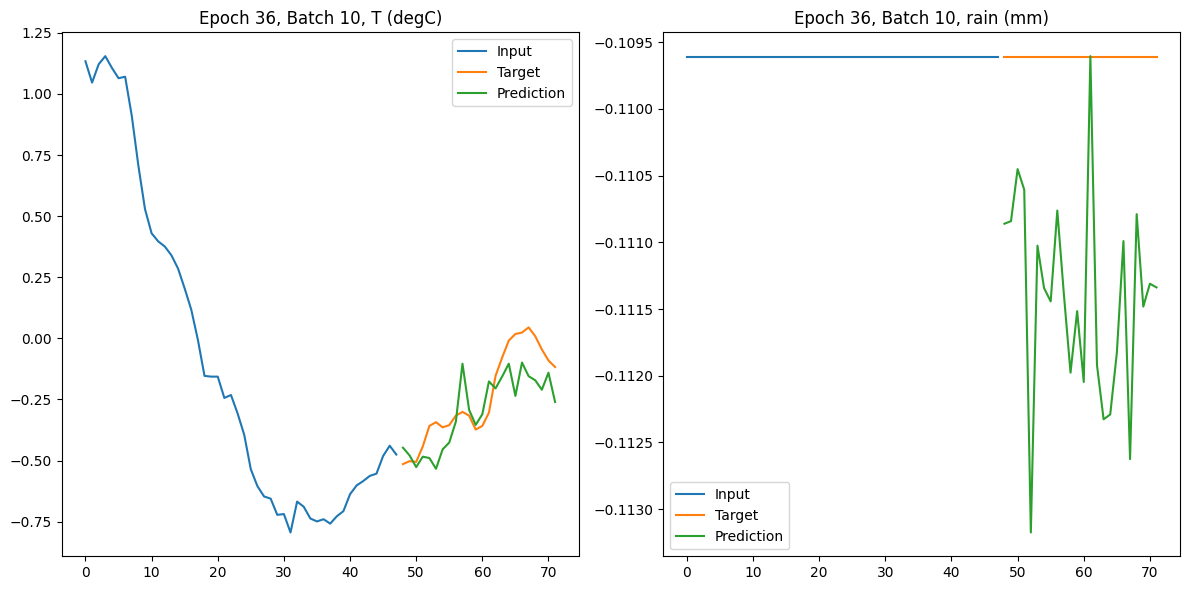

Epoch 36/50, Train Loss: 0.6442
Epoch 36/50, Validation Loss: 0.8635


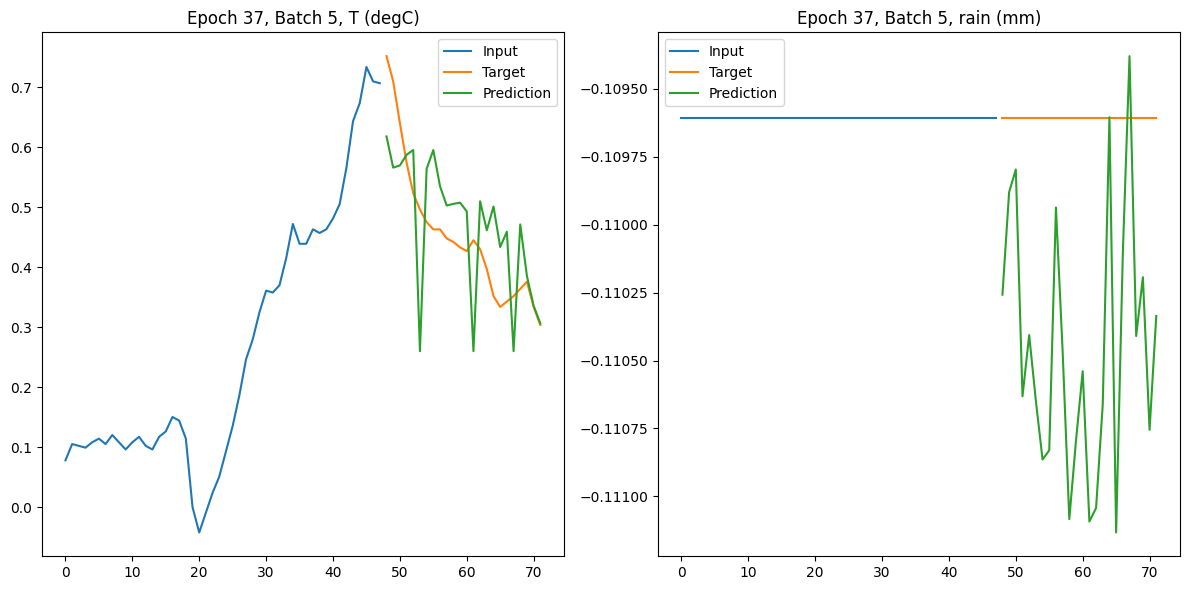

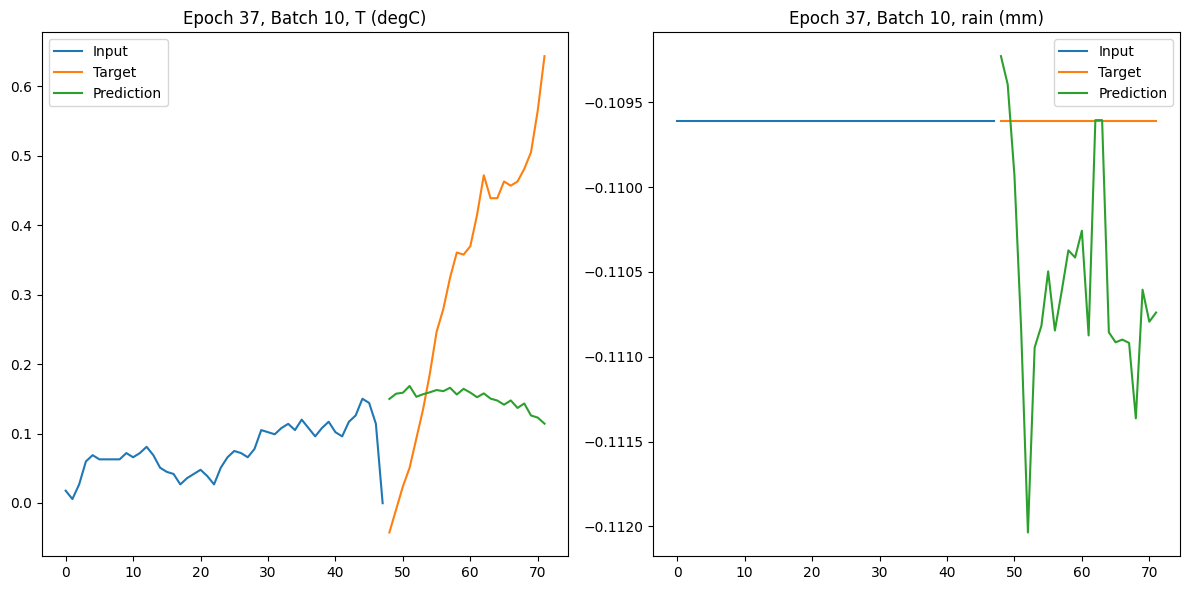

Epoch 37/50, Train Loss: 0.6363
Epoch 37/50, Validation Loss: 0.8544


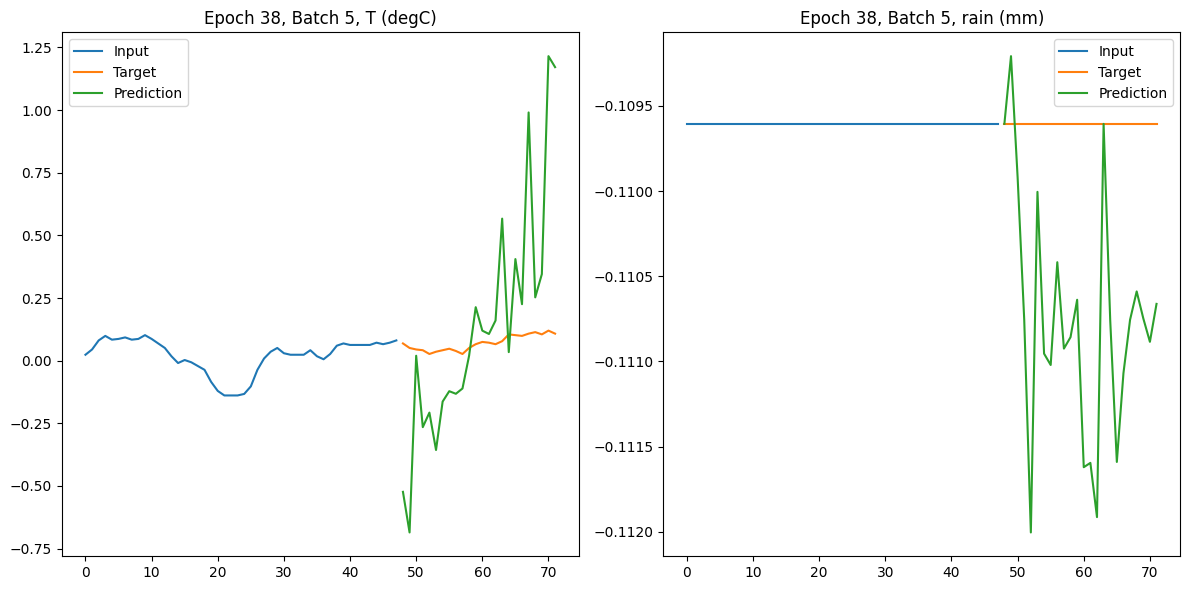

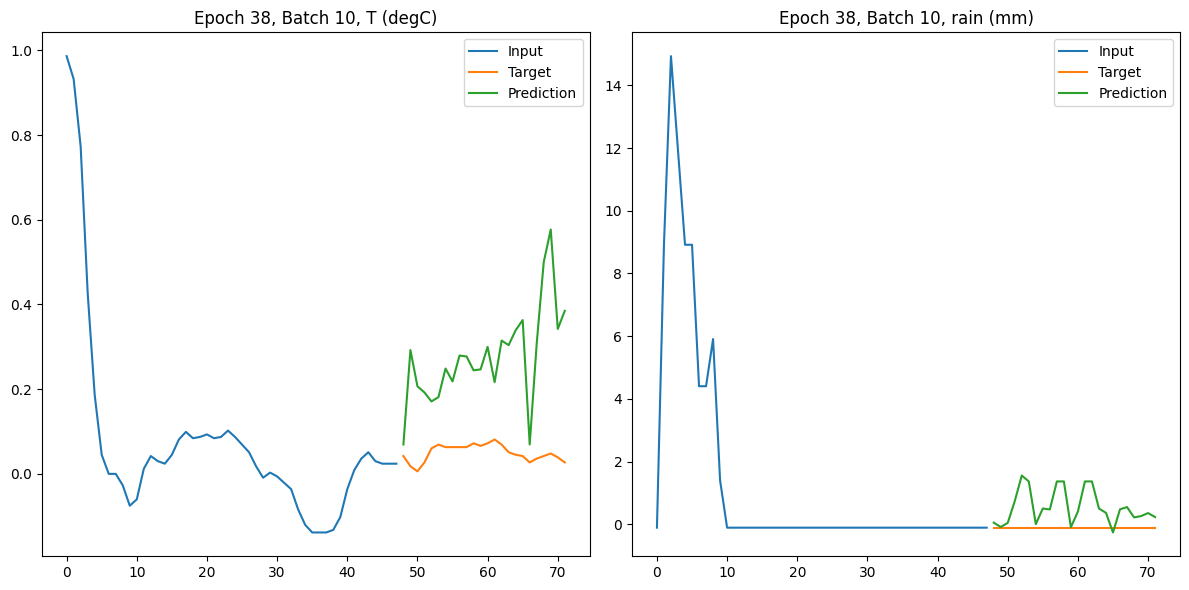

Epoch 38/50, Train Loss: 0.6288
Epoch 38/50, Validation Loss: 0.8487


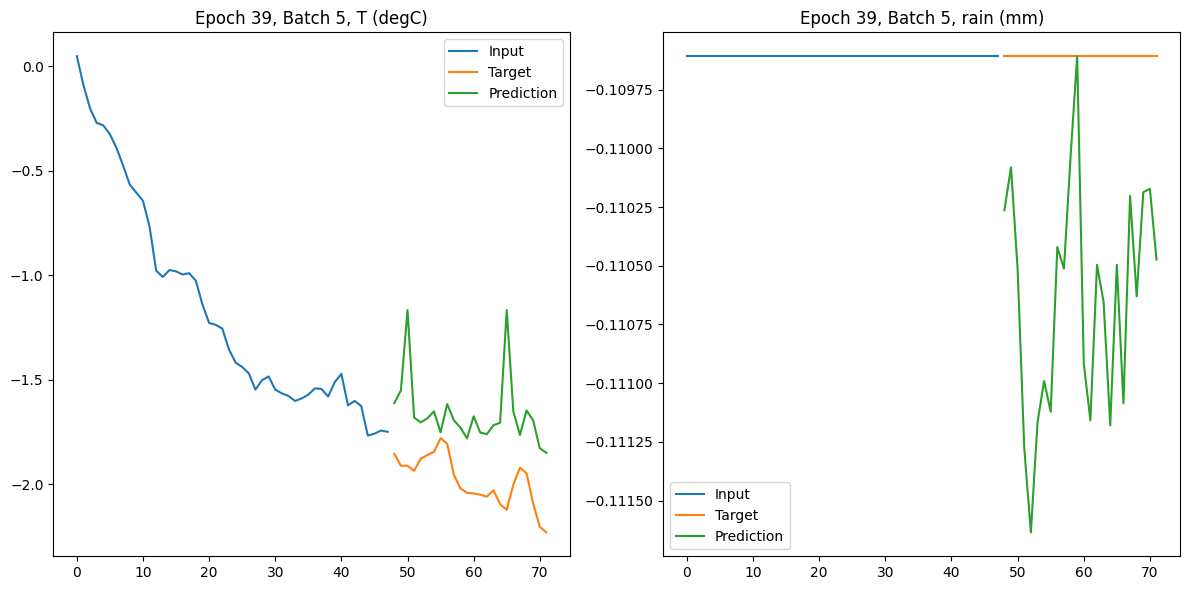

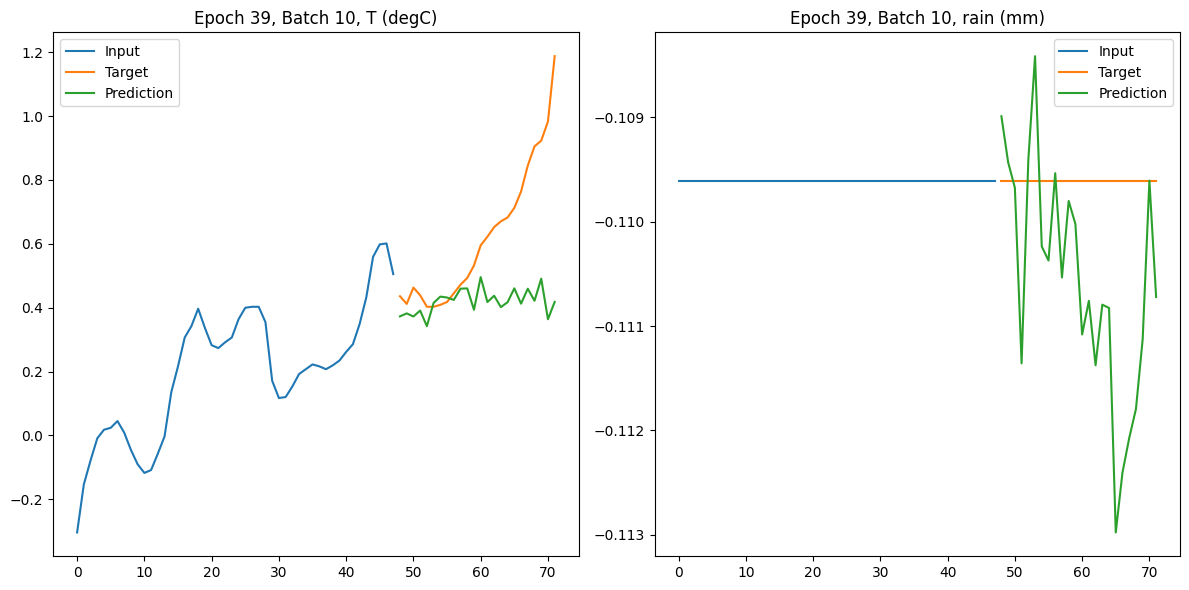

Epoch 39/50, Train Loss: 0.6219
Epoch 39/50, Validation Loss: 0.8491


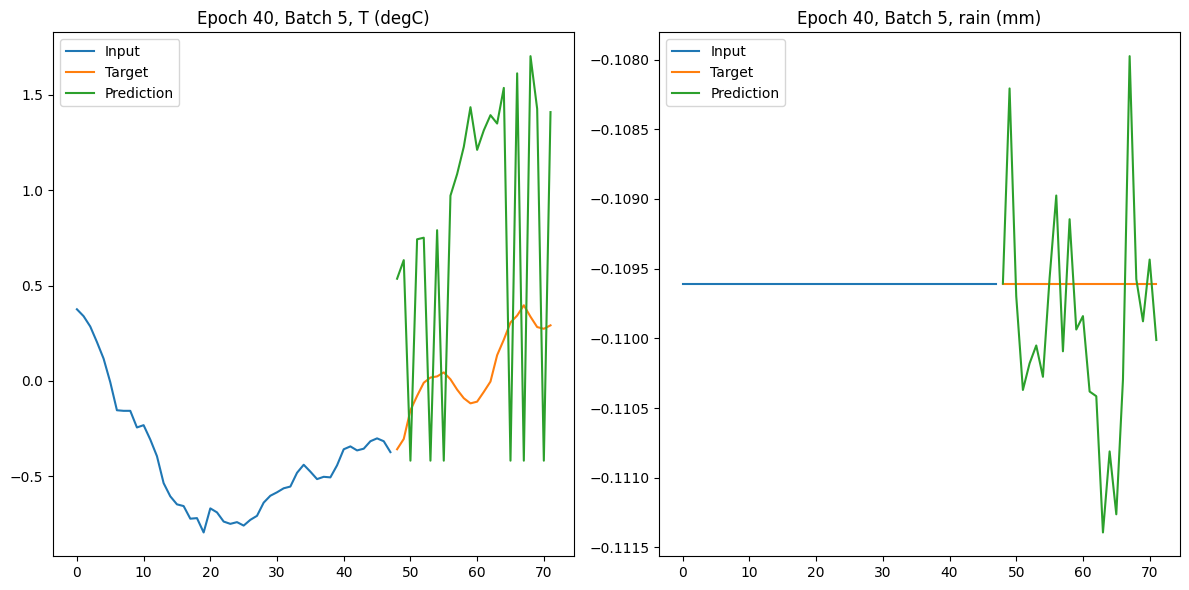

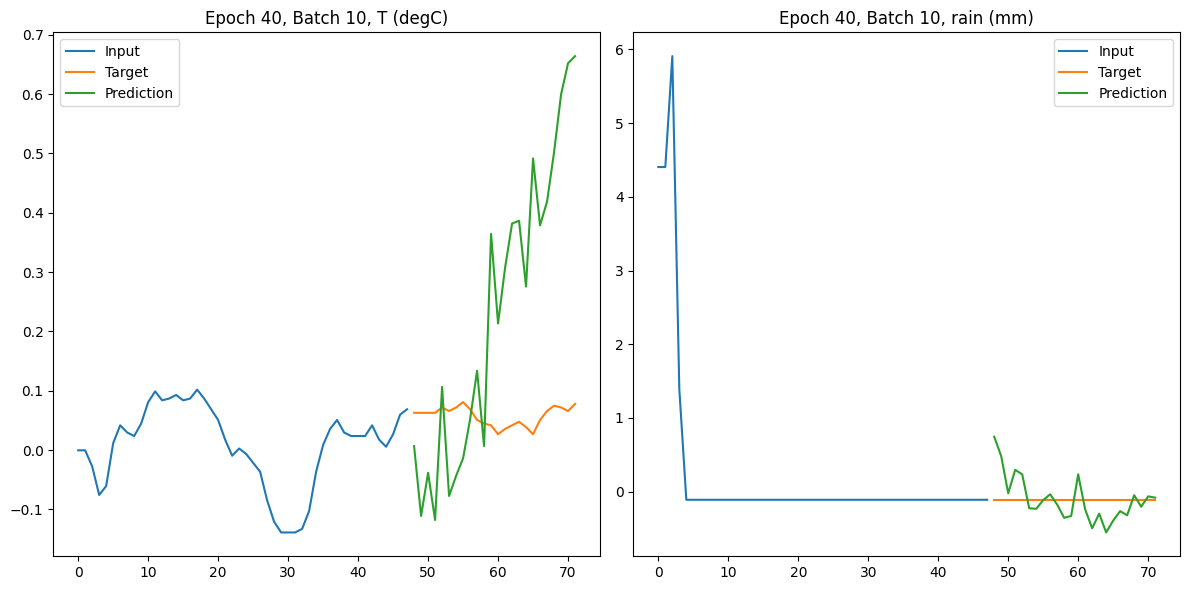

Epoch 40/50, Train Loss: 0.6162
Epoch 40/50, Validation Loss: 0.8474


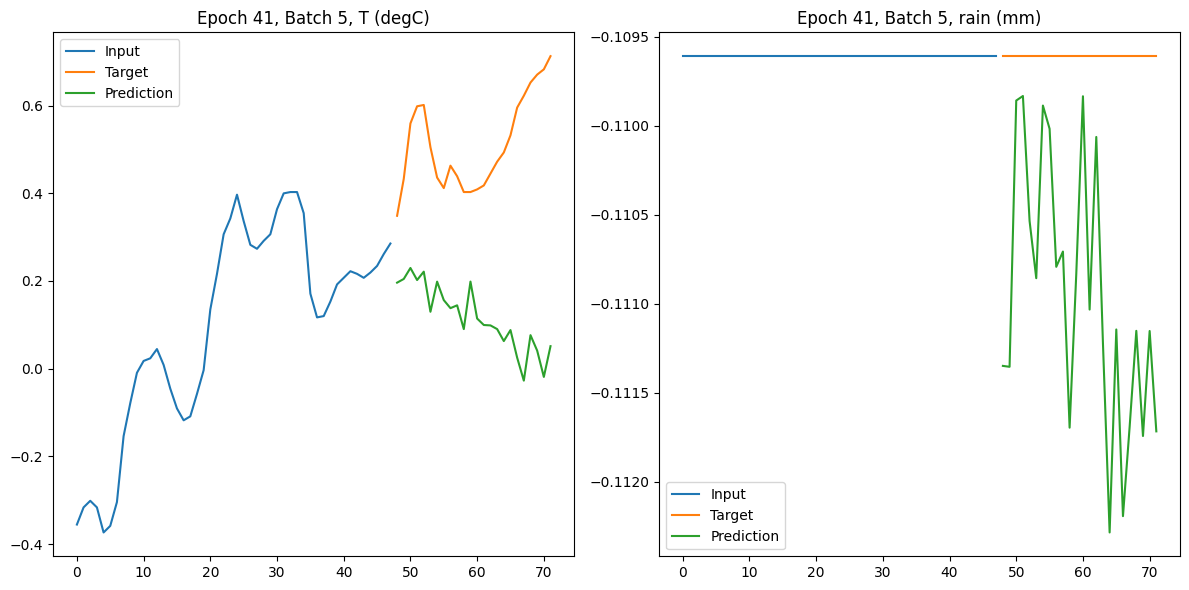

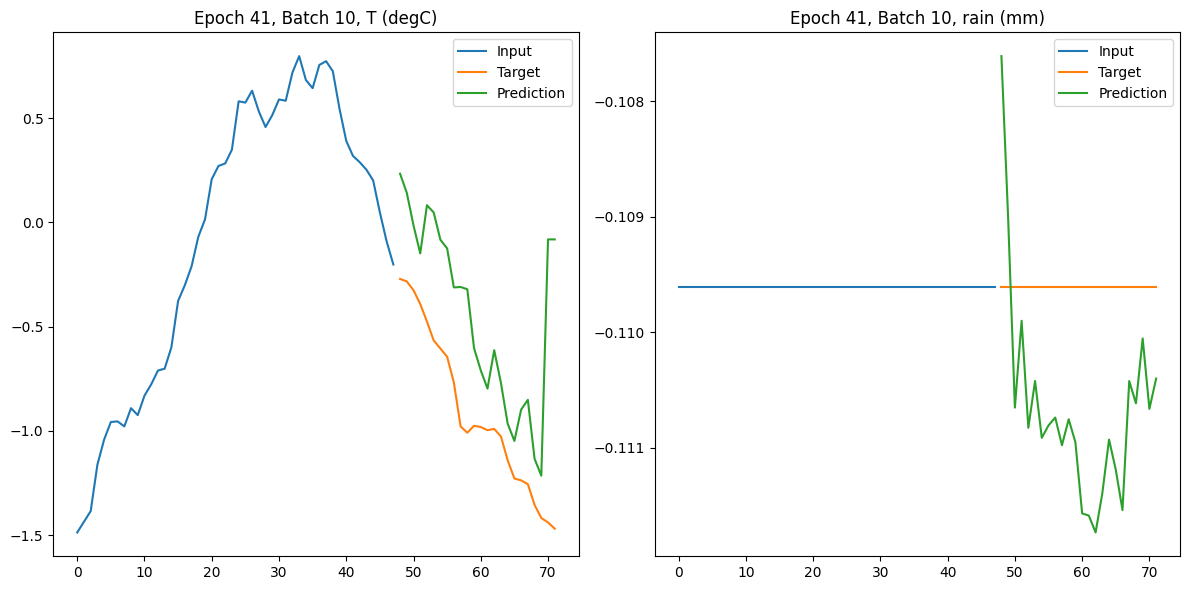

Epoch 41/50, Train Loss: 0.6107
Epoch 41/50, Validation Loss: 0.8443


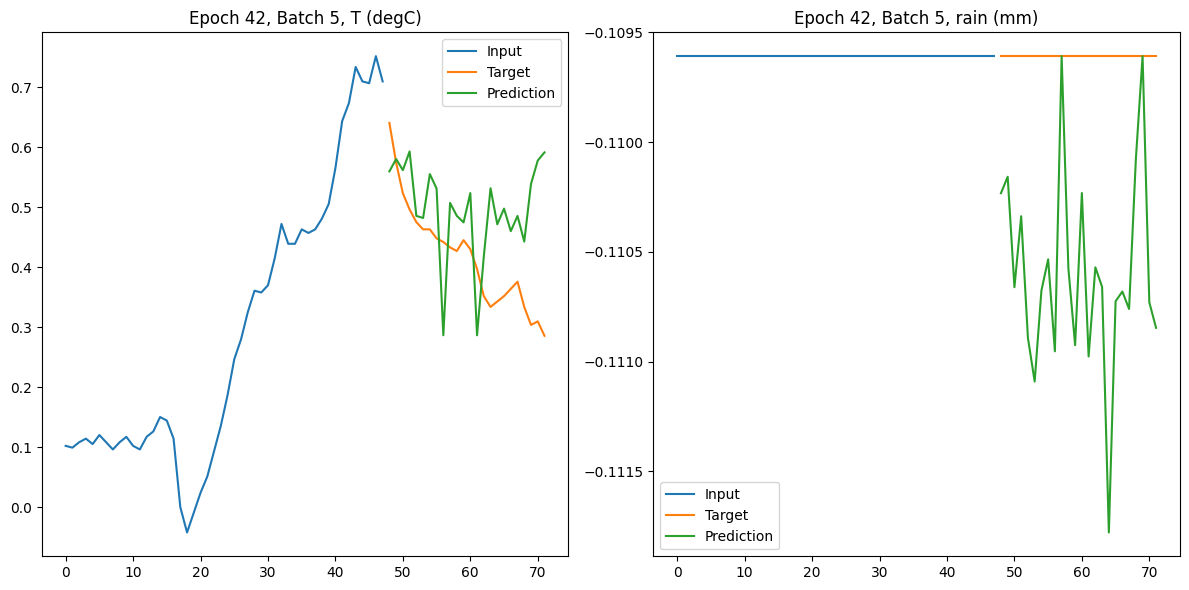

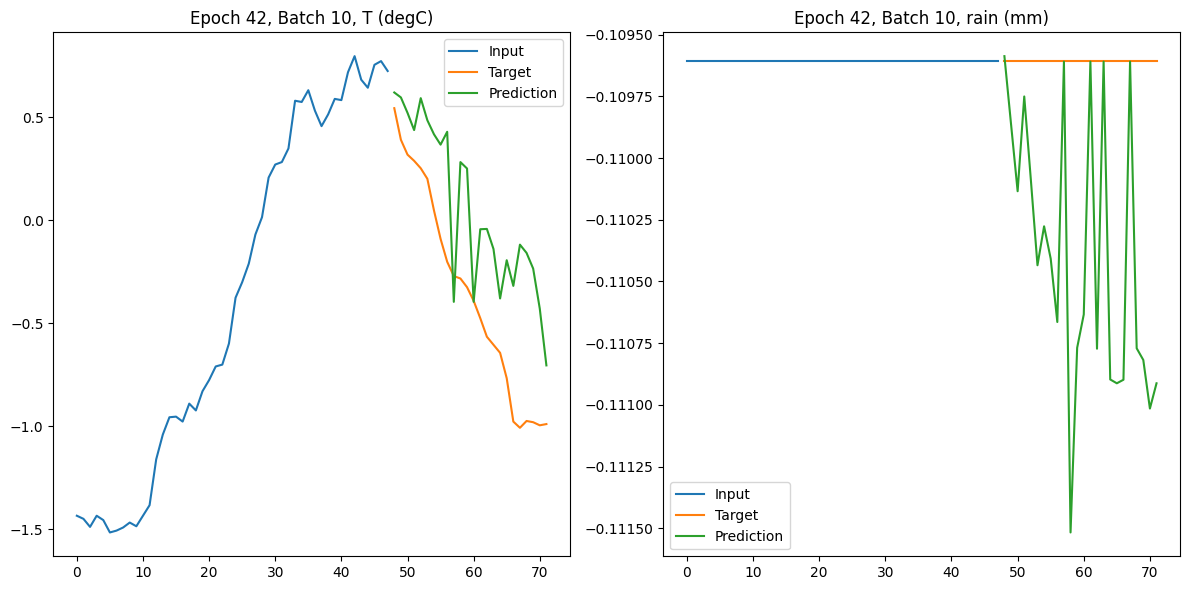

Epoch 42/50, Train Loss: 0.6045
Epoch 42/50, Validation Loss: 0.8418


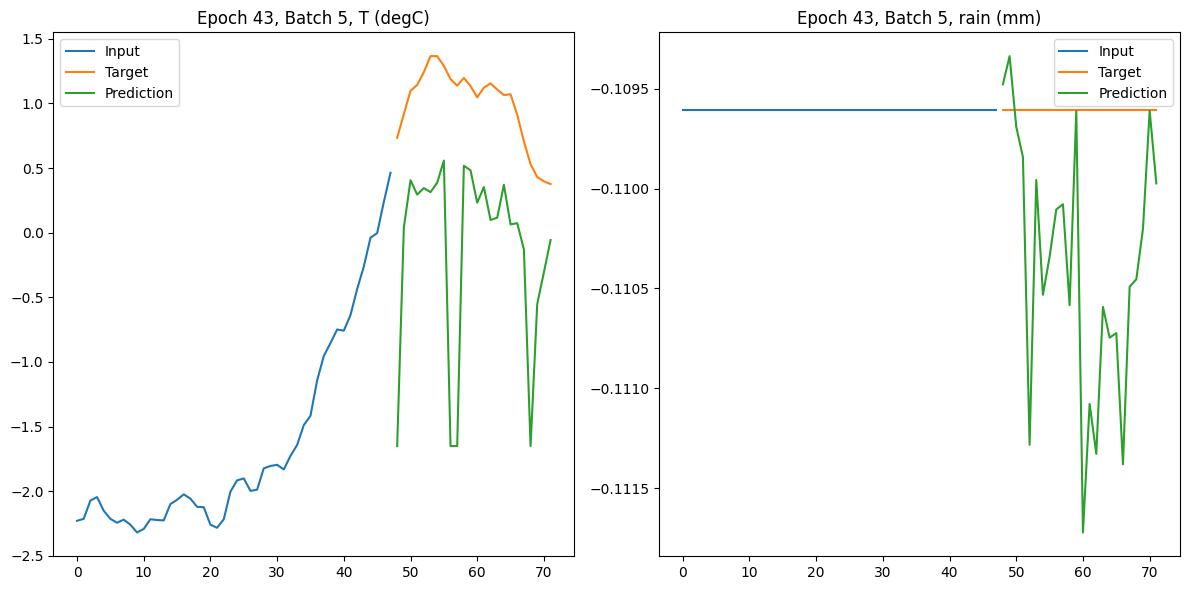

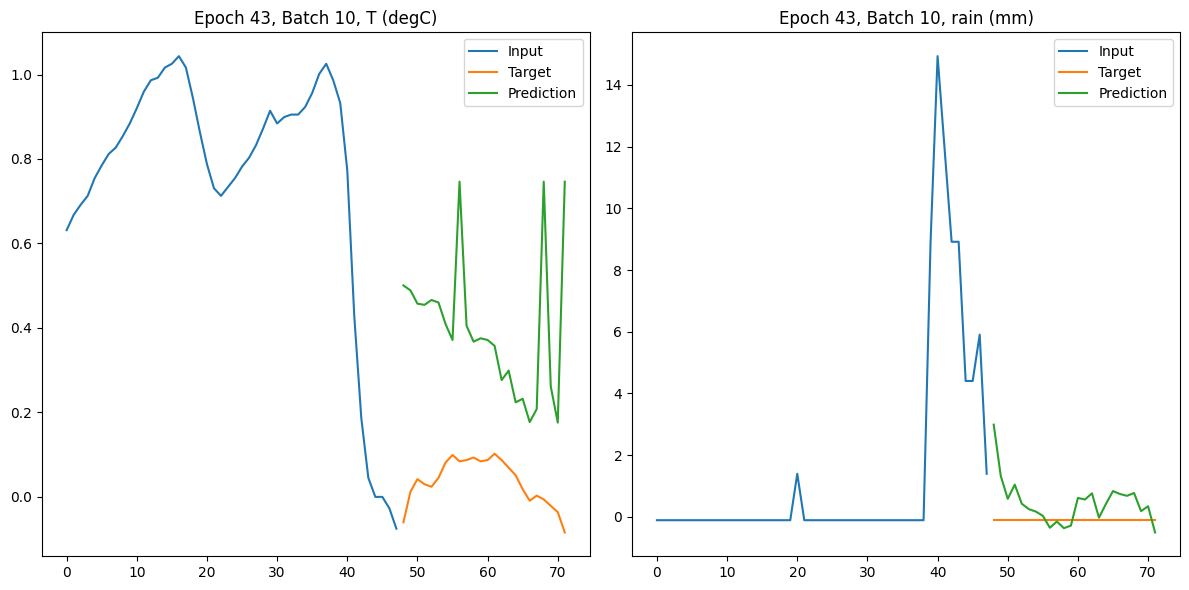

Epoch 43/50, Train Loss: 0.5981
Epoch 43/50, Validation Loss: 0.8408


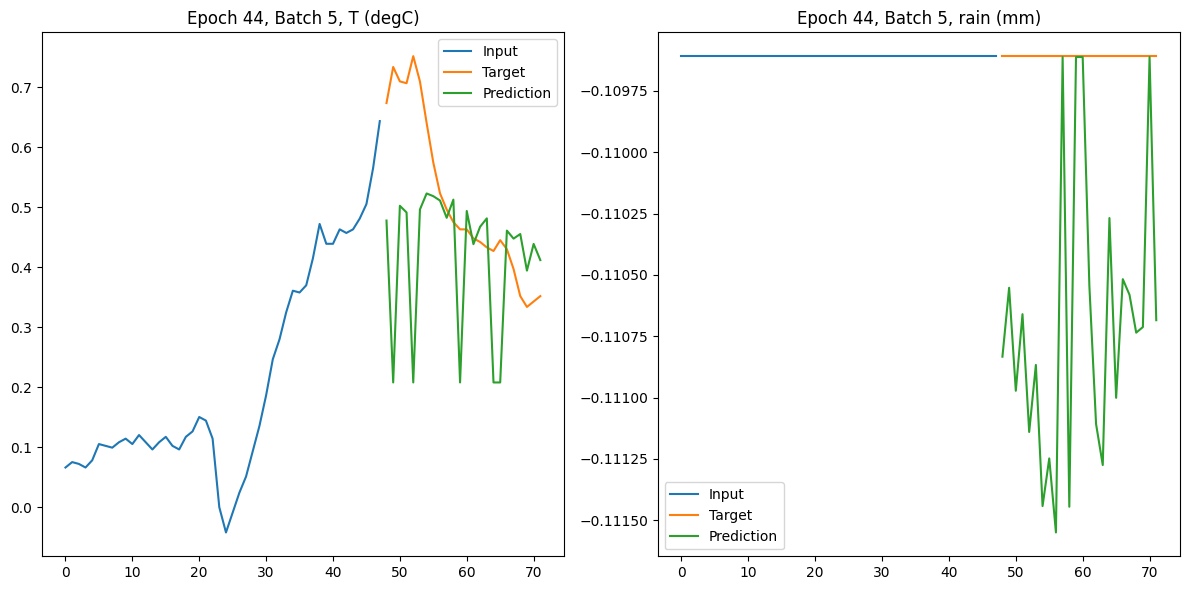

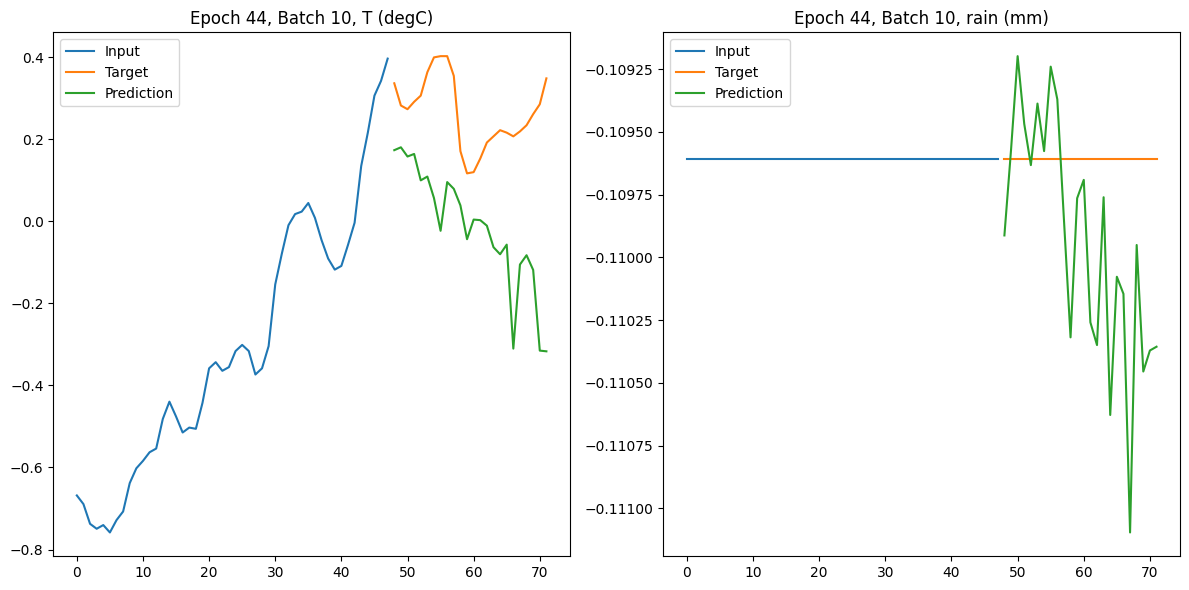

Epoch 44/50, Train Loss: 0.5938
Epoch 44/50, Validation Loss: 0.8410


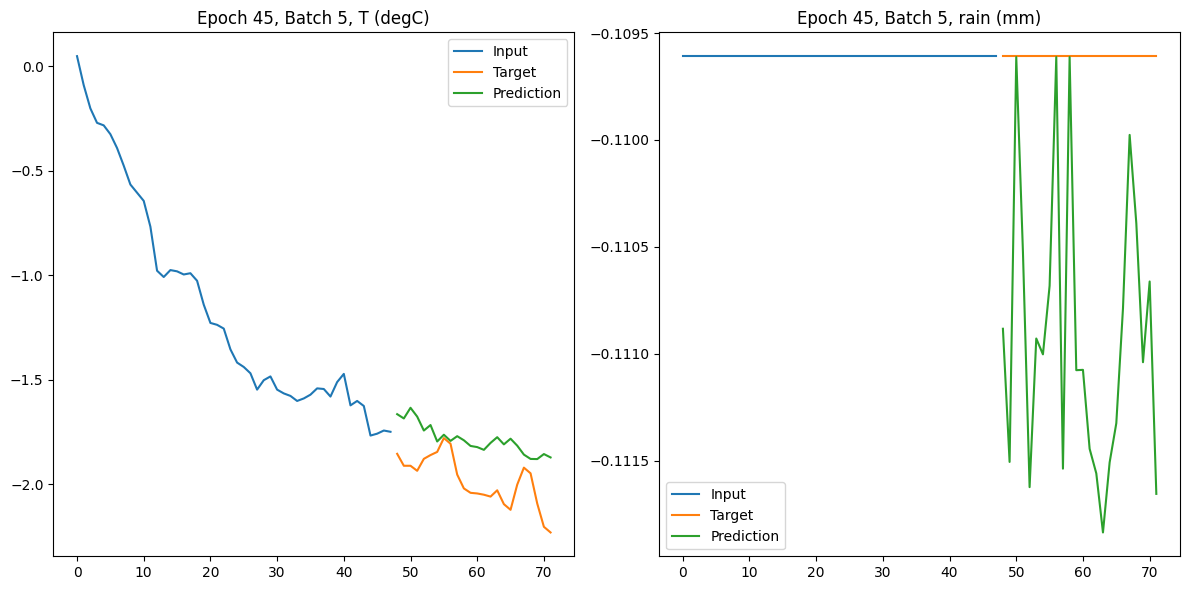

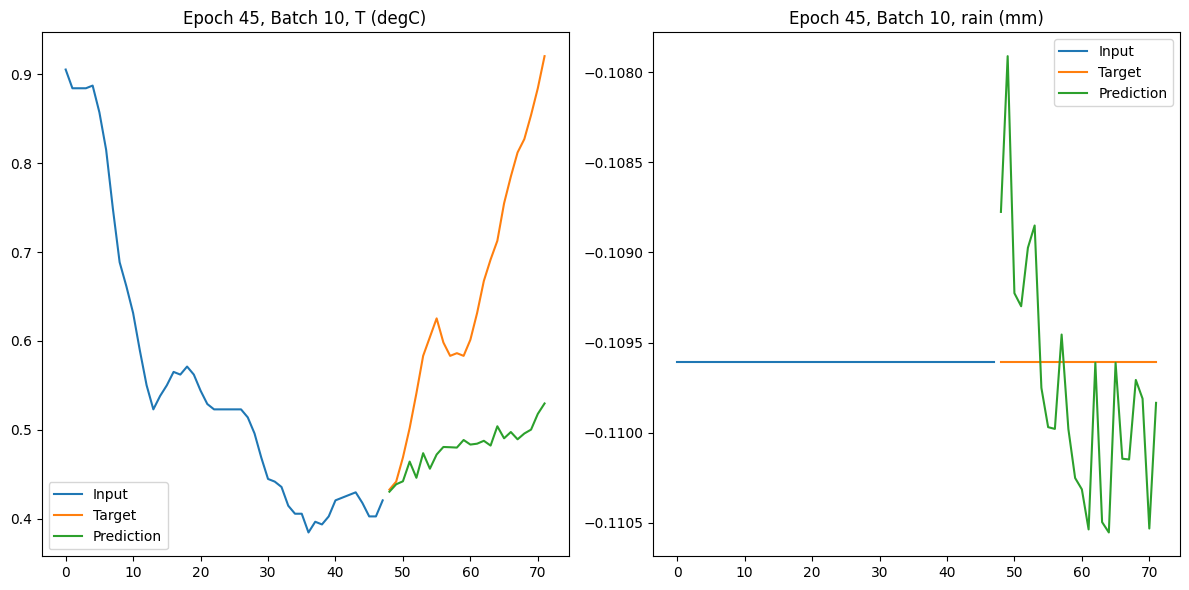

Epoch 45/50, Train Loss: 0.5896
Epoch 45/50, Validation Loss: 0.8400


In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = model.to(device)

# Number of epochs
num_epochs = 50  # Replace with the number of epochs you want to train for


train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()  # Clear gradients from the previous step
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
    

            outputs = model(inputs.float())  # Forward pass: compute the model output
            loss = criterion(outputs, targets.float())

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            if (idx + 1) % 5 == 0 or (idx + 1) == len(train_loader):
                visualize(inputs, targets, outputs, epoch, idx, ['T (degC)', 'rain (mm)'], seq_len)

    
    # Compute average training loss
    average_train_loss = sum(train_losses) / len(train_losses)
    save_checkpoint(model, optimizer, epoch, filename=f"checkpoints/model_checkpoint_epoch_{epoch+1}.pth")
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}")
    
    
    # Validation loop (if you have a validation set)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
            outputs = model(inputs.float())
            # Expand the target tensor to match the output shape
            loss = criterion(outputs, targets.float())
            val_losses.append(loss.item())
        
        # Compute average validation loss
        average_val_loss = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}")


In [31]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation
    test_losses = []
    for batch in test_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
        outputs = model(inputs.float())
        # Expand the target tensor to match the output shape
        loss = criterion(outputs, targets.float())
        test_losses.append(loss.item())


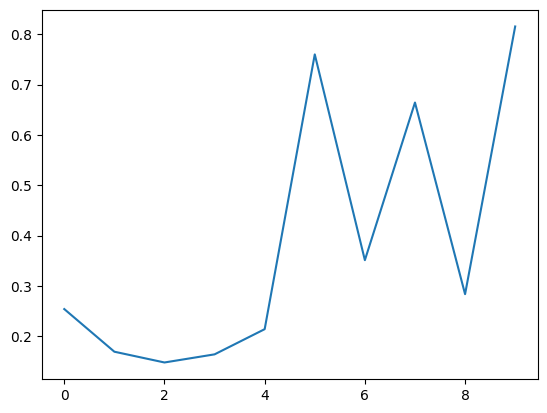

In [36]:
plt.plot(train_losses)

# NDVI 

In [4]:
NDVI = xr.open_dataarray("/s3/scratch/wessim.omezzine/ClimaX/Data/Downscaling/Rainfall/Mozambique/Regions/region_1/data/r1h.nc").isel(time=slice(0,729))

In [5]:
ndvi = NDVI.isel(latitude=10,longitude=10)

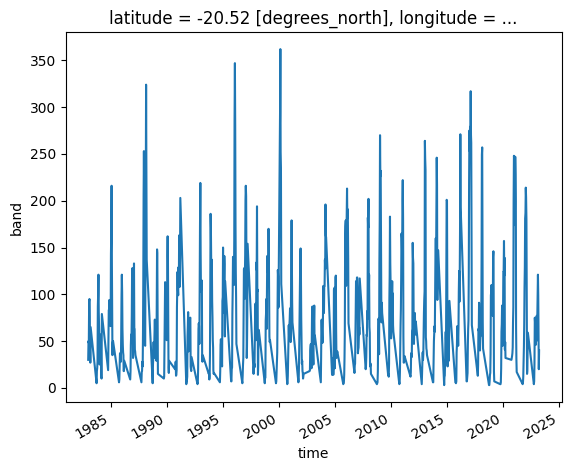

In [6]:
ndvi.plot.line()

In [7]:
ndvi_df  = ndvi.to_dataframe().reset_index()[['time', 'band']]
ndvi_df.rename(columns={'band': 'ndvi'}, inplace=True)
# Set the 'time' column as the index
ndvi_df.set_index('time', inplace=True)

In [8]:
# Normalize the data
scaler = StandardScaler()
ndvi_df['ndvi'] = scaler.fit_transform(ndvi_df[['ndvi']])

In [77]:
class NDVIDataset(Dataset):
    def __init__(self, data, seq_len, prediction_len, scale=True):
        self.seq_len = seq_len
        self.pred_len = prediction_len
        self.data = data
        self.features = data.columns.tolist()
        self.target = 'ndvi'  # You will need to set your target variable here


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[self.features].iloc[index:index+self.seq_len].values
        y = self.data[self.target].iloc[index+self.seq_len:index+self.seq_len+self.pred_len].values
        
        
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1).transpose(0,1)

In [78]:
# Parameters for the dataset
seq_len = 10 # For example, using 6 dekads of data for prediction
prediction_len = 3  # Predict the next 3 dekads
num_features = 1  # Number of features in your dataset (ndvi)

dataset = NDVIDataset(ndvi_df, seq_len, prediction_len)
x, y = dataset[0]
x.shape, y.shape

(torch.Size([10, 1]), torch.Size([1, 3]))

In [38]:
# Create DataLoader for training
batch_size = 64

# Define the size of the splits
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Calculate the number of samples in each set
n = len(ndvi_df)
train_end = int(train_size * n)
val_end = train_end + int(val_size * n)

# Split the data
train_data = ndvi_df[:train_end]
val_data = ndvi_df[train_end:val_end]
test_data = ndvi_df[val_end:]

# Create WeatherDataset instances for each set
train_dataset = NDVIDataset(train_data, seq_len, prediction_len)
val_dataset = NDVIDataset(val_data, seq_len, prediction_len)
test_dataset = NDVIDataset(test_data, seq_len, prediction_len)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [39]:
from types import SimpleNamespace



# Configuration for PatchTSTModel
config = {
    'c_in':1,
    'enc_in': ndvi_df.shape[1],  # Number of features
    'seq_len': seq_len,  # Length of input sequences
    'pred_len': prediction_len,  # Length of prediction
    'e_layers': 3,  # Number of encoder layers
    'n_heads': 8,  # Number of attention heads
    'd_model': 512,  # Model dimensionality
    'd_ff': 2048,  # Dimension of feed-forward network
    'dropout': 0.1,  # Dropout rate
    'fc_dropout': 0.1,  # Fully connected layer dropout
    'head_dropout': 0.1,  # Head dropout
    'individual': True,  # Individual layer normalization
    'patch_len': 3,  # Patch length (should divide seq_len)
    'stride': 1,  # Stride for patches
    'padding_patch': 0,  # Padding for patches
    'revin': True,  # Reversible instance normalization
    'affine': True,  # Affine parameter for instance normalization
    'subtract_last': False,  # Subtract last parameter for reversible instance normalization
    'decomposition': False,  # Whether to use decomposition
    'kernel_size': 3,  # Kernel size for decomposition
    # Additional parameters with their default values from the model
    'max_seq_len': 1024,
    'd_k': 64,
    'd_v': 64,
    'norm': 'BatchNorm',
    'attn_dropout': 0.0,
    'act': 'gelu',
    'key_padding_mask': 'auto',
    'padding_var': None,
    'attn_mask': None,
    'res_attention': True,
    'pre_norm': False,
    'store_attn': False,
    'pe': 'zeros',
    'learn_pe': True,
    'pretrain_head': False,
    'head_type': 'flatten',
    'verbose': False,
}

In [40]:
# Convert the configuration dictionary to an object
config_obj = SimpleNamespace(**config)

# Instantiate the model with the configuration object
model = PatchTSTModel(config_obj).float()




# Step 3: Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Now the model is ready to be trained with your dataset
# Check if GPU is available and move the model to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=3, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
            (norm_attn): Sequential(
             

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(inputs, targets, outputs, epoch, idx, feature_names, seq_len):
    # Select a sample from the batch to visualize
    sample_index = 0  # You can choose any index from 0 to batch_size-1

    # Detach and move to CPU for visualization
    inputs_sample = inputs[sample_index].cpu().detach().numpy()
    targets_sample = targets[sample_index].cpu().detach().numpy()
    outputs_sample = outputs[sample_index].cpu().detach().numpy()

    # Plotting
    plt.figure(figsize=(12, 6))

    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)

        # Time axis
        time_input = np.arange(seq_len)
        time_future = np.arange(seq_len, seq_len + len(targets_sample))

        # Plot input, target, and output
        plt.plot(time_input, inputs_sample[:, i], label='Input')
        plt.plot(time_future, targets_sample[:, i], label='Target')
        plt.plot(time_future, outputs_sample[:, i], label='Prediction')

        plt.title(f'Epoch {epoch+1}, Batch {idx+1}, {feature_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [42]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = model.to(device)

# Number of epochs
num_epochs = 50  # Replace with the number of epochs you want to train for


train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()  # Clear gradients from the previous step
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
            print(inputs.shape)
            print(targets.shape)
 
            outputs = model(inputs.float())  # Forward pass: compute the model output
            loss = criterion(outputs, targets.float())

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            if (idx + 1) % 5 == 0 or (idx + 1) == len(train_loader):
                visualize(inputs, targets, outputs, epoch, idx, ['T (degC)', 'rain (mm)'], seq_len)

    
    # Compute average training loss
    average_train_loss = sum(train_losses) / len(train_losses)
    save_checkpoint(model, optimizer, epoch, filename=f"checkpoints/model_checkpoint_epoch_{epoch+1}.pth")
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}")
    
    
    # Validation loop (if you have a validation set)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        for batch in val_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
            outputs = model(inputs.float())
            # Expand the target tensor to match the output shape
            loss = criterion(outputs, targets.float())
            val_losses.append(loss.item())
        
        # Compute average validation loss
        average_val_loss = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}")


torch.Size([64, 1, 10])
torch.Size([64, 1, 3])


RuntimeError: maximum size for tensor at dimension 2 is 1 but size is 3

In [ ]:
ndvi_df